In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dsharp_opac as opacity
import emcee
import corner
import scipy
from multiprocess import Pool
from gofish import imagecube
from matplotlib.lines import Line2D

fortran mie routines unavailable


/data/discsim2/fz258/.conda/envs/bayesian_analysis/lib/python3.9/site-packages/dsharp_opac/dsharp_opac.py:42: UserWarning: could not import compiled mie code - mie calculation will be slow
  warnings.warn('could not import compiled mie code - mie calculation will be slow')


Find folder location at `module.__file__`.

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
%matplotlib inline
%matplotlib notebook

In [4]:
plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'axes.linewidth': 2.25})
plt.rcParams.update({'axes.labelpad': 5})

plt.rcParams.update({'xtick.major.size': 7.5})
plt.rcParams.update({'xtick.minor.size': 4.5})
plt.rcParams.update({'ytick.major.size': 7.5})
plt.rcParams.update({'ytick.minor.size': 4.5})

plt.rcParams.update({'xtick.major.width': 1.5})
plt.rcParams.update({'ytick.major.width': 1.5})
plt.rcParams.update({'xtick.minor.width': 1.5})
plt.rcParams.update({'ytick.minor.width': 1.5})

plt.rcParams.update({'xtick.major.pad': 5})
plt.rcParams.update({'ytick.major.pad': 5})

plt.rcParams.update({'xtick.top': True})
plt.rcParams.update({'ytick.right': True})
plt.rcParams.update({'xtick.labeltop': False})
plt.rcParams.update({'ytick.labelright': False})

plt.rcParams.update({'xtick.direction': "in"})
plt.rcParams.update({'ytick.direction': "in"})

Constants (from here: https://docs.astropy.org/en/stable/constants/index.html#module-astropy.constants)

In [5]:
au    = 1.49597871e+13         #cm
c_vel = 29979245800.0          #cm/s
h_pl  = 6.62607015e-27         #erg s
k_B   = 1.380649e-16           #erg/K
lsun  = 3.828e+33              #erg/s
s_SB  = 5.6703744191844314e-05 #g/K4/s3

Step_1 - Load the data:

In [6]:
disc_PA   = 11.28   #p.a. from Cathie's paper
disc_inc  = 49.24   #inclination from Cathie's paper
disc_dist = 160.318 #pc

In [7]:
def beam_to_sr(data, bmin, bmaj):
    """ Convert flux in Jy/beam to Jy/sr."""
    
    omega  = np.radians(bmin/3600.)
    omega *= np.radians(bmaj/3600.)
    
    beam_area = np.pi*omega*(4.*np.log(2.))**-1
    
    return data/beam_area

In [8]:
fac = 1 #reduction factor in total number of pixels

<IPython.core.display.Javascript object>


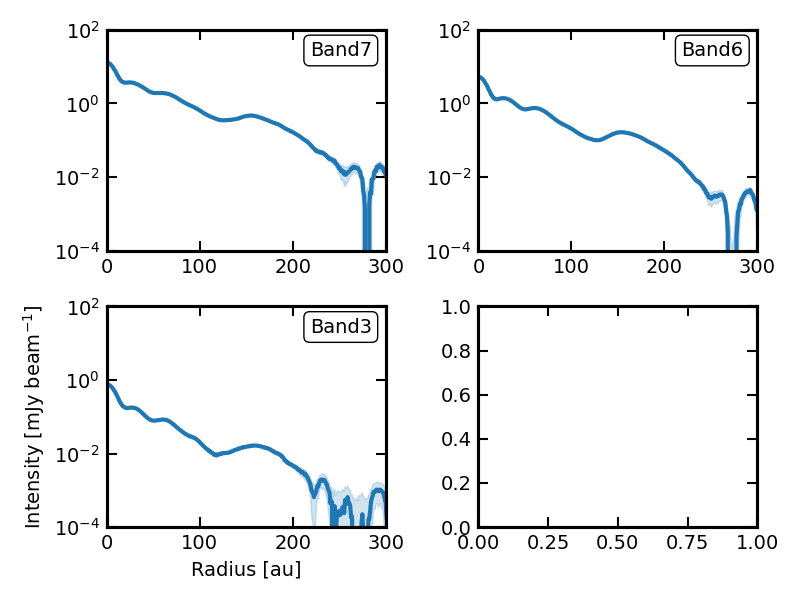

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [9]:
profiles_CITau = [
    '../CI_Tau_LB_band7_initcont_cent_-0.5robust_1.0sigma.image.tt0.fits',
    '../CI_Tau_LB_band6_new_initcont_cent_0.5robust_1.0sigma.image.tt0.fits',
    '../CI_Tau_LB_band3_initcont_cent_PSsub_0.25robust_1.0sigma.image.tt0.fits',
]

path_to_profiles = './'

label = ['Band7', 'Band6', 'Band3', 'BandKa']

fig, axs = plt.subplots(2,2,figsize=(8.,6.))
axs = axs.ravel()

dr = fac * 0.0058 #arcsec

for idx in range(len(profiles_CITau)):
    
    cube = imagecube(path_to_profiles + profiles_CITau[idx])
        
    x, y, dy = cube.radial_profile(inc=disc_inc, PA=disc_PA, dr=dr)
    
    y_b  = beam_to_sr(y, cube.bmin,cube.bmaj)
    dy_b = beam_to_sr(dy,cube.bmin,cube.bmaj)
    
    x  *= disc_dist #au
    y  *= 1e3  #mJy
    dy *= 1e3  #mJy
    
    l, = axs[idx].semilogy(x, y, lw=3., label=label[idx])
    axs[idx].fill_between(x, y - dy, y + dy, color=l.get_color(), alpha=0.2)

    np.savetxt(
        path_to_profiles + 'radprof_{}.dat'.format(label[idx]), np.array([x, y_b, dy_b]).T,
        header = 'Radius [au]\tIntensity [Jy/sr]\terror_Intensity [Jy/sr]'
    )
    
    axs[idx].set_xlim(0.,300.)
    axs[idx].set_ylim(1e-4,1e+2)
    
    axs[idx].text(0.95, 0.95, s=label[idx], ha='right', va='top', transform=axs[idx].transAxes, bbox=dict(boxstyle="round", ec="k", fc="w",))
    
    #print(cube.bmin,cube.bmaj) 

axs[2].set_xlabel(r'Radius [au]')
axs[2].set_ylabel(r'Intensity [mJy beam$^{-1}$]')

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


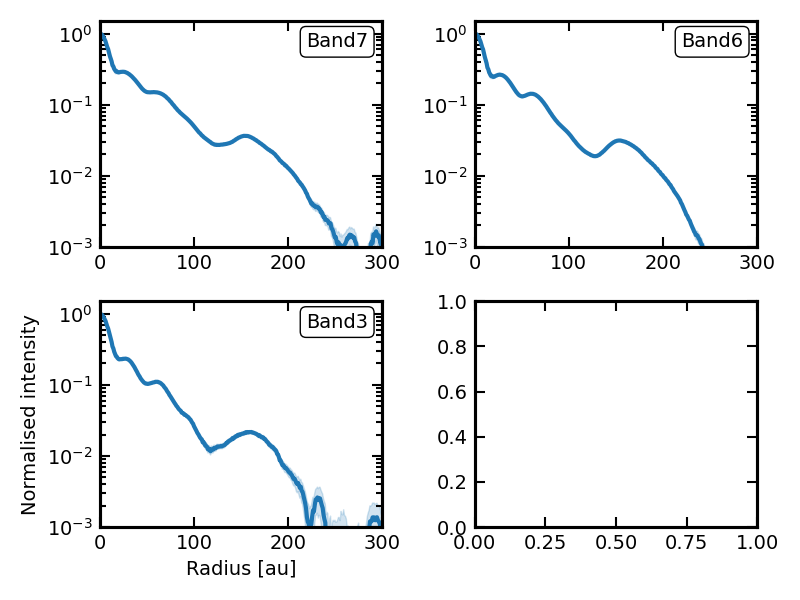

In [10]:
profiles_CITau = [
    'radprof_Band7.dat',
    'radprof_Band6.dat',
    'radprof_Band3.dat',
]

path_to_profiles = './'
 
label  = ['Band7', 'Band6', 'Band3', 'BandKa']

rad_init = np.zeros(int(1199/fac))
inu_init = np.zeros((3,int(1199/fac)))
enu_init = np.zeros((3,int(1199/fac)))

fig, axs = plt.subplots(2,2,figsize=(8.,6.))
axs = axs.ravel()

for idx in range(len(profiles_CITau)):
    
    x, y, dy = np.loadtxt(path_to_profiles + profiles_CITau[idx], skiprows=1, usecols=(0,1,2), unpack=True)
    
    inu_init[idx] = y
    enu_init[idx] = dy
    
    l, = axs[idx].semilogy(x, y/y[0], lw=3., label=label[idx])
    axs[idx].fill_between(x, (y - dy)/y[0], (y + dy)/y[0], color=l.get_color(), alpha=0.2)
        
    axs[idx].set_xlim(0.,300.)
    axs[idx].set_ylim(1e-3,1.5)
    
    axs[idx].text(0.95, 0.95, s=label[idx], ha='right', va='top', transform=axs[idx].transAxes, bbox=dict(boxstyle="round", ec="k", fc="w",))
    
    #print(cube.bmin,cube.bmaj)
    
rad_init = x

axs[2].set_xlabel(r'Radius [au]')
axs[2].set_ylabel(r'Normalised intensity')

fig.tight_layout()
plt.show()

Step_2 - Init the physical model:

In [11]:
def BlackBody(nu, temp):
    """ 
    Returns Planck's function in Jy/sr.
    Parameters:
    nu:   frequency in GHz
    temp: temperature in K
    """
    den = np.exp(h_pl*nu*1e9/(k_B*temp)) - 1.
    num = 2.*h_pl*(nu*1e9)**3/c_vel**2  # in erg/cm^2 = erg/(cm^2*Hz*s*sr)

    planck = num/den
    return planck*1e23  # in Jy/sr

In [12]:
def scattering_function(omega, tau, mu=np.cos(disc_inc*np.pi/180.)):
    """
    Returns physical model for dust emission due to absorption and scattering (from slab's approximation).
    See e.g. Equation 3 of Macías et al. 2021.
    Parameters:
    omega: single-scattering albedo
    tau:   total optical depth
    mu:    cosine of the inclination
    """
    epsilon = (1. - omega)**0.5

    _a = np.exp(-np.sqrt(3.)*epsilon*tau)*(epsilon-1.) - (epsilon+1.)

    _b = (1. - np.exp(-(np.sqrt(3.)*epsilon+1./mu)*tau))/(np.sqrt(3.)*epsilon*mu + 1. + 1e-300)

    _c = (np.exp(-tau/mu)-np.exp(-np.sqrt(3.)*epsilon*tau))/(np.sqrt(3.)*epsilon*mu - 1. + 1e-300)

    _f = (_b+_c)/(_a + 1e-300)

    return 1. - np.exp(-tau/mu) + omega * _f

Benchmarking of scattering_function against Figure 1 of Zhu et al. 2019

<IPython.core.display.Javascript object>


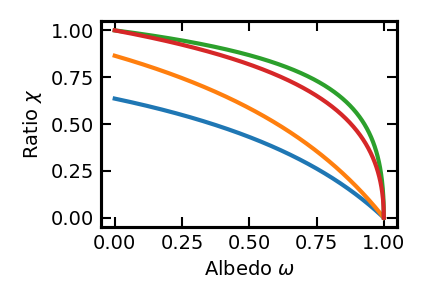

In [13]:
omega = np.linspace(0,1,1000)

fig, axs = plt.subplots(figsize=(4.25,3))

for _tau in [1.,100.]:
    for _mu in [0.99,0.5]:
    
        chi = scattering_function(omega=omega,tau=_tau,mu=_mu)
        
        axs.plot(omega,chi,lw=3.)

axs.set_xlabel(r'Albedo $\omega$')
axs.set_ylabel(r'Ratio $\chi$')

fig.tight_layout()
plt.show()

In [14]:
d         = np.load('/data/discsim2/fz258/dsharp_opac_notebook/datafiles/opacity_Ricci_compact(mine).npz')
a         = d['a']
lam       = d['lam']
k_abs     = d['k_abs']
k_sca     = d['k_sca']
gsca      = d['g']
k_sca_eff = (1 - gsca) * k_sca

In [15]:
def fitting_function(freq_avg, temp, lsigma, lamax, q):
    '''
    Returns intensity at a given radius in Jy/sr. See Macias et al. 2021 and Carrasco-Gonzalez et al. 2019.
    Parameters:
    freq_avg: average frequency of observations in GHz; *must be in decreasing order* (because size_averaga_opacity orders opacities with lambda)
    temp:     dust midplane temperature in K
    lsigma:   log10 of dust surface density in g/cm2
    lamax:    log10 of maximum grain size in cm
    q:        grain size 
    '''
    lam_avg   = c_vel/(freq_avg*1e9)
    res_eff   = opacity.size_average_opacity(lam_avg, a, lam, k_abs, k_sca_eff, q=q, plot=False)
    omg_eff   = res_eff['ks'] / (res_eff['ka'] + res_eff['ks']) #albedo
    opc_eff   = res_eff['ka'] + res_eff['ks']                   #total dust opacity (absorption + scattering)
    
    omg_init  = np.array([np.interp(lamax,np.log10(a),omg_eff[i]) for i in range(len(freq_avg))])
    opc_init  = np.array([np.interp(lamax,np.log10(a),opc_eff[i]) for i in range(len(freq_avg))])
    
    chi       = scattering_function(omega=omg_init,tau=opc_init*10.**lsigma)
    bb        = BlackBody(nu=freq_avg,temp=temp)
    
    inu_init  = bb * chi
    
    return inu_init

Input wavelengts [cm] = [0.08689636 0.12866629 0.20675342 0.30747944]
Albedo = [0.39309604 0.41364133 0.44791328 0.48159525]
Opacity [cm2/g] = [3.27624045 2.68949967 2.12472603 1.7430684 ]


<IPython.core.display.Javascript object>


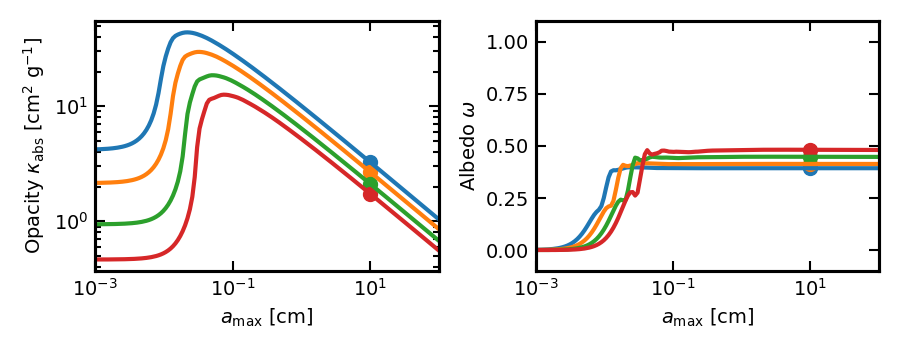

In [16]:
freq_avg  = np.array([345.,233.,145.,97.5]) #GHz
lamax     = 1                               #cm
q         = 3.5

lam_avg   = c_vel/(freq_avg*1e9)
print('Input wavelengts [cm] = {}'.format(lam_avg))

res_eff   = opacity.size_average_opacity(lam_avg, a, lam, k_abs, k_sca_eff, q=q, plot=False)

omg_eff   = res_eff['ks'] / (res_eff['ka'] + res_eff['ks']) #albedo
opc_eff   = res_eff['ka'] + res_eff['ks']                   #total dust opacity (absorption + scattering)
   
omg_init  = np.array([np.interp(lamax,np.log10(a),omg_eff[i]) for i in range(len(freq_avg))])
opc_init  = np.array([np.interp(lamax,np.log10(a),opc_eff[i]) for i in range(len(freq_avg))])

print('Albedo = {}'.format(omg_init))
print('Opacity [cm2/g] = {}'.format(opc_init))

fig, axs = plt.subplots(1,2,figsize=(9.,3.5))

for i in range(len(freq_avg)):
    axs[0].loglog(a,opc_eff[i],lw=3.)
    axs[0].scatter(10**lamax,opc_init[i],s=100)
    axs[1].semilogx(a,omg_eff[i],lw=3.)
    axs[1].scatter(10**lamax,omg_init[i],s=100)
    
axs[0].set_xlabel(r'$a_{\rm max}$ [cm]')
axs[0].set_ylabel(r'Opacity $\kappa_{\rm abs}$ [cm$^2$ g$^{-1}$]')
axs[1].set_xlabel(r'$a_{\rm max}$ [cm]')
axs[1].set_ylabel(r'Albedo $\omega$')

axs[0].set_xlim(1e-3,1e2)
axs[1].set_ylim(-0.1,1.1)
axs[1].set_xlim(1e-3,1e2)

fig.tight_layout()
plt.show()

Temperature prior:

In [17]:
def fintegrand(x,mean,sigma):
    """
    Returns normalised Gaussian by x (integrand of fpprob).
    Parameters:
    x:     interation variable
    mean:  Gaussian mean
    sigma: Gaussian stardard deviation
    """
    return (2*np.pi*sigma**2)**-0.5*np.exp(-0.5*(x - mean)**2/sigma**2) / x

def fpprob(z,R,k=0.25,xmin=0.01,xmax=0.06,mean=1.04*lsun,sigma=np.log(10)*0.20*1.04*lsun):
    """
    Returns the probability density function of the product of a uniform and Gaussian distribution.
    Good for temperature, as in equation 6 of Macias et al. 2021.
    Parameters:
    xmin, xmax: the domain of the uniform distribution (i.e. the disc flaring angles)
    mean:  Gaussian mean (i.e. the stellar average luminosity). From Gangi et al. 2022, see Table 2.
    sigma: Gaussian stardard deviation (i.e. the stellar luminosity error). From Gangi et al. 2022, see Table 2; error in log is converted as mean*ln(10)*err_log
    z:     the product variable (i.e. temperature in K)
    k:     the exponent factor (i.e. the exponent in eq. 6 of Macias et al. 2021)
    R:     the radius where the prior is computed in au
    """
    c = 1./(8.*np.pi*s_SB*(R*au)**2) 
    
    llim = z**(1./k)/(c*xmax)
    ulim = z**(1./k)/(c*xmin)
    
    return scipy.integrate.quad(func=fintegrand,a=llim,b=ulim,args=(mean,sigma))[0]*(xmax - xmin)**-1*z**(1./k - 1.)/(k*c)

Class for mcmc SED fitting:

In [18]:
class SED_optimizer(object):
    
    def __init__(self, pars, **kwargs):
        """ Initialises the SED optimizer from a dictionary of parameters. """
        
        self.pars = pars
        
        # Reference frequencies in GHz and decreasing order
        self.freq = self.pars['freq']  
        
        # Disc radius in au
        self.grid = self.pars['rad_grid'] 
        
        # Disc surface brightness and surface brightness uncertainty in Jy/sr
        self.surf_bright = self.pars['amean_sb'] 
        self.uncr_bright = self.pars['sigma_sb'] 
        
        # Calibration error at reference frequency
        cal_error = self.pars['calerror']

        # Final surface brightness uncertainty
        self.err_bright = np.hypot(self.uncr_bright,(self.surf_bright*cal_error.T))
        
    def lnpriorfn(self,theta):
        """ Prior probability function """

        for i in range(len(theta)):
            if theta[i] < self.theta_ranges[i][0] or theta[i] > self.theta_ranges[i][1]:
                return -np.inf
        
        #jacob = -theta[0]       # jacobian of the log transformation

        #return jacob
        return np.log(fpprob(z=theta[0], R=self.grid[self.bin_idx]))

    def lnpostfn(self,theta):
        """ Log of posterior probability function """

        lnprior = self.lnpriorfn(theta)
        
        if self.VLAprior:
            lnprior = np.log(np.exp(lnprior)*self.priorfn_frompost(theta))
            
        if not np.isfinite(lnprior):
            return -np.inf, -np.inf, -np.inf

        model = fitting_function(self.freq, *theta)
        error = self.err_bright[:,self.bin_idx]**2 #+ model**2 * np.exp(2*theta[-1])
        
        return -0.5 * np.sum((self.surf_bright[:,self.bin_idx] - model)**2/error + np.log(2*np.pi*error)) + lnprior, lnprior, theta[0]

    def prior_from_posterior(self):

        reader  = emcee.backends.HDFBackend("../../VLAanalysis/fb_Ricci_mymixture/chains/CITau_SEDfit_{}.hdf5".format(self.rad_prior), read_only=True)
        tau     = reader.get_autocorr_time(tol=0)

        burnin  = int(5 * np.max(tau))
        thin    = int(0.5 * np.min(tau))       

        flat_samples = reader.get_chain(discard=burnin, thin=thin, flat=True)

        fig, axs = plt.subplots(1,4,figsize=(10,3))

        pdf = []
        #bw_method = [0.2,0.2,0.07,0.2]
        for i in range(len(axs)):
            kernel = scipy.stats.gaussian_kde(flat_samples[:,i])#,bw_method=bw_method[i])

            _pdf   = kernel.evaluate(self.pos_prob[i])

            pdf.append(_pdf/np.amax(_pdf))

            n, _, patches = axs[i].hist(flat_samples[:,i],density=True)
            axs[i].plot(self.pos_prob[i],_pdf,lw=3.)

        #axs[0].set_ylim(-0.1,1.1)

        axs[0].set_xlabel(r'$T$ [K]')
        axs[1].set_xlabel(r'$\Sigma_{\rm d}$ [g cm$^{-2}$]')
        axs[2].set_xlabel(r'$a_{\rm max}$ [cm]')
        axs[3].set_xlabel(r'$q$')

        fig.tight_layout()
        #plt.subplots_adjust(wspace=0.05)
        plt.savefig("./corner_plots/CITau_SEDfit_{}_prior.pdf".format(self.grid[self.bin_idx]))
        plt.close(fig)
        
        return pdf

    def priorfn_frompost(self,theta):

        prior = []
        for i in range(4):
            prior.append(np.interp(theta[i],self.pos_prob[i],self.init_prior[i]))

        return prior[1]*prior[2]*prior[3]
                       
    def run_fit(
        self,
        bin_idx, 
        VLAprior     = True,
        rad_prior    = 0,
        nwalkers     = 40,    # number of walkers
        nsteps       = 1000,  # nuber of mcmc steps in each subroutine
        ntot         = 50000, # total number of mcmc steps
        nthreads     = 8,     # number of threads
        theta        = np.array([20., -2., 0., 3.5]), 
        theta_ranges = np.array([[1.,100.], [-3.,2.], [-3.,3.], [2.5,4.3]]),
        filename     = None,
        path         = './chains/',
        plot_corner  = False,
        **kwargs
    ):
        """
        Run the mcmc fit using emcee.
        Parameters:   
        bin_idx:      radial index
        nwalkers:     number of walkers
        nsteps:       nuber of mcmc steps in each subroutine
        ntot:         total number of mcmc steps
        nthreads:     number of threads
        theta:        initial positions where walkers are initialised 
        theta_ranges: range of allowed parameters
        filename:     output name
        path:         output folder
        plot_corner:  if draw the corner plot
            showplot:    if show the corner plot
            truths:      expected median of posterior distributions
            plot_ranges: corner plot ranges
            check_theta: plot best fit theta
        Returns: .hdf5 file with param chains.
        """
        
        showplot     = kwargs.get('showplot', False)
        truths       = kwargs.get('truths', None)
        plot_ranges  = kwargs.get('plot_ranges', [(1.,300.),(-3.,3.),(-3.,3.),(1.,5.)])
        check_theta  = kwargs.get('check_theta', False)
        
        self.bin_idx      = bin_idx
        self.theta_ranges = theta_ranges
        self.VLAprior     = VLAprior
        self.pos_prob     = [np.linspace(theta_ranges[i][0],theta_ranges[i][1],1000) for i in range(4)]
        ndim              = len(theta_ranges)  # number of dimensions
        self.rad_prior    = rad_prior
        
        print('Fitting SED at {} au'.format(self.grid[bin_idx]))

        # Observed intensity at reference radius
        inu_init = self.surf_bright[:,bin_idx]
        print('SED data = {}'.format(inu_init))

        # Uncertainty at reference radius
        inu_err = self.err_bright[:,bin_idx]
        print('Per cent error = {}'.format(inu_err/inu_init*100))
        
        # Find theta using a maximum likelihood argument when not provided
        if not list(theta):
            temp = np.linspace(1,300,1000)

            prior = np.zeros(len(temp))
            for t_idx, _t in enumerate(temp):
                prior[t_idx] = fpprob(z=_t, R=self.grid[self.bin_idx])
            
            bb = temp[prior==np.amax(prior)]
            
            bound_min = np.hstack((bb - 3,theta_ranges[1:,0]))
            bound_max = np.hstack((bb + 3,theta_ranges[1:,1]))
            
            theta, _ = scipy.optimize.curve_fit(
                f        = fitting_function, 
                xdata    = self.freq, 
                ydata    = inu_init,
                bounds   = (bound_min, bound_max),
                max_nfev = 10000
            )
            
            # Flag to plot the results of the fitting routine
            if check_theta:
                fig, axs = plt.subplots(figsize=(5,4))
                
                axs.errorbar(self.freq, inu_init, yerr=inu_err, lw=2, marker='o', ms=10, ls='none', capsize=10, mew=2, color='C0')
                axs.scatter(self.freq, fitting_function(self.freq, *theta), color='C1', marker='o', ms=50)
                
                axs.set_xlabel(r'Frequency [GHz]')
                axs.set_ylabel(r'Intensity [Jy sr$^{-1}$]')
                
                fig.tight_layout()
                plt.show()
            
            # If the maximum grain size is too close to the maximum value allowed, shift it a bit inside
            # if np.logical_and(theta_ranges[2,1] - theta[2] < 0.5, theta_ranges[2,1] > 0):
            #    theta[2] = 0
            
            theta = np.hstack((bb,theta[1:]))
        print('Initial guess = {}'.format(theta))
        
        # Check that your walkers are initialised within the ranges
        if self.lnpriorfn(theta) == -np.inf:
            print("""You have initialized walkers outside of the bounds. The chains will return a NaN!""")
            return
              
        self.init_prior = self.prior_from_posterior()
        
        # Randomise initial position of walkers
        pos = [theta + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

        # Set up the backend and clear it in case the file already exists
        if not filename:
            filename = path + "CITau_SEDfit_{}.hdf5".format(self.grid[bin_idx])
        
        backend = emcee.backends.HDFBackend(filename)
        backend.reset(nwalkers, ndim)

        print("Initial file size: {}".format(backend.iteration))

        # Track how the average autocorrelation time and acceptance franction estimate changes
        index    = 0
        autocorr = np.zeros(int(ntot/nsteps))
        acptfrac = np.zeros(int(ntot/nsteps))
        
        # Check convergence
        old_tau  = np.inf

        # Run mcmc
        with Pool(processes = nthreads) as pool:

            prob, state = None, None
            for i in range(nsteps, ntot + 1, nsteps):

                backend_i = emcee.backends.HDFBackend(filename)

                sampler_i = emcee.EnsembleSampler(
                    nwalkers, ndim, self.lnpostfn, pool = pool, backend = backend_i,
                    # args = [theta_ranges, bin_idx],
                    moves = [
                        (emcee.moves.DEMove(), 0.8),
                        (emcee.moves.DESnookerMove(), 0.2),
                    ],
                    blobs_dtype = [("log_prior", float), ("temp", float)],
                )

                pos, prob, state, blobs = sampler_i.run_mcmc(pos, nsteps, progress=True)
                
                acptfrac[index] = np.mean(sampler_i.acceptance_fraction)
                
                # Compute the autocorrelation time so far
                tau = sampler_i.get_autocorr_time(tol=0)
                autocorr[index] = np.amax(tau)
                index += 1

                # Check convergence
                converged = np.all(tau*100. < sampler_i.iteration)
                converged &= np.all(np.abs(old_tau - tau)/tau <= 0.01)

                if converged:
                    break

                old_tau = tau

        print("Final file size: {}".format(backend.iteration))
        
        np.savetxt(
            fname = filename.split('.hdf5')[0] + "_autocorr.dat", 
            X = np.array(list(autocorr)),
            header = 'autocorr_time,\tnsteps={}'.format(nsteps),
        )
        
        np.savetxt(
            fname = filename.split('.hdf5')[0] + "_acptfrac.dat", 
            X = np.array(list(acptfrac)),
            header = 'acceptance_fraction,\tnsteps={}'.format(nsteps),
        )
        
        if plot_corner:
            # Choose to show the maximum-likelihood solution as a reference for the true value when missing
            if not truths:
                truths = theta
            
            self.plot(filename, saveplot=True, showplot=showplot, bin_idx=self.bin_idx, truths=truths, plot_ranges=plot_ranges)
            
    def plot(self, filename, saveplot=False, showplot=False, path='./corner_plots/', **kwargs):
        """ 
        Plot posteriors using a triangle plot.
        Parameters:
        filename: output name
        saveplot: if save corner plot
        showplot: if show the corner plot
        path:     output folder
            bin_idx:     radial index
            truths:      expected median of posterior distributions
            plot_ranges: corner plot ranges
        """
        
        bin_idx     = kwargs.get('bin_idx', None)
        truths      = kwargs.get('truths', None)
        plot_ranges = kwargs.get('plot_ranges', [(0.,300.),(-3.,3.),(-3.,3.),(1.,5.)])
        
        reader      = emcee.backends.HDFBackend(filename, read_only=True)
        
        try:
            tau     = reader.get_autocorr_time()
        except emcee.autocorr.AutocorrError: 
            tau     = reader.get_autocorr_time(tol=0)
            print('The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = {}) with caution and run a longer chain!'.format(np.amax(tau)))

        burnin  = int(3 * np.max(tau))
        thin    = int(0.5 * np.min(tau))       

        samples = reader.get_chain()
        flat_samples = reader.get_chain(discard=burnin, thin=thin, flat=True)
        
        labels   = [
                r"$T$ [K]", 
                r"$\log(\Sigma/{\rm cm}^2\,{\rm g}^{-1})$",
                r"$\log(a_{\rm max}/{\rm cm})$",
                r"$q$",
                #r"$\ln f$",
        ]
        
        fig, axs = plt.subplots(len(labels), 1, figsize=(10, 10), sharex=True)
        
        for i in range(len(labels)):
            axs[i].plot(samples[:, :, i], "C0", alpha=0.1)
            axs[i].axvline(burnin, c='C1', ls='--')
            
            axs[i].set_xlim(0, len(samples))
            axs[i].set_ylabel(labels[i])
            axs[i].yaxis.set_label_coords(-0.1, 0.5)
            #axs[i].set_ylim(plot_ranges[i])
            
        axs[-1].set_xlabel('# steps')
        fig.tight_layout()
        
        fig.savefig(path + "CITau_SEDfit_chains_{}.pdf".format(self.grid[bin_idx]), bbox_inches='tight')
        plt.close(fig)
        
        flat_blobs = reader.get_blobs(discard=burnin, thin=thin, flat=True)
        flat_log_prior_samples = flat_blobs["log_prior"]
        flat_temp              = flat_blobs["temp"]
        
        fig = corner.corner(
            data             = flat_samples, 
            range            = plot_ranges,
            color            = 'C0',
            smooth           = False, 
            smooth1d         = False,
            labels           = labels,
            label_kwargs     = {'fontsize':13},
            show_titles      = False, 
            title_kwargs     = {'fontsize':10}, 
            # truths           = truths,
            truth_color      = 'C1',
            quantiles        = [0.16, 0.50, 0.84],
            quantile_color   = 'k',
            labelpad         = 0.0,
            verbose          = False,
            top_ticks        = False,
            hist_density     = True,
        )

        pprior = []
        temp   = np.linspace(1.,300.,1000)
        for _t in temp:
            pprior.append(fpprob(z=_t,R=self.grid[bin_idx]))
    
        axs = fig.axes
        
        axs[0].plot(temp, pprior, c='C2', lw=2)
        #flat_log_prior_samples = np.array([flat_log_prior_samples for _, flat_log_prior_samples in sorted(zip(flat_temp, flat_log_prior_samples))])
        #axs[0].plot(sorted(flat_temp), np.exp(flat_log_prior_samples), color='gray', ls='--', lw=2)
  
        axs[0].set_ylim(0., np.amax(pprior) + 0.005)
                
        if saveplot:
            fig.savefig(path + "CITau_SEDfit_{}.pdf".format(self.grid[bin_idx]), bbox_inches='tight')
        
        if showplot:
            plt.show()
        else:
            plt.close(fig)

Ref. prior: 1.5631005000000002 au
Fitting SED at 0.4649222 au
SED data = [9.55147223e+10 3.92102707e+10 5.62639360e+09]
Per cent error = [10. 10.  5.]
Initial guess = [109.83288942  -2.33070316  -1.07843332   2.82806563]


<IPython.core.display.Javascript object>


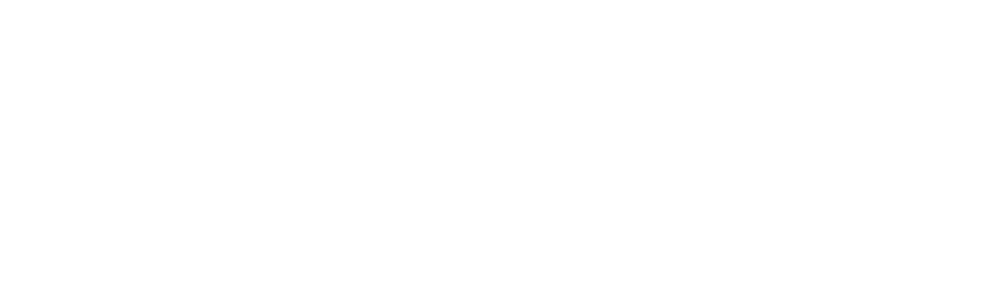

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 53.79886660623583) with caution and run a longer chain!


<IPython.core.display.Javascript object>


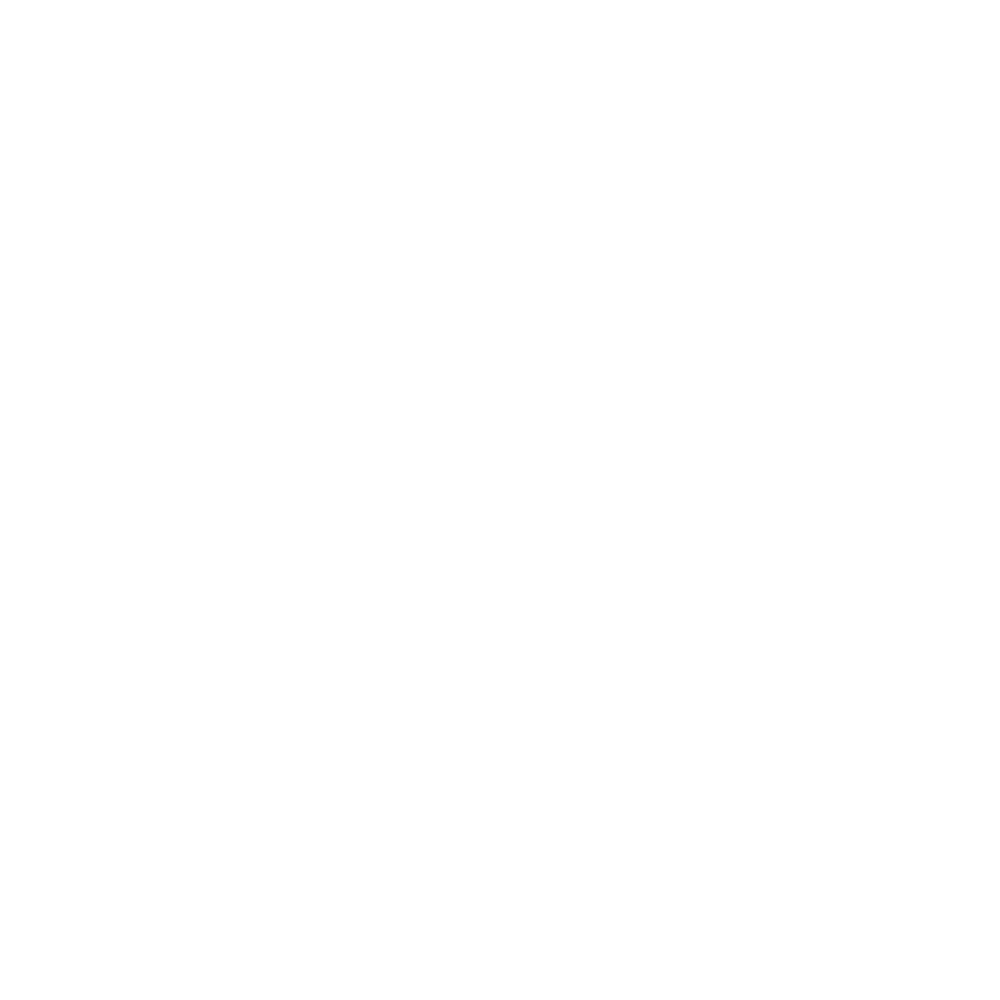

<IPython.core.display.Javascript object>


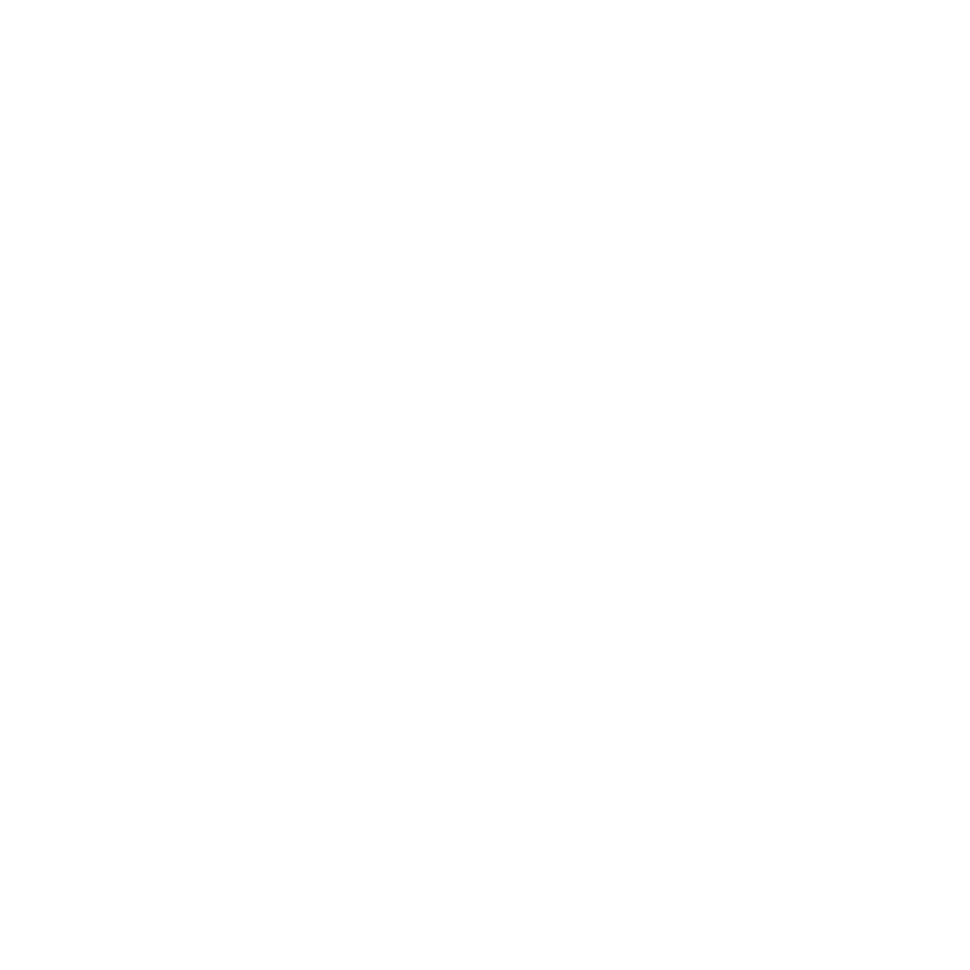

Ref. prior: 1.5631005000000002 au
Fitting SED at 2.324611 au
SED data = [9.19050240e+10 3.77294602e+10 5.43925658e+09]
Per cent error = [10.07673463 10.03106813  5.10689842]
Initial guess = [109.83288942  -2.33070316  -1.07843332   2.82806563]


<IPython.core.display.Javascript object>


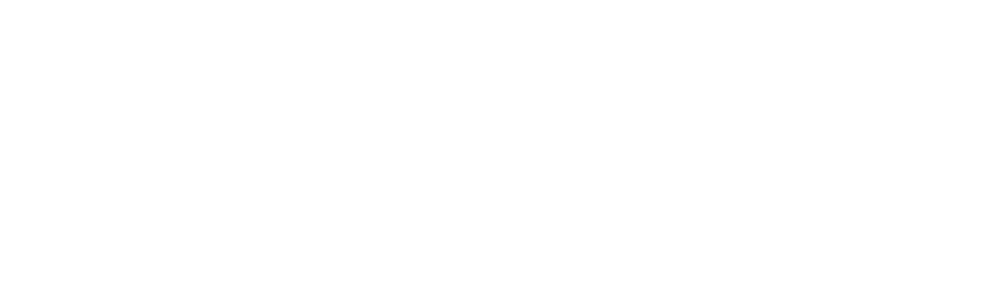

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 32.9486760177339) with caution and run a longer chain!


<IPython.core.display.Javascript object>


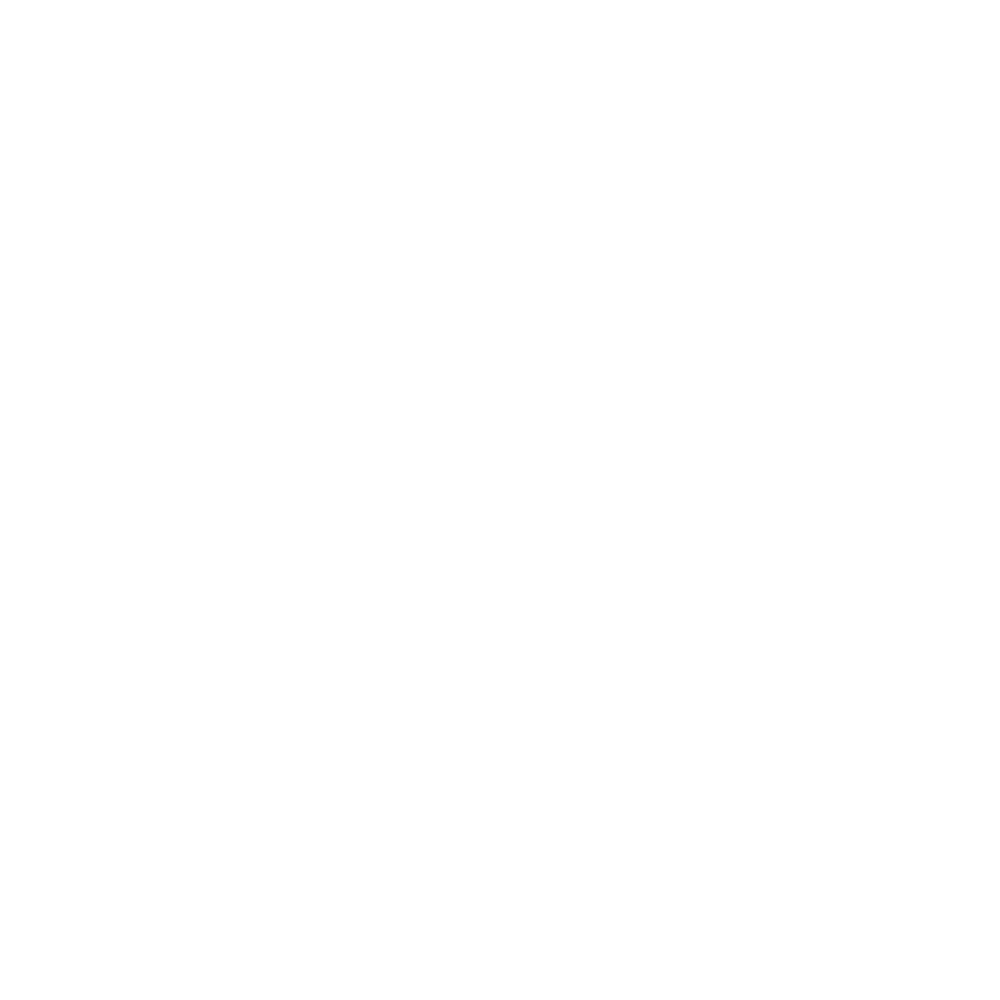

<IPython.core.display.Javascript object>


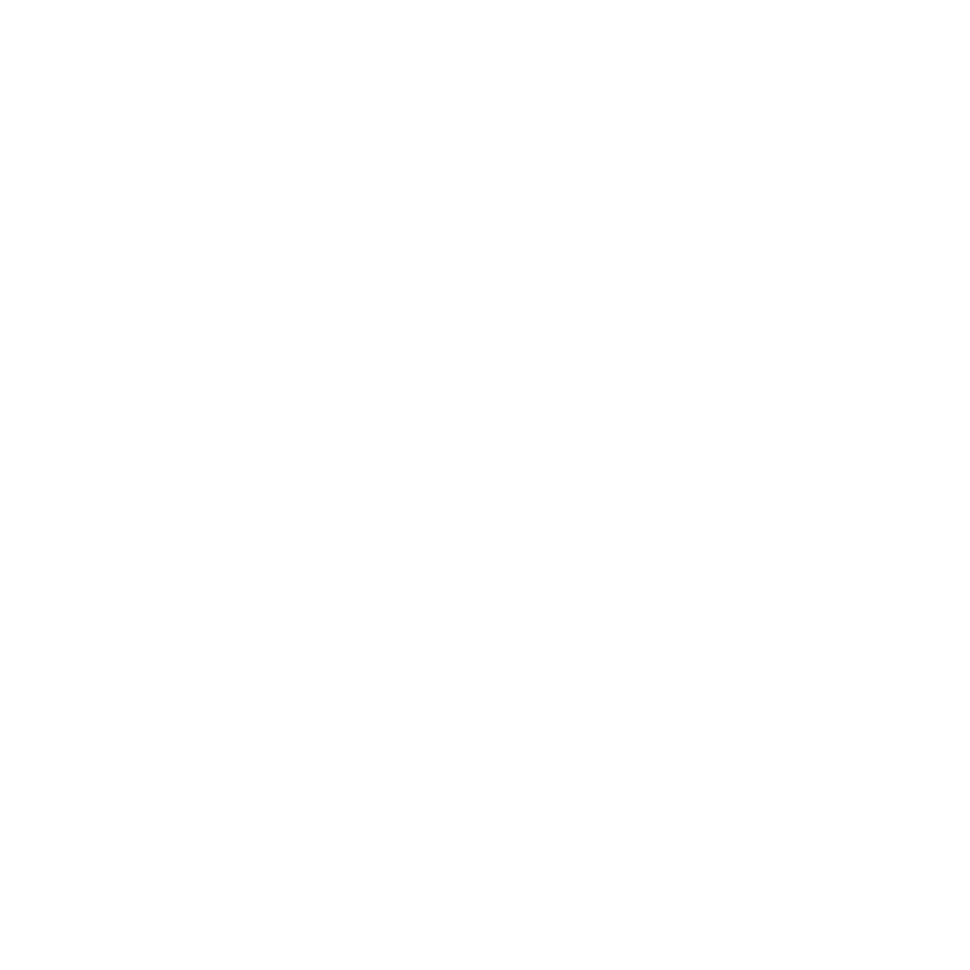

Ref. prior: 4.6893015 au
Fitting SED at 4.1842998 au
SED data = [8.41862595e+10 3.44964588e+10 5.02265190e+09]
Per cent error = [10.31397211 10.22580041  5.29371299]
Initial guess = [62.7740579  -2.06901645 -1.07821491  2.91439449]


<IPython.core.display.Javascript object>


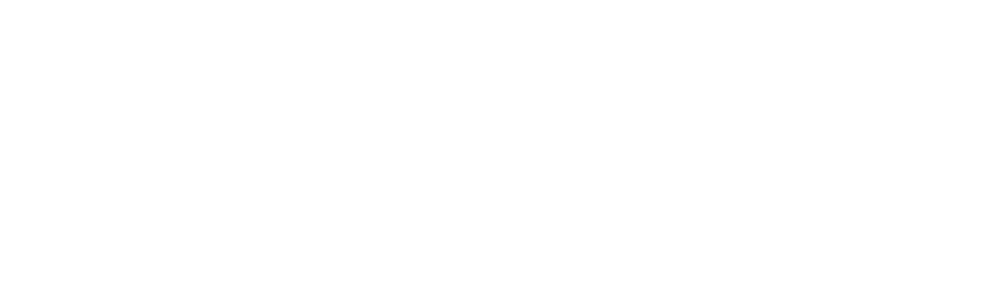

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 26.980578170373537) with caution and run a longer chain!


<IPython.core.display.Javascript object>


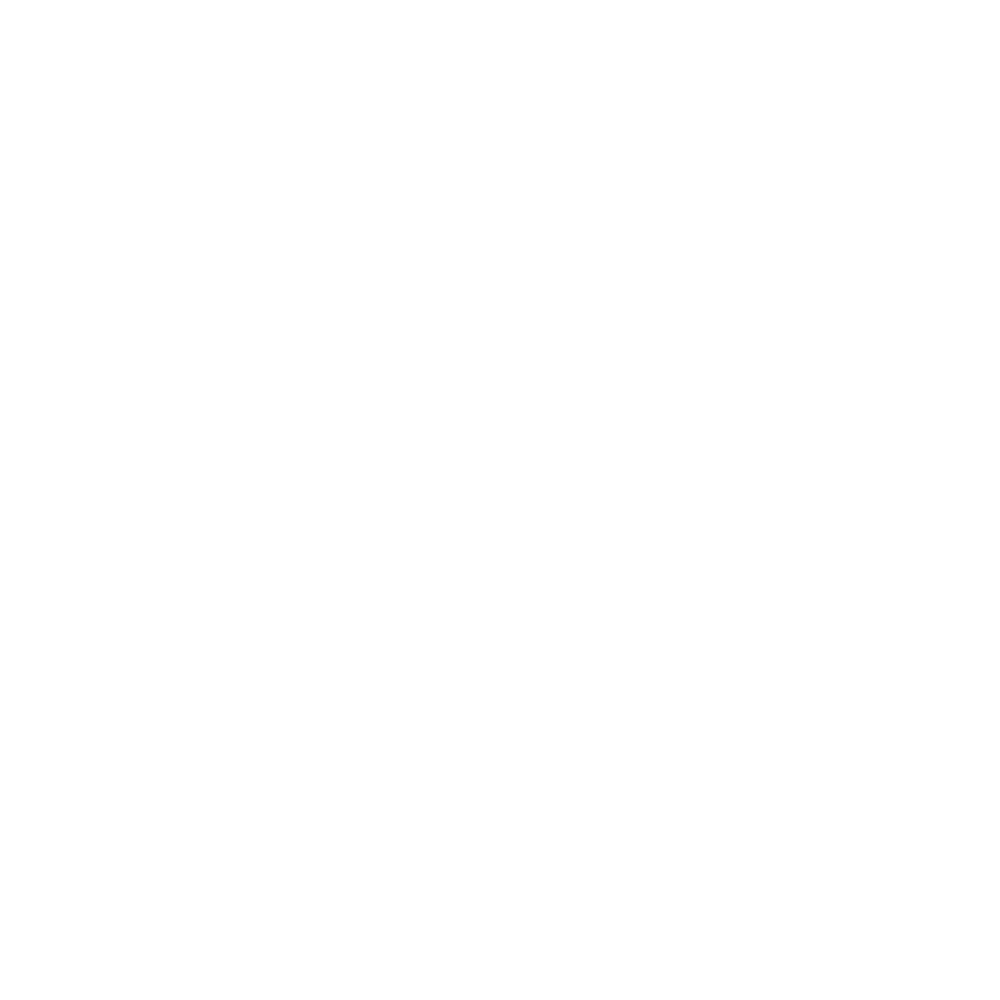

<IPython.core.display.Javascript object>


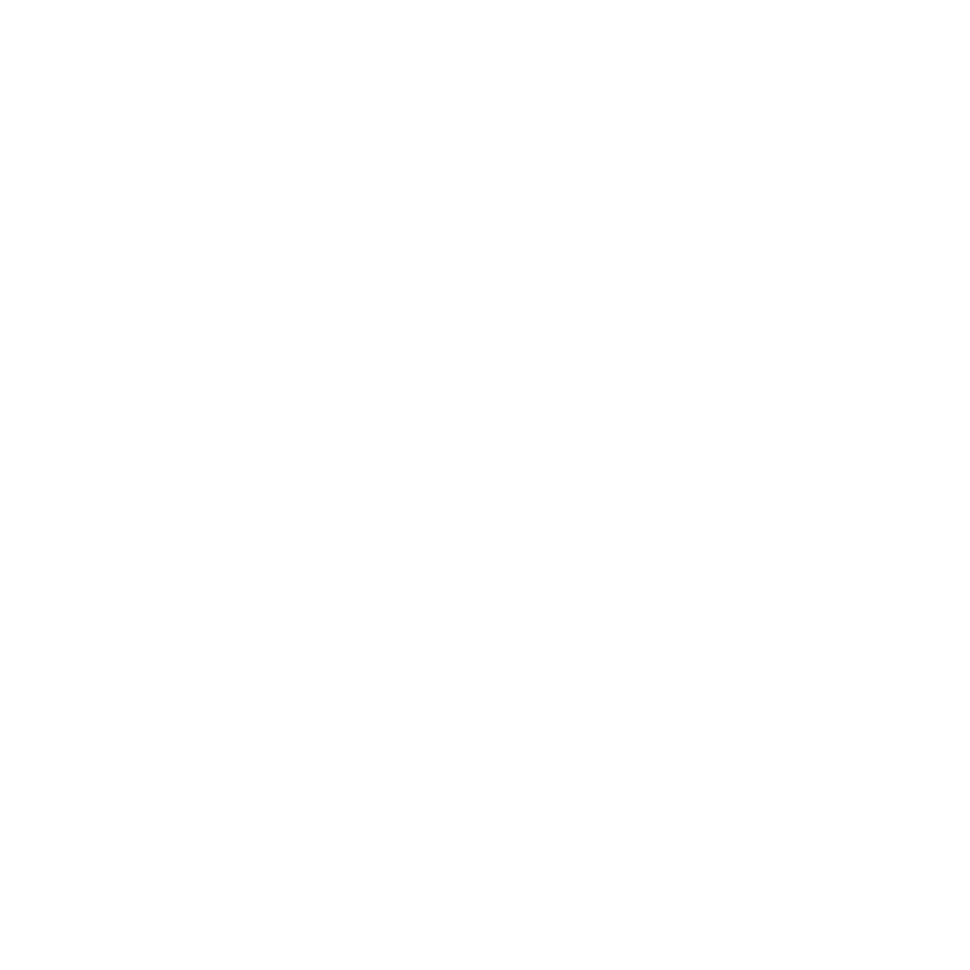

Ref. prior: 4.6893015 au
Fitting SED at 6.0439886 au
SED data = [7.44587264e+10 3.04621445e+10 4.48757555e+09]
Per cent error = [10.81996936 10.70030849  5.74219554]
Initial guess = [62.7740579  -2.06901645 -1.07821491  2.91439449]


<IPython.core.display.Javascript object>


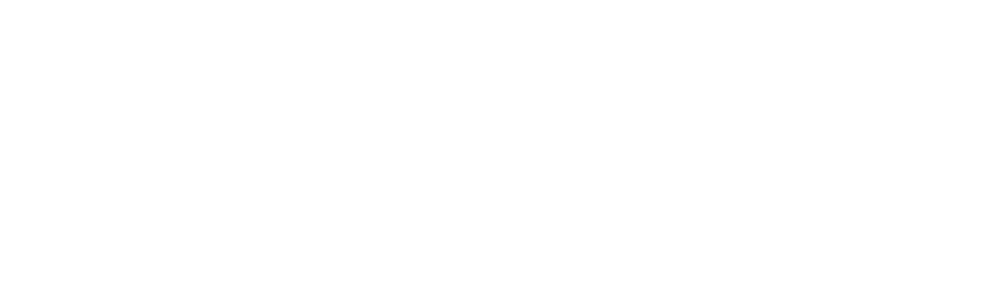

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 27.462590954783597) with caution and run a longer chain!


<IPython.core.display.Javascript object>


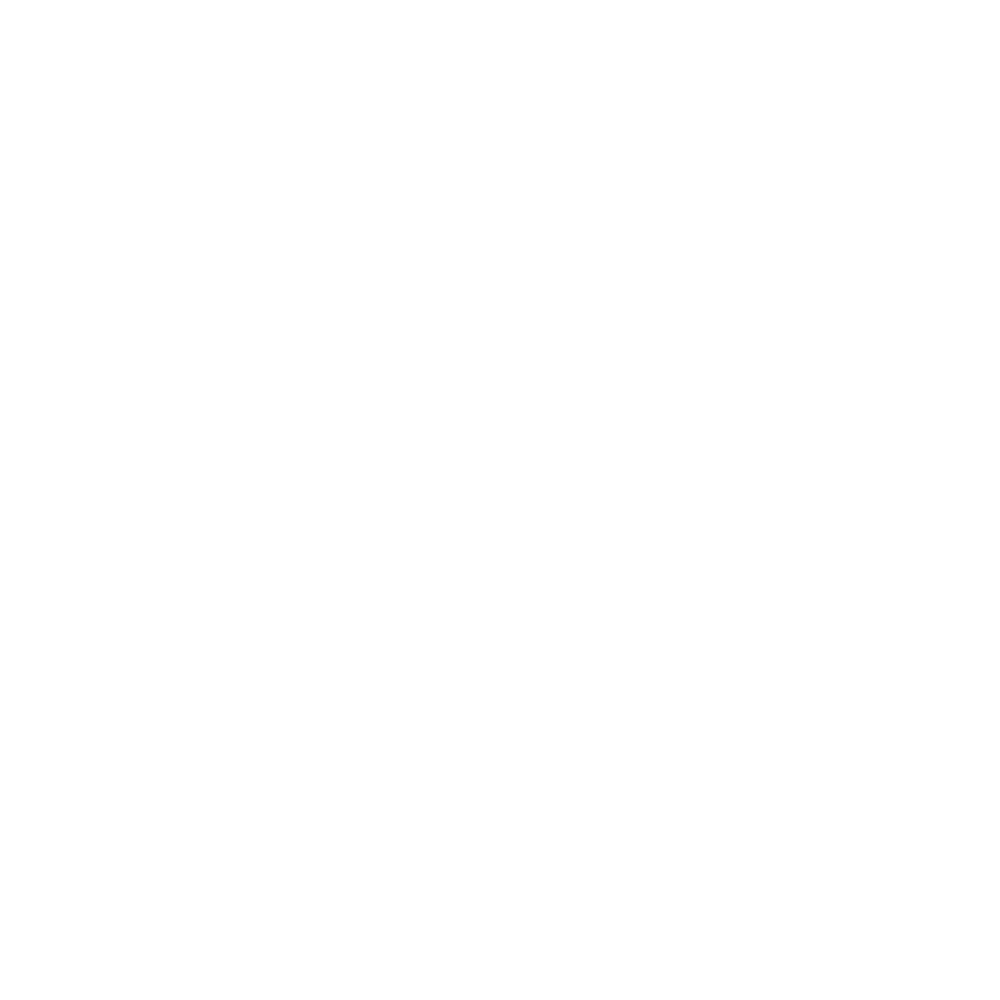

<IPython.core.display.Javascript object>


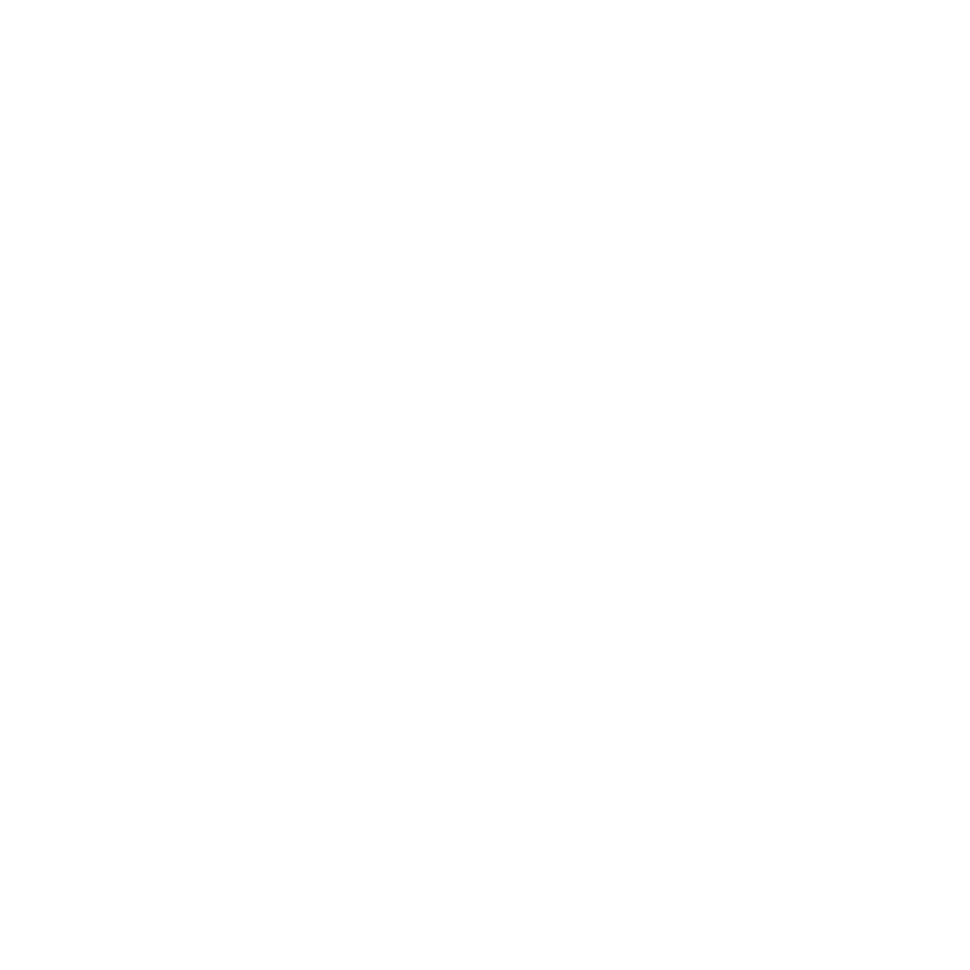

Ref. prior: 7.815502500000001 au
Fitting SED at 7.9036774 au
SED data = [6.17578291e+10 2.51635835e+10 3.75360461e+09]
Per cent error = [11.9456125  11.81794704  6.8848516 ]
Initial guess = [48.35579311 -1.95735728 -1.07858139  3.00015874]


<IPython.core.display.Javascript object>


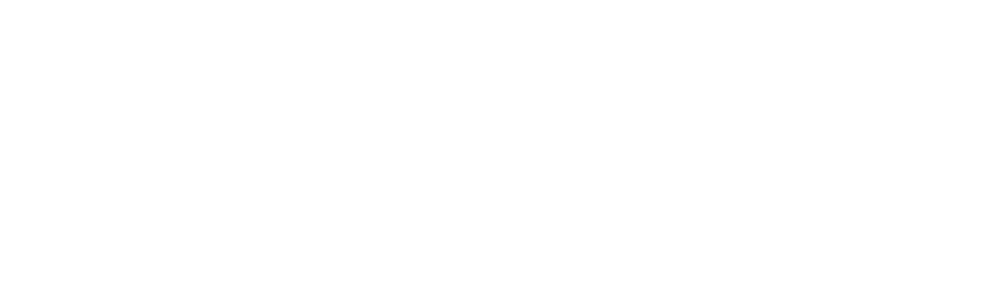

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 24.78786153141935) with caution and run a longer chain!


<IPython.core.display.Javascript object>


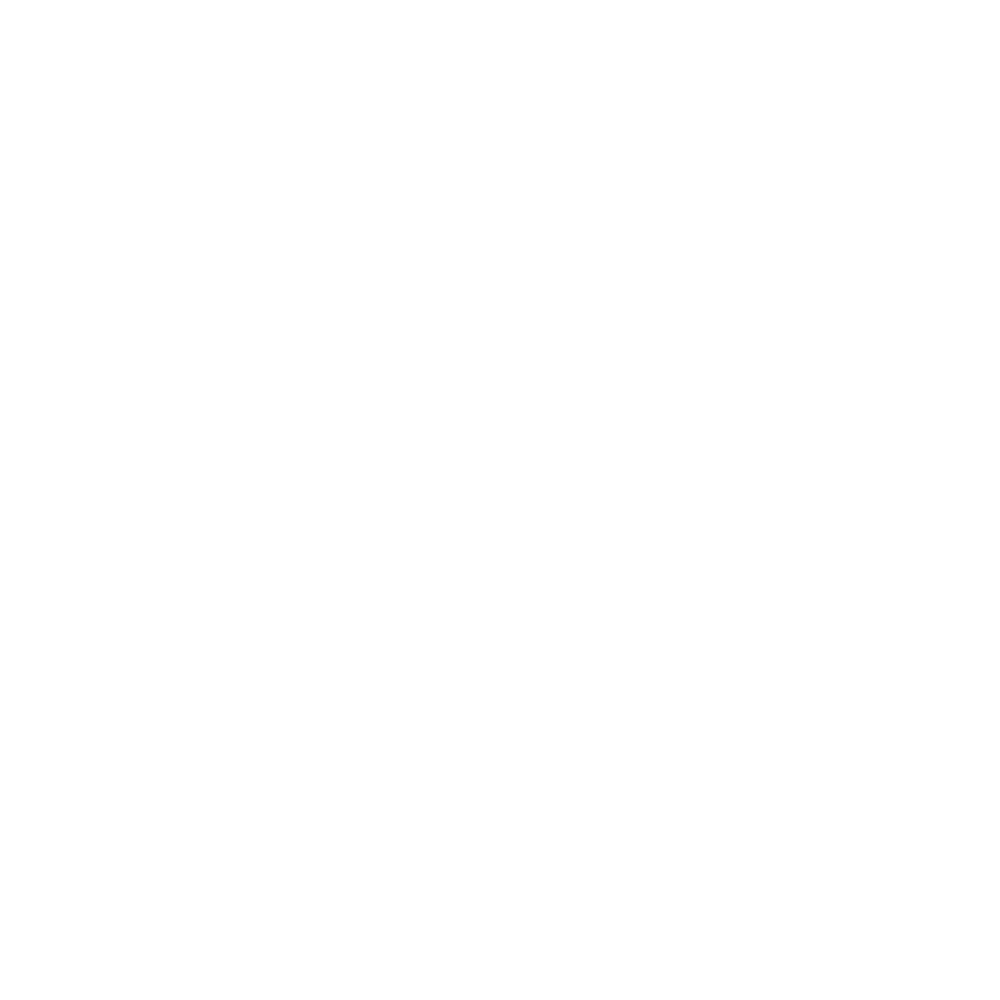

<IPython.core.display.Javascript object>


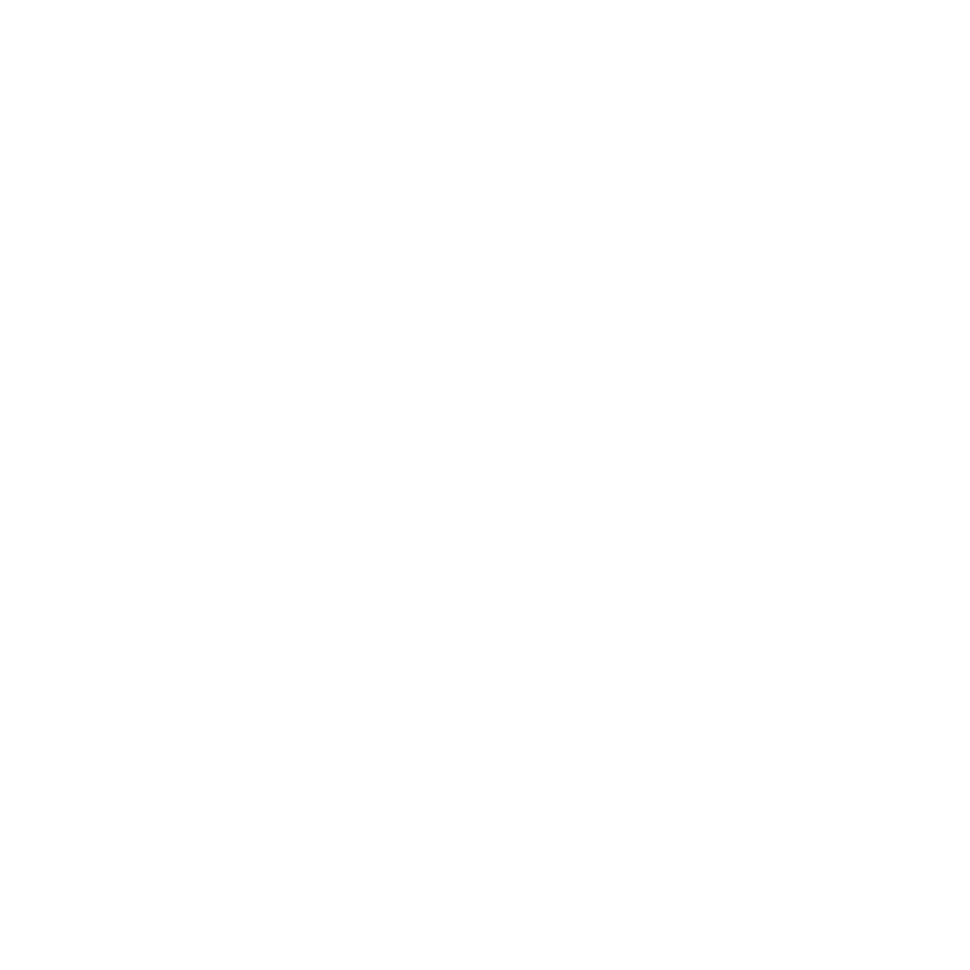

Ref. prior: 10.941703500000001 au
Fitting SED at 9.7633662 au
SED data = [5.17456978e+10 2.08160358e+10 3.13023334e+09]
Per cent error = [12.51835129 12.43358411  7.61249856]
Initial guess = [41.74428968 -1.89561477 -1.079769    3.03466035]


<IPython.core.display.Javascript object>


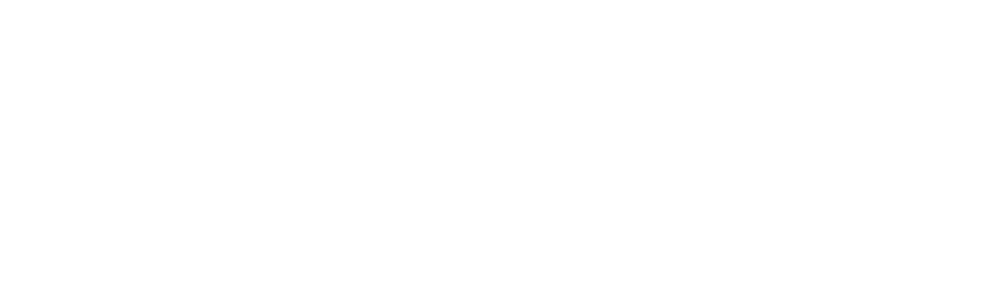

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 26.814925556422114) with caution and run a longer chain!


<IPython.core.display.Javascript object>


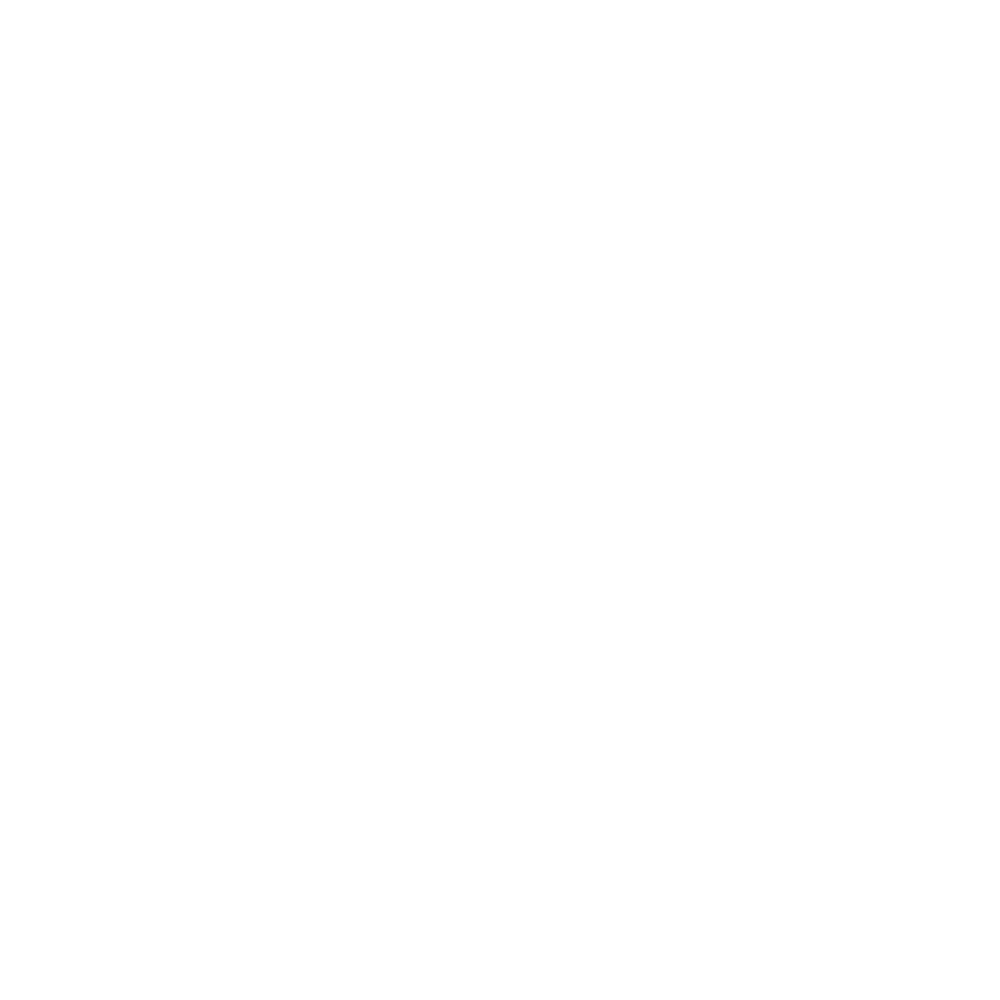

<IPython.core.display.Javascript object>


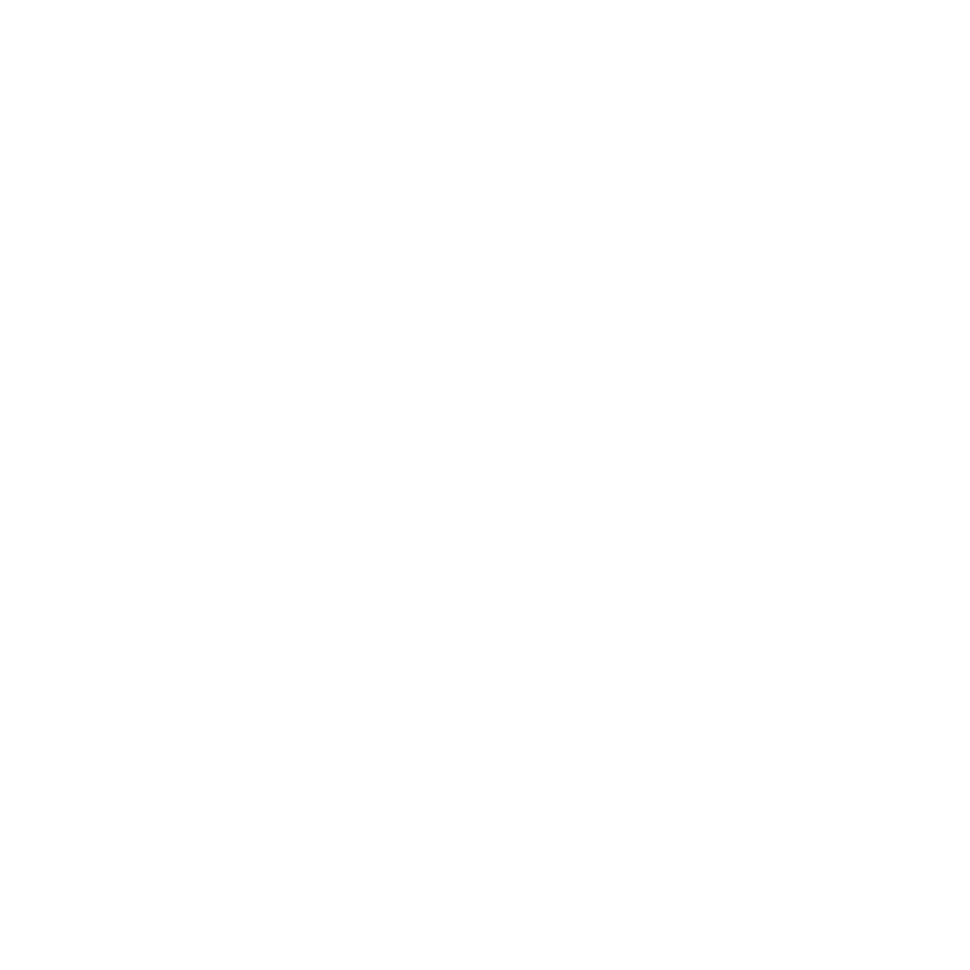

Ref. prior: 10.941703500000001 au
Fitting SED at 11.623055 au
SED data = [4.23468524e+10 1.66710016e+10 2.51118566e+09]
Per cent error = [13.6924564  13.76213015  9.14671633]
Initial guess = [41.74428968 -1.89561477 -1.079769    3.03466035]


<IPython.core.display.Javascript object>


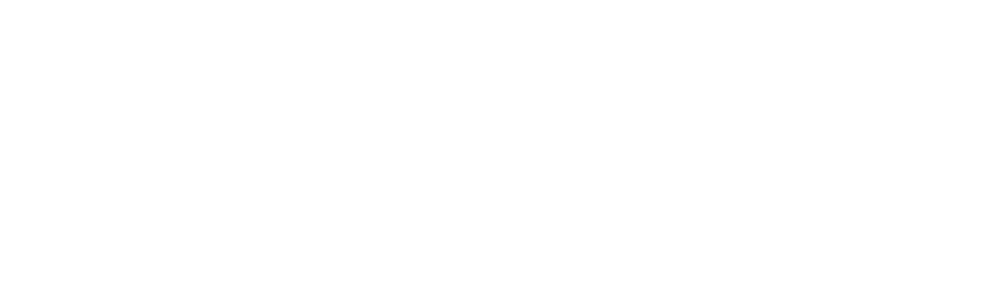

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:51<00:00,  1.71s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 21.91287550505611) with caution and run a longer chain!


<IPython.core.display.Javascript object>


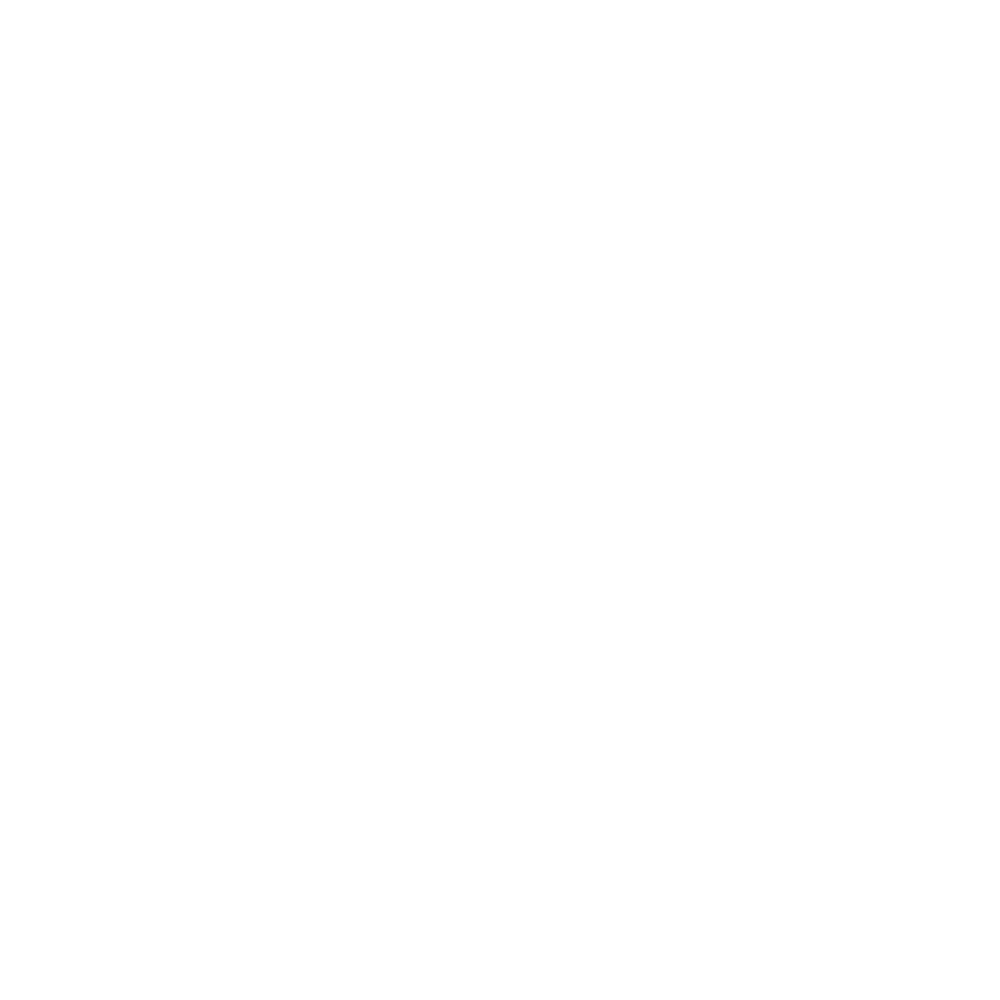

<IPython.core.display.Javascript object>


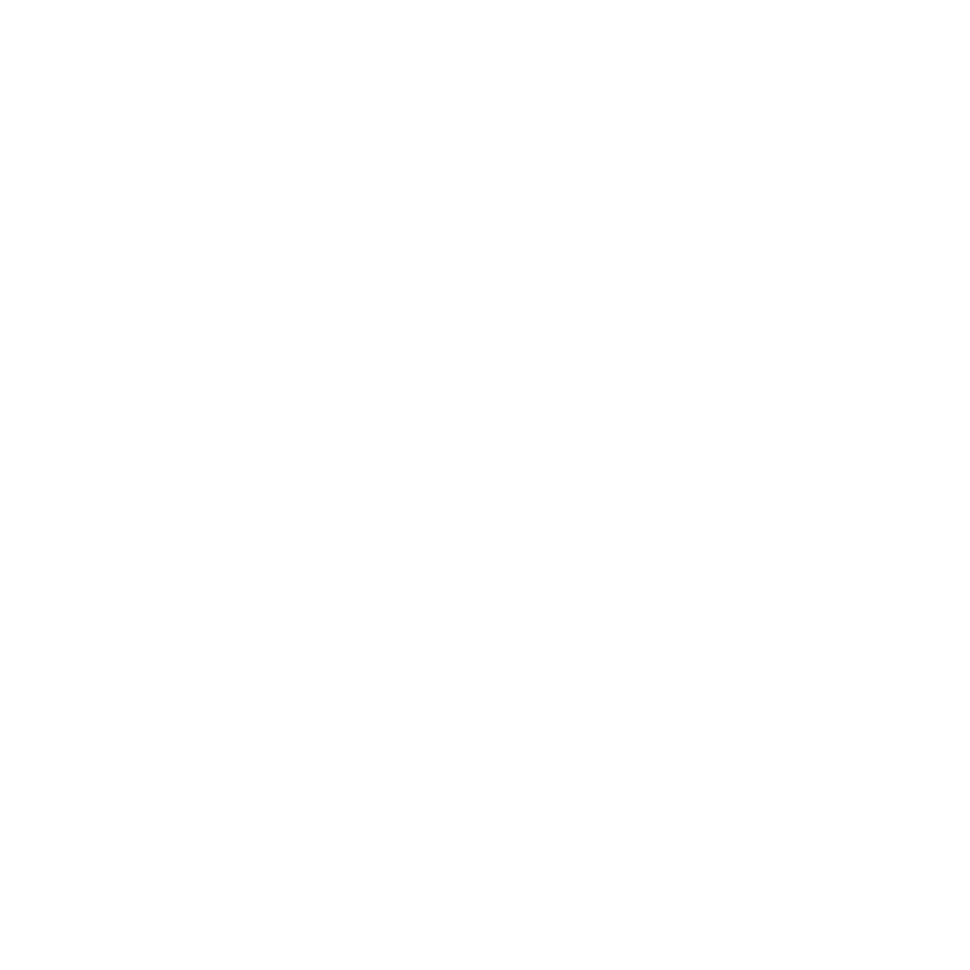

Ref. prior: 14.067904500000001 au
Fitting SED at 13.4827438 au
SED data = [3.40541870e+10 1.29617592e+10 1.95134541e+09]
Per cent error = [14.47155636 14.85953827 10.36885762]
Initial guess = [36.37269886 -1.84629551 -1.08097838  3.10499097]


<IPython.core.display.Javascript object>


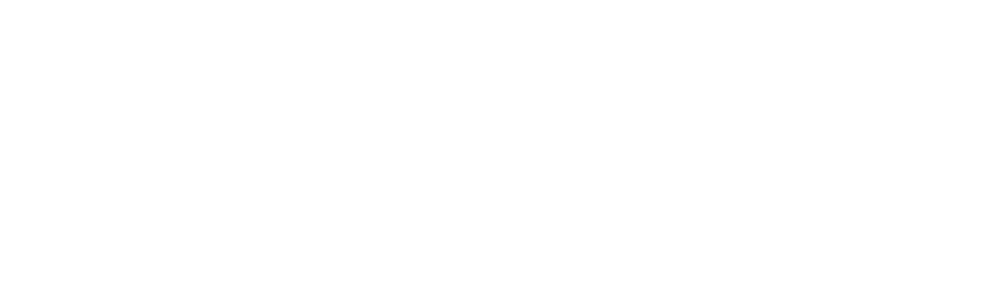

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


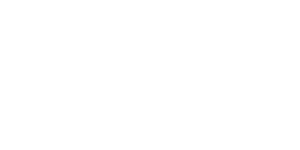

<IPython.core.display.Javascript object>


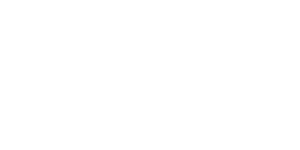

Ref. prior: 14.067904500000001 au
Fitting SED at 15.3424326 au
SED data = [3.03180145e+10 1.11089428e+10 1.64282125e+09]
Per cent error = [13.56755952 14.19229613 10.03072842]
Initial guess = [36.37269886 -1.84629551 -1.08097838  3.10499097]


<IPython.core.display.Javascript object>


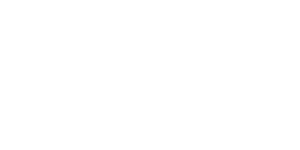

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


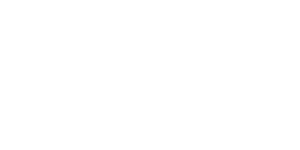

<IPython.core.display.Javascript object>


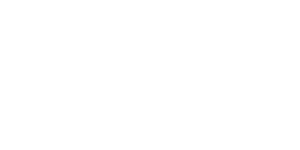

Ref. prior: 17.194105500000003 au
Fitting SED at 17.2021214 au
SED data = [2.79478231e+10 9.95783270e+09 1.42529869e+09]
Per cent error = [12.68907821 13.38283567  9.47113571]
Initial guess = [31.50873206 -1.78502871 -1.08260683  3.15545949]


<IPython.core.display.Javascript object>


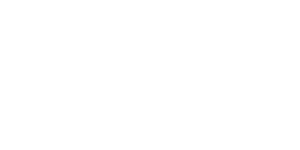

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


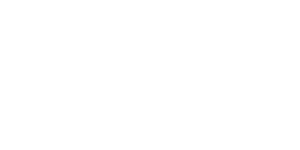

<IPython.core.display.Javascript object>


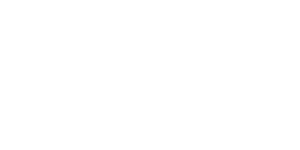

Ref. prior: 20.3203065 au
Fitting SED at 19.0618102 au
SED data = [2.73470403e+10 9.68443699e+09 1.33328845e+09]
Per cent error = [11.53822169 11.98215479  8.00406226]
Initial guess = [30.83579854 -1.80544858 -1.0828054   3.20191988]


<IPython.core.display.Javascript object>


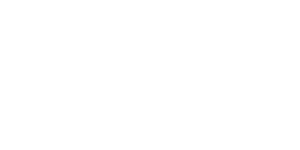

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


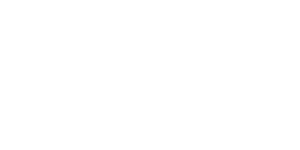

<IPython.core.display.Javascript object>


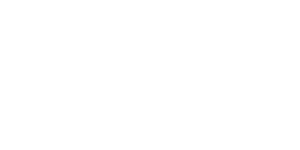

Ref. prior: 20.3203065 au
Fitting SED at 20.921499 au
SED data = [2.72326676e+10 9.70865357e+09 1.28568794e+09]
Per cent error = [10.69386375 10.83671442  6.52903922]
Initial guess = [30.83579854 -1.80544858 -1.0828054   3.20191988]


<IPython.core.display.Javascript object>


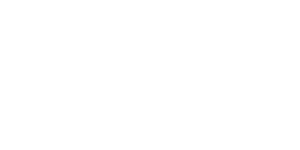

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


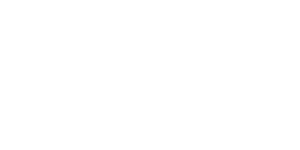

<IPython.core.display.Javascript object>


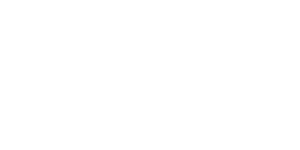

Ref. prior: 23.4465075 au
Fitting SED at 22.7811878 au
SED data = [2.76019732e+10 1.00274616e+10 1.29568614e+09]
Per cent error = [10.33172114 10.36332518  5.75332431]
Initial guess = [28.78489567 -1.8066303  -1.08458653  3.23152379]


<IPython.core.display.Javascript object>


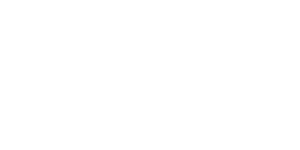

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


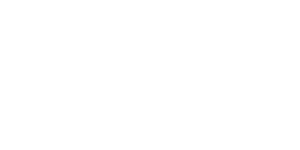

<IPython.core.display.Javascript object>


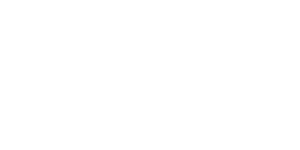

Ref. prior: 23.4465075 au
Fitting SED at 24.640876600000002 au
SED data = [2.77002650e+10 1.02565284e+10 1.31195008e+09]
Per cent error = [10.16801434 10.17487741  5.41019167]
Initial guess = [28.78489567 -1.8066303  -1.08458653  3.23152379]


<IPython.core.display.Javascript object>


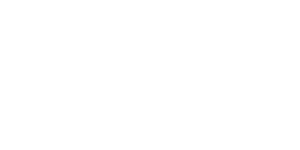

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


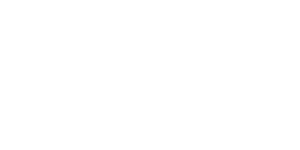

<IPython.core.display.Javascript object>


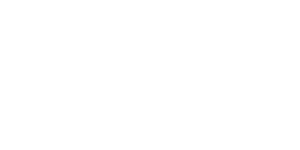

Ref. prior: 26.572708500000005 au
Fitting SED at 26.500565400000003 au
SED data = [2.75599606e+10 1.03635804e+10 1.31544166e+09]
Per cent error = [10.08714436 10.08397988  5.39106397]
Initial guess = [27.17181383 -1.80663718 -1.08608771  3.27180865]


<IPython.core.display.Javascript object>


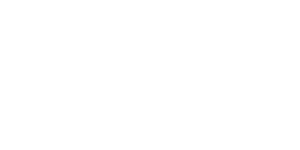

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


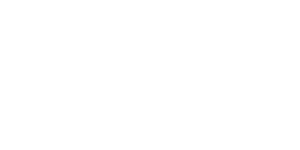

<IPython.core.display.Javascript object>


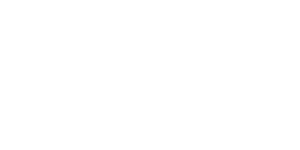

Ref. prior: 29.698909500000003 au
Fitting SED at 28.360254200000004 au
SED data = [2.69236326e+10 1.02492088e+10 1.30863450e+09]
Per cent error = [10.06266115 10.05530215  5.43531242]
Initial guess = [26.14211848 -1.80562658 -1.08894329  3.29789497]


<IPython.core.display.Javascript object>


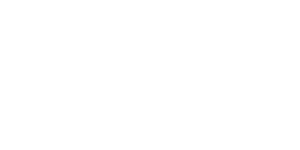

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


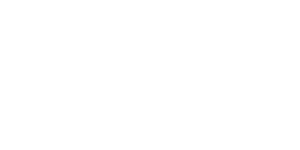

<IPython.core.display.Javascript object>


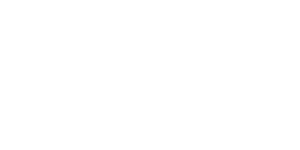

Ref. prior: 29.698909500000003 au
Fitting SED at 30.219943 au
SED data = [2.60588831e+10 1.00344822e+10 1.28321485e+09]
Per cent error = [10.03851617 10.03365555  5.47938745]
Initial guess = [26.14211848 -1.80562658 -1.08894329  3.29789497]


<IPython.core.display.Javascript object>


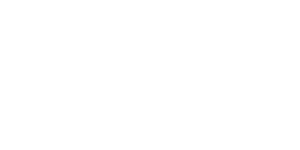

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


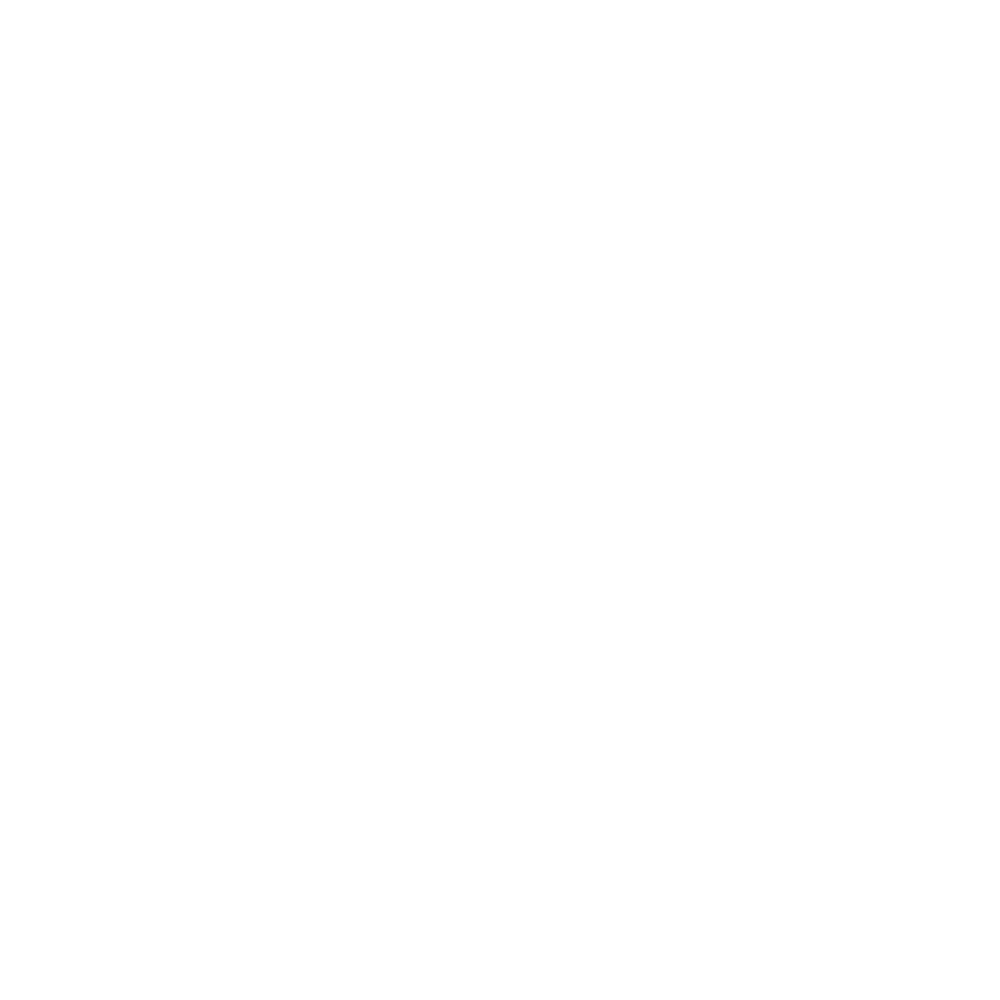

<IPython.core.display.Javascript object>


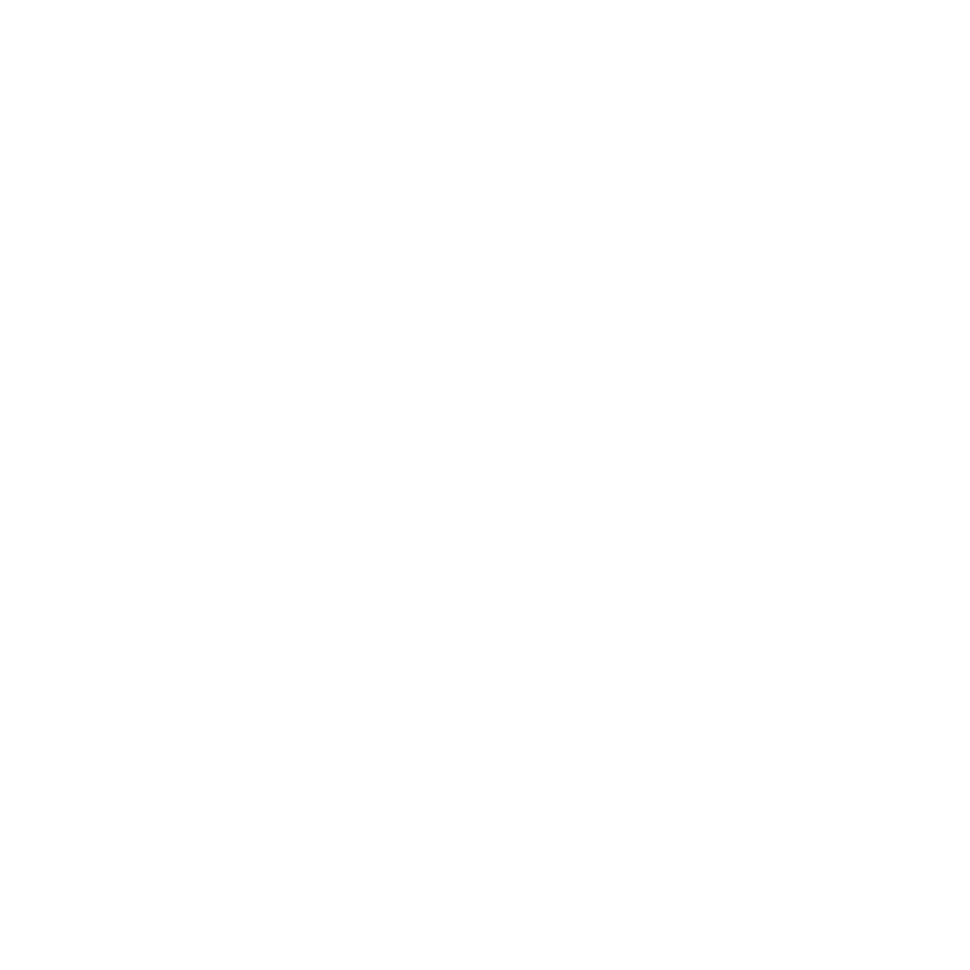

Ref. prior: 32.8251105 au
Fitting SED at 32.0796318 au
SED data = [2.50819359e+10 9.66539981e+09 1.22294323e+09]
Per cent error = [10.02475804 10.02198698  5.46610831]
Initial guess = [24.72472667 -1.81659212 -1.09266799  3.31836827]


<IPython.core.display.Javascript object>


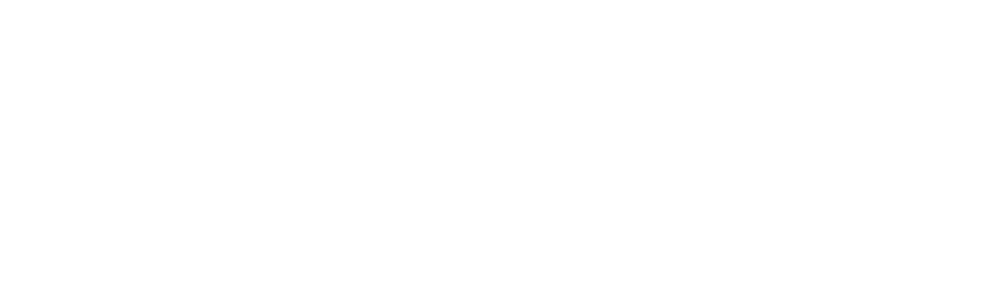

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


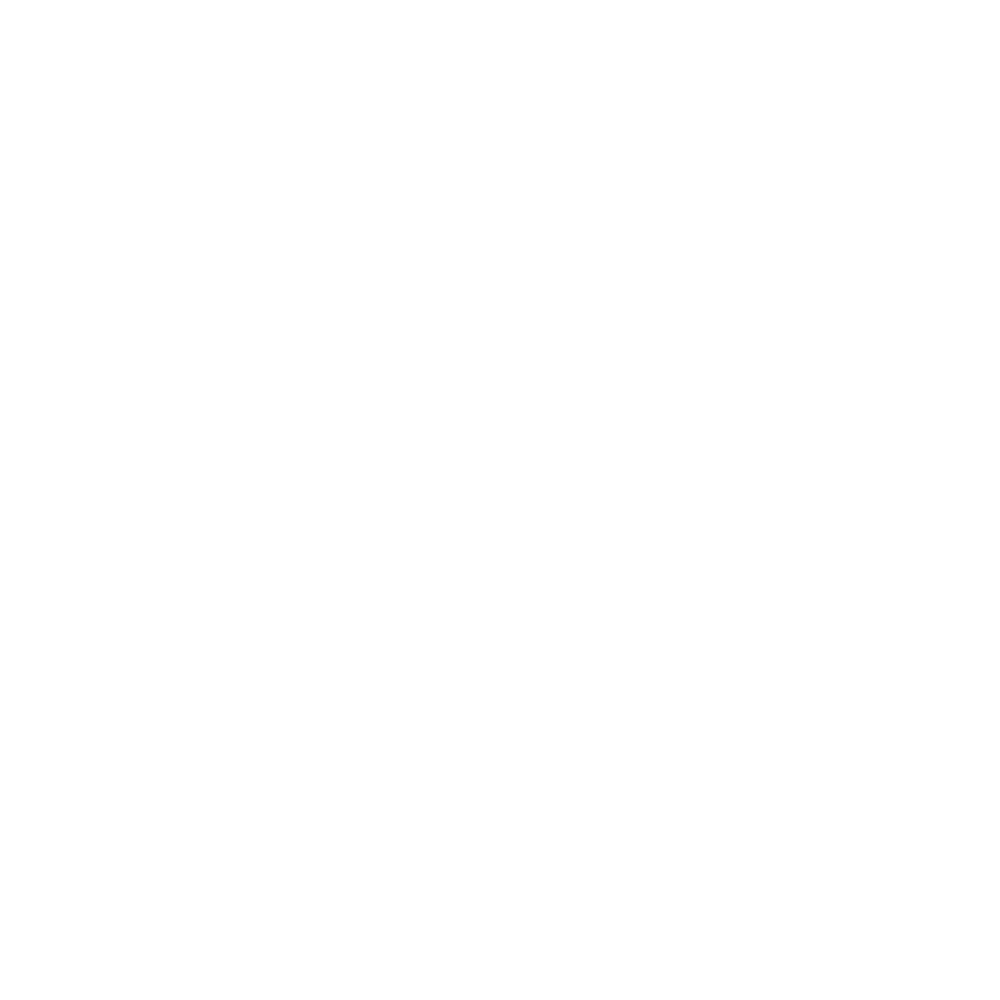

<IPython.core.display.Javascript object>


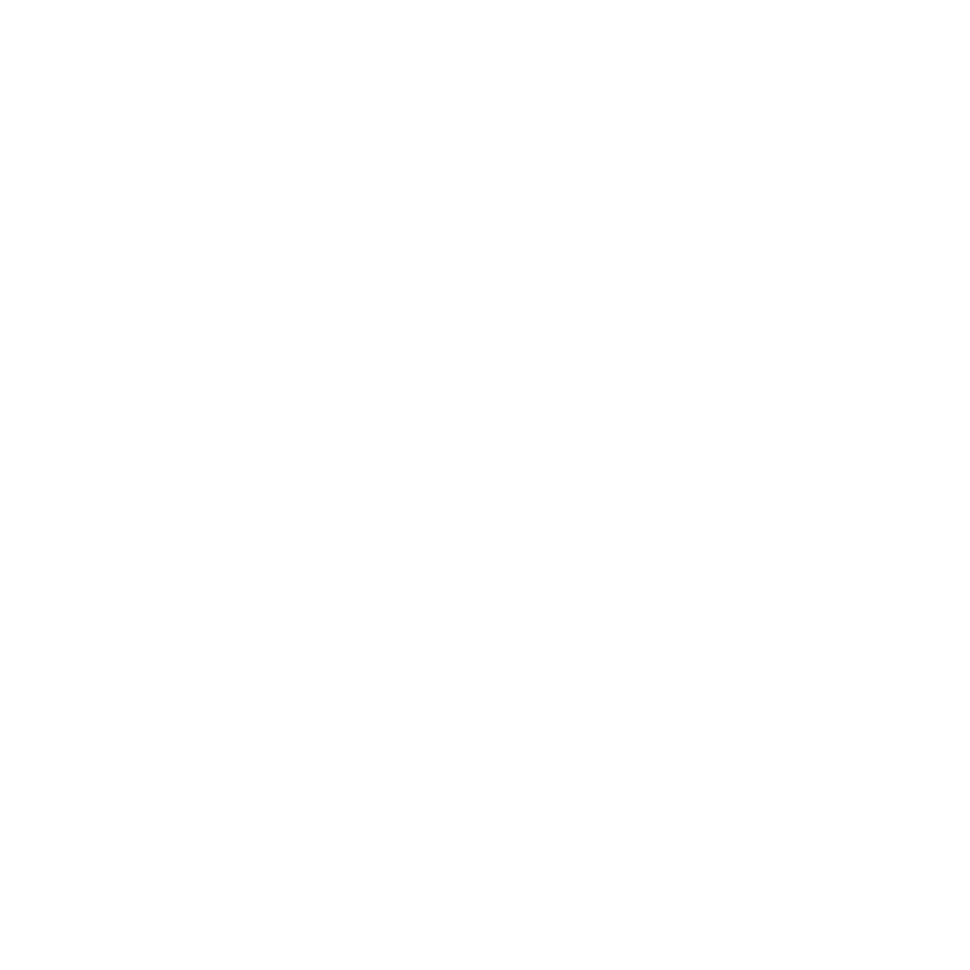

Ref. prior: 32.8251105 au
Fitting SED at 33.9393206 au
SED data = [2.38838108e+10 9.15922330e+09 1.14477939e+09]
Per cent error = [10.0212955  10.01736745  5.48506835]
Initial guess = [24.72472667 -1.81659212 -1.09266799  3.31836827]


<IPython.core.display.Javascript object>


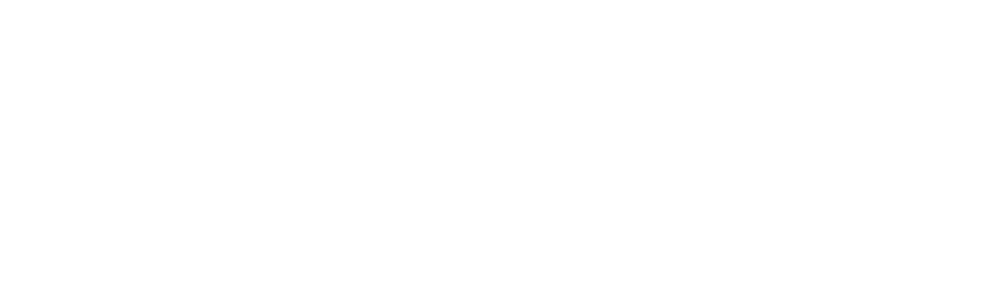

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


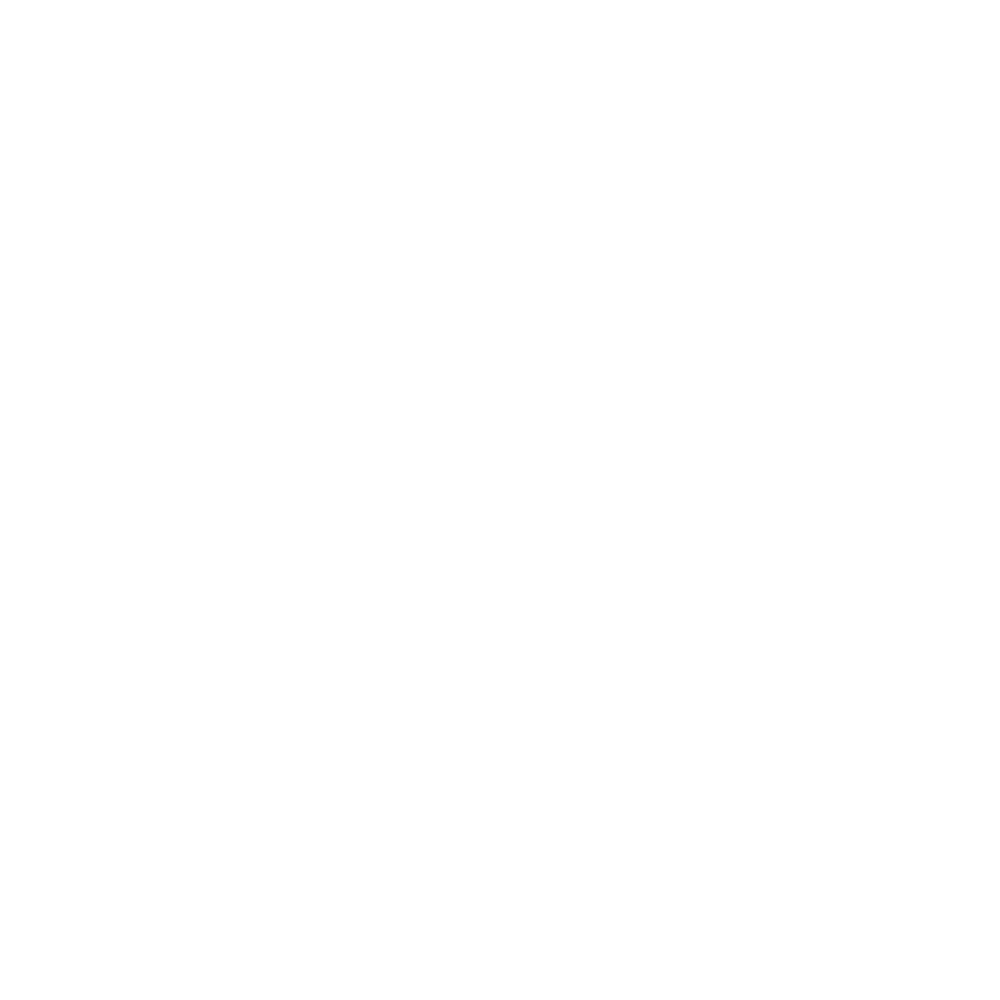

<IPython.core.display.Javascript object>


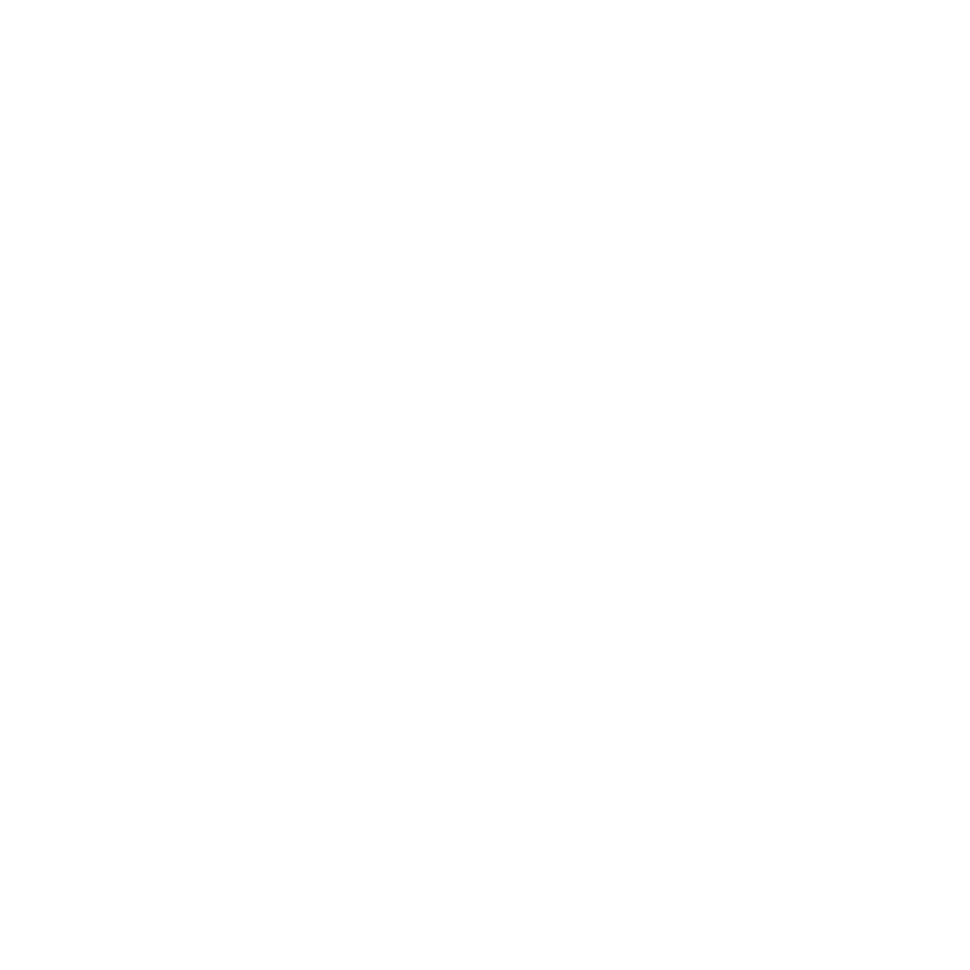

Ref. prior: 35.9513115 au
Fitting SED at 35.7990094 au
SED data = [2.25474683e+10 8.56557773e+09 1.05057856e+09]
Per cent error = [10.01977479 10.01447815  5.43268198]
Initial guess = [23.72168772 -1.82802242 -1.09432015  3.34756799]


<IPython.core.display.Javascript object>


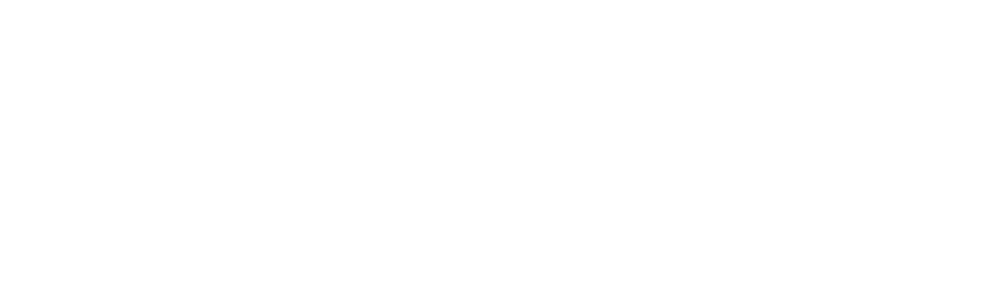

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


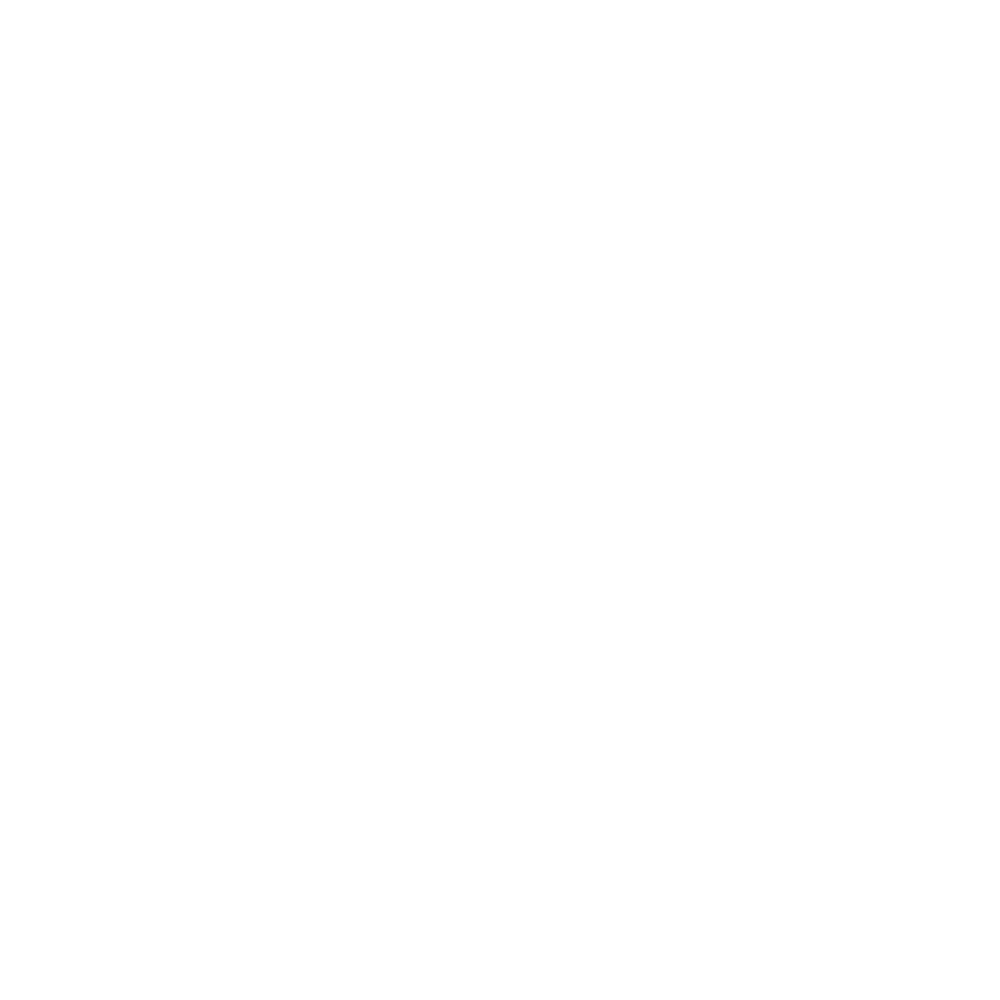

<IPython.core.display.Javascript object>


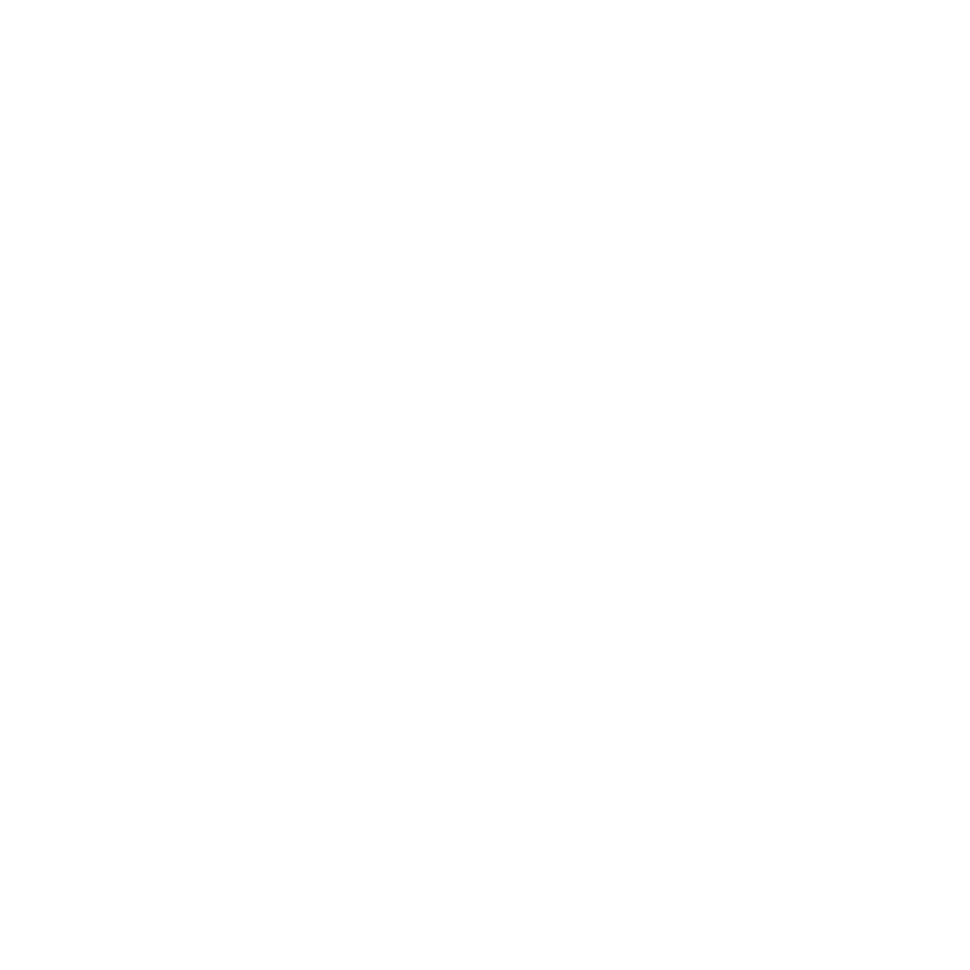

Ref. prior: 39.077512500000005 au
Fitting SED at 37.6586982 au
SED data = [2.11531960e+10 7.94259405e+09 9.48294208e+08]
Per cent error = [10.02279055 10.01344398  5.3878976 ]
Initial guess = [22.84534697 -1.83549868 -1.09919743  3.37256773]


<IPython.core.display.Javascript object>


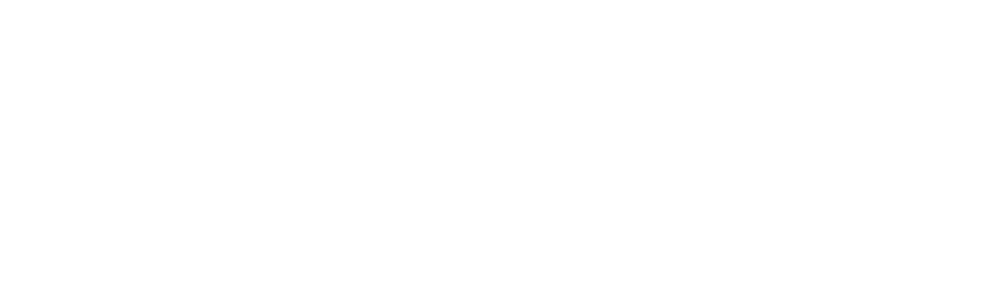

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


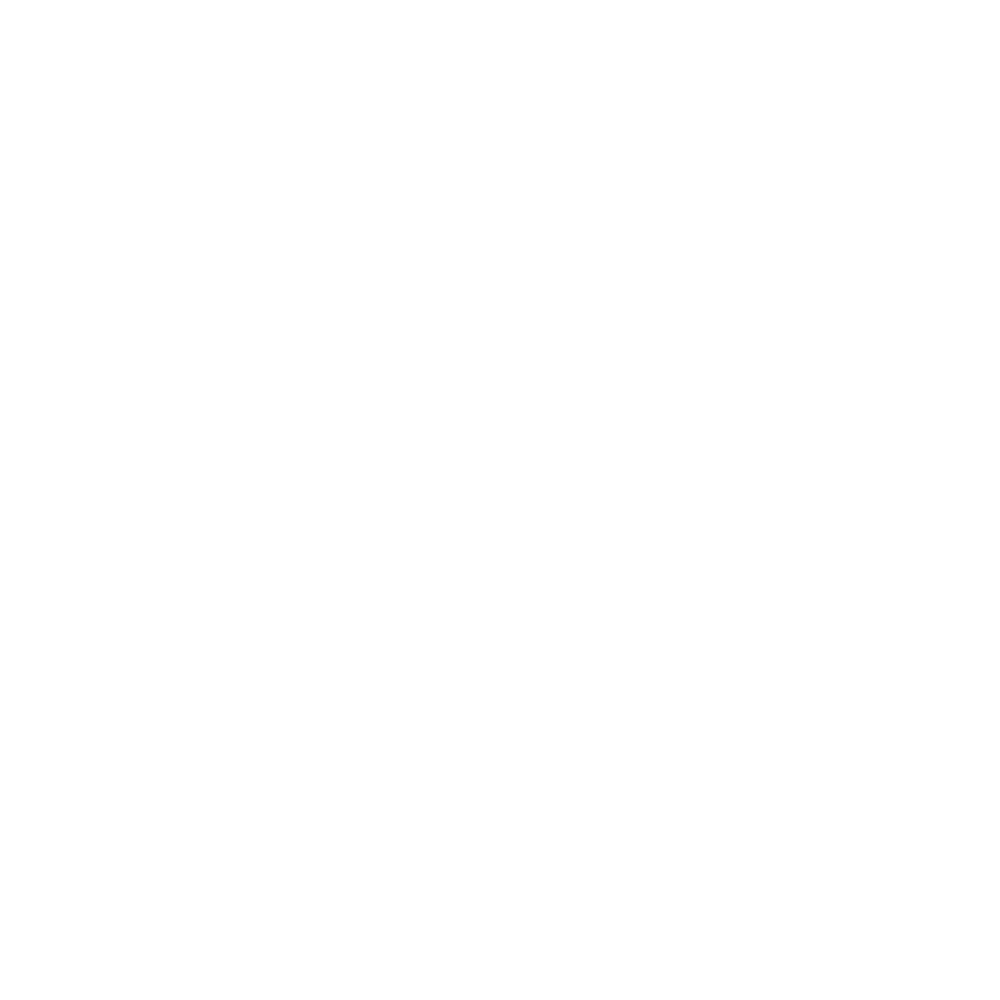

<IPython.core.display.Javascript object>


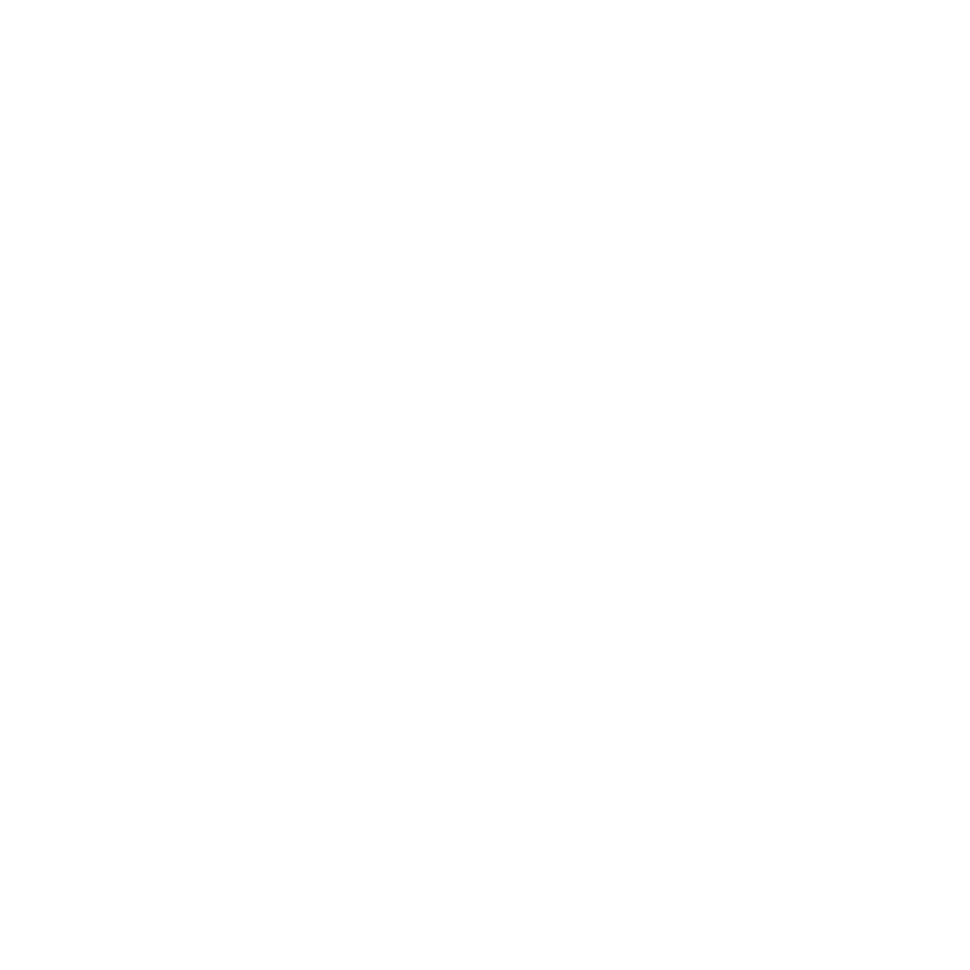

Ref. prior: 39.077512500000005 au
Fitting SED at 39.518387000000004 au
SED data = [1.97373297e+10 7.30508032e+09 8.59594304e+08]
Per cent error = [10.02769367 10.01590699  5.35178794]
Initial guess = [22.84534697 -1.83549868 -1.09919743  3.37256773]


<IPython.core.display.Javascript object>


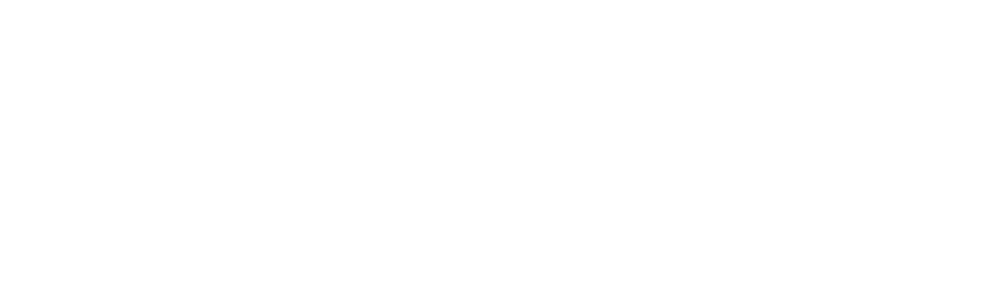

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


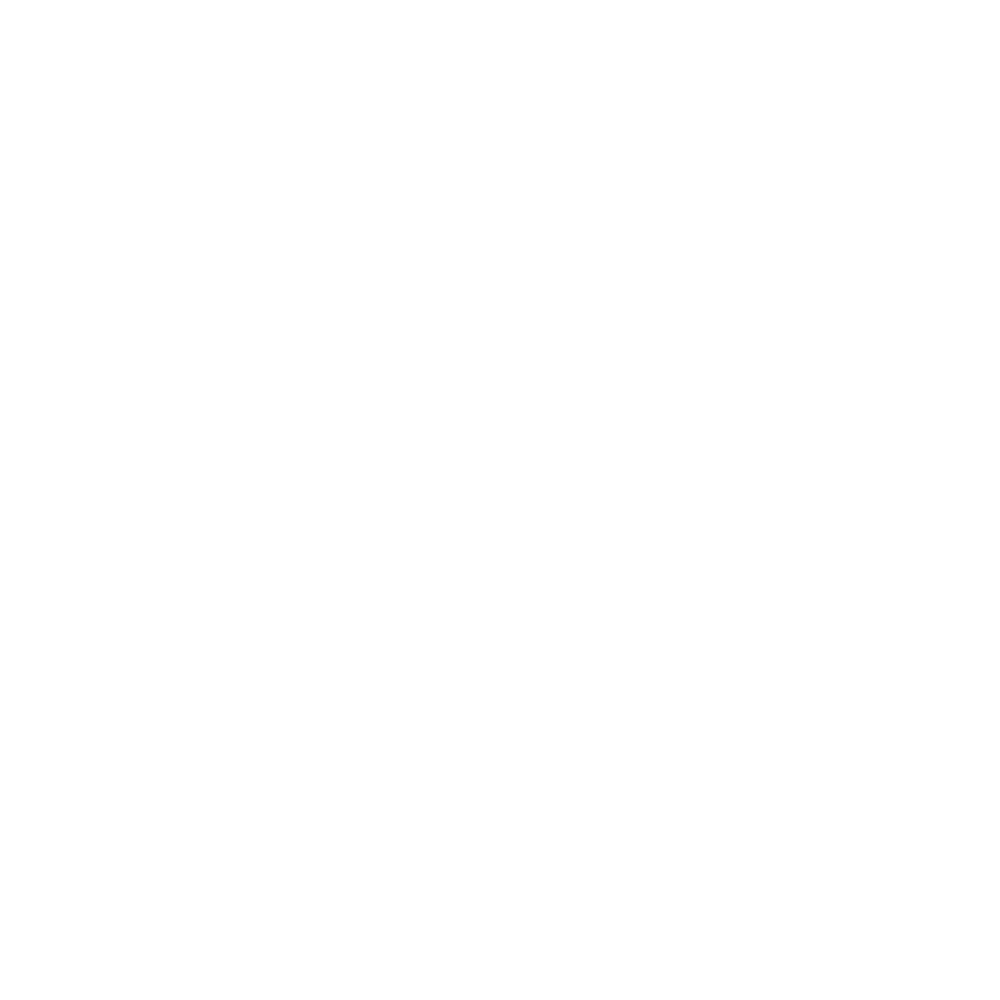

<IPython.core.display.Javascript object>


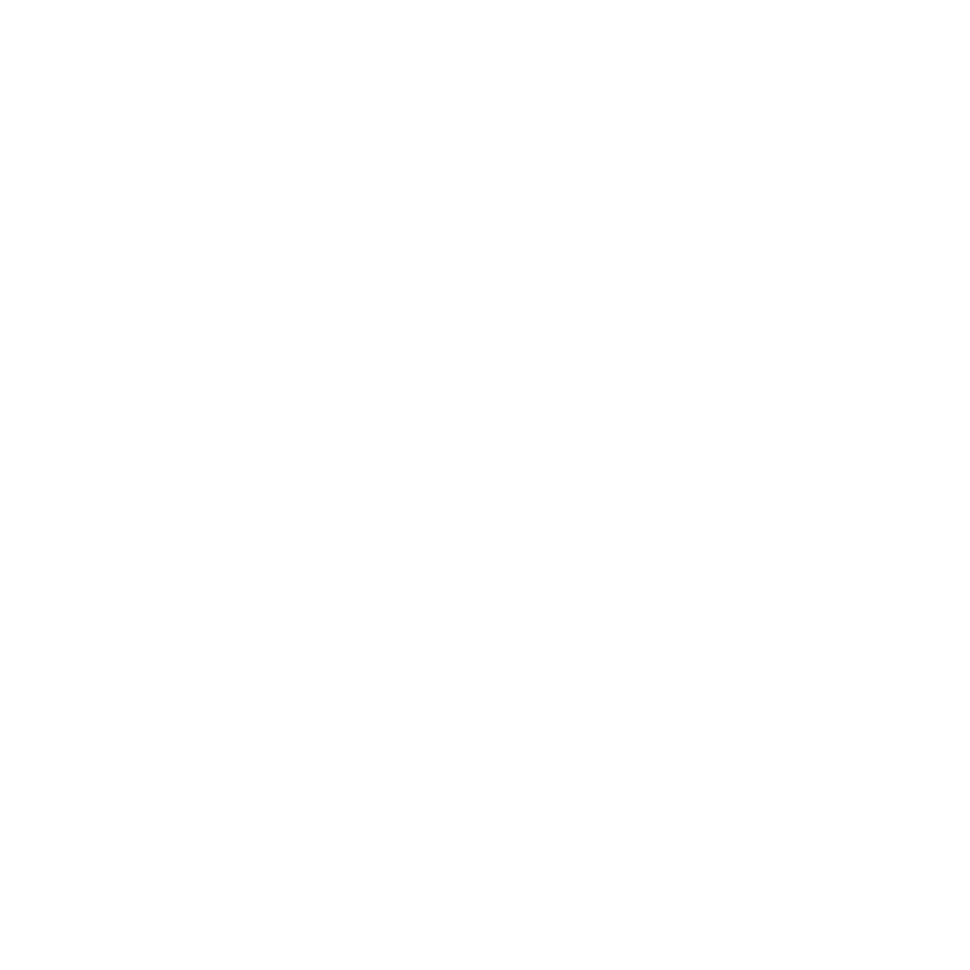

Ref. prior: 42.2037135 au
Fitting SED at 41.378075800000005 au
SED data = [1.83354429e+10 6.66894285e+09 7.69704576e+08]
Per cent error = [10.0365509  10.02361584  5.41815337]
Initial guess = [21.65139496 -1.83096571 -1.10321168  3.41694528]


<IPython.core.display.Javascript object>


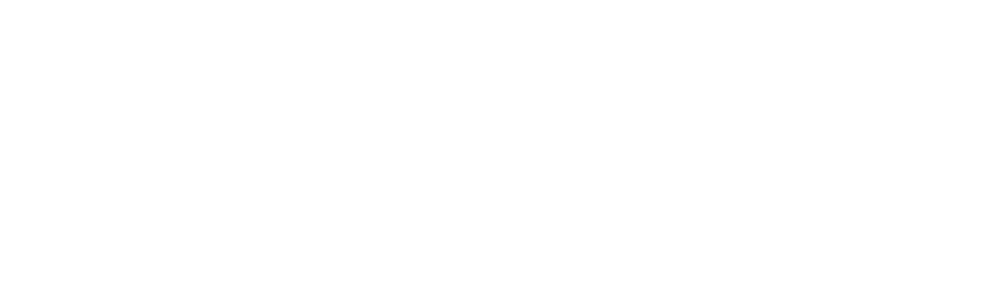

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


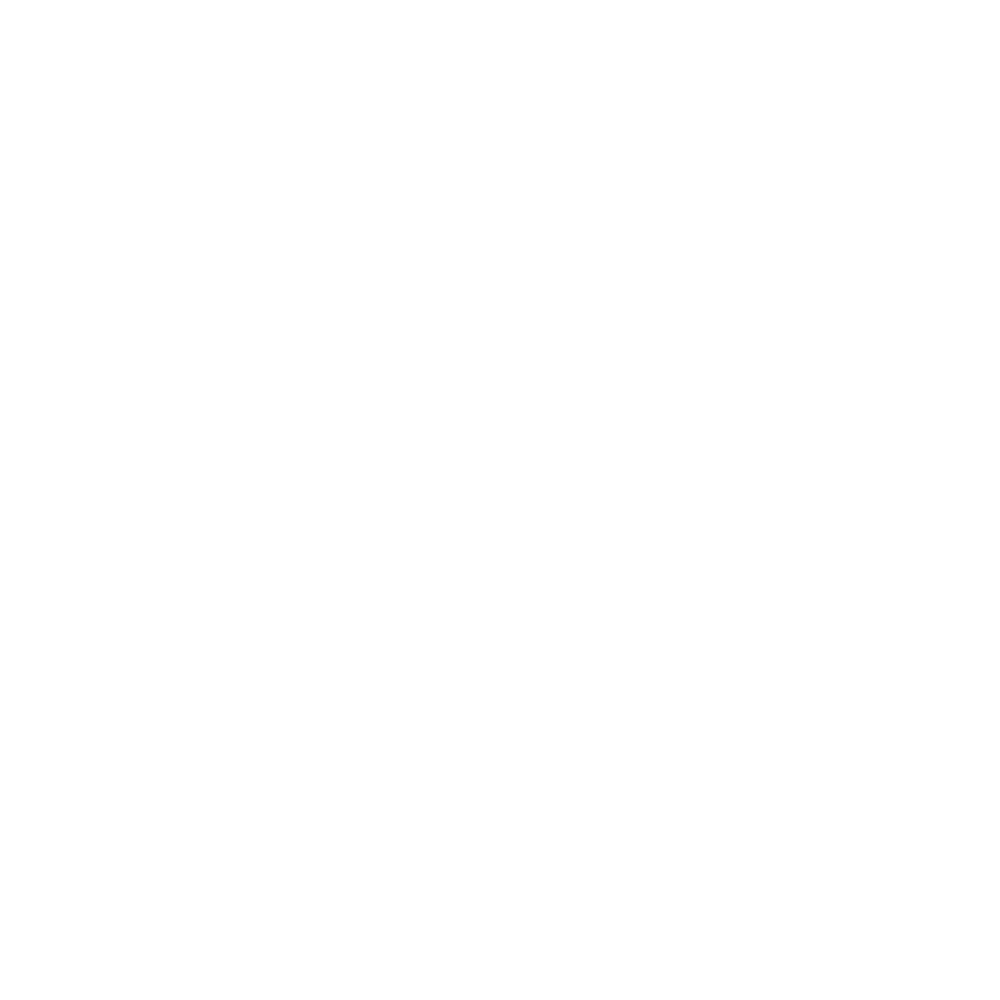

<IPython.core.display.Javascript object>


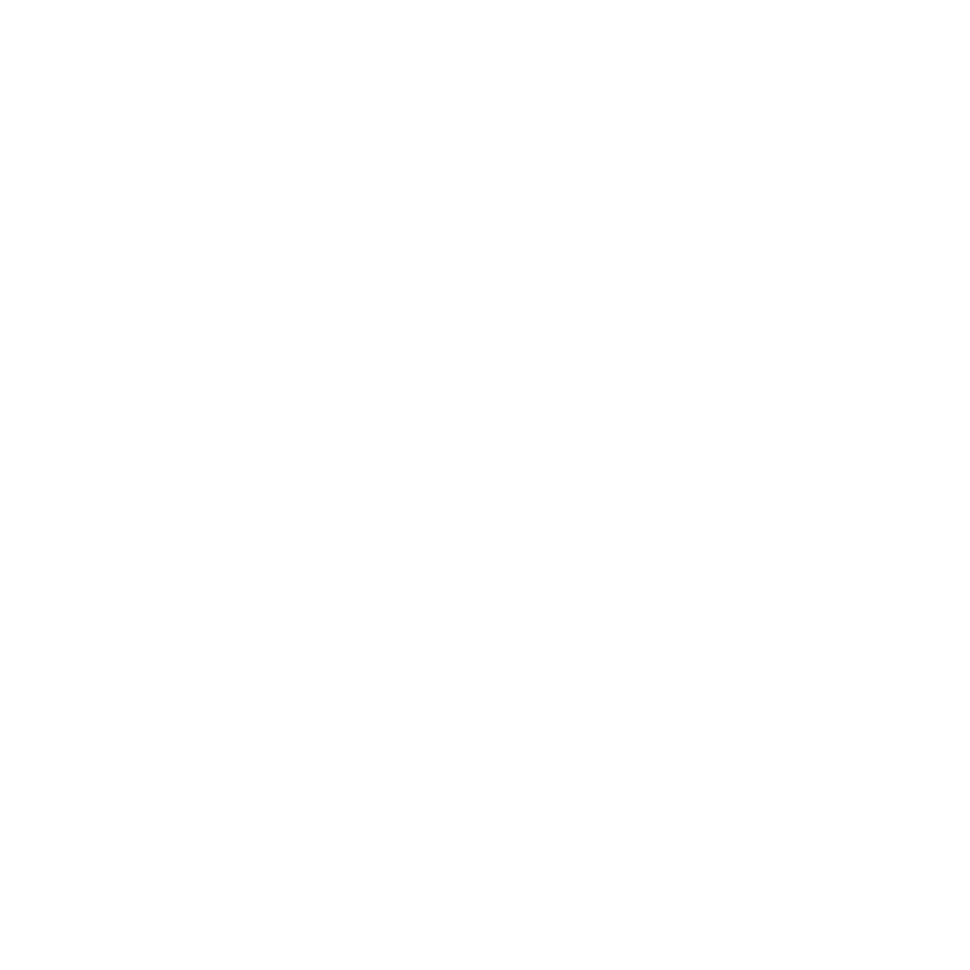

Ref. prior: 42.2037135 au
Fitting SED at 43.23776459999999 au
SED data = [1.70532608e+10 6.13178982e+09 6.99203904e+08]
Per cent error = [10.05421083 10.04029658  5.46672523]
Initial guess = [21.65139496 -1.83096571 -1.10321168  3.41694528]


<IPython.core.display.Javascript object>


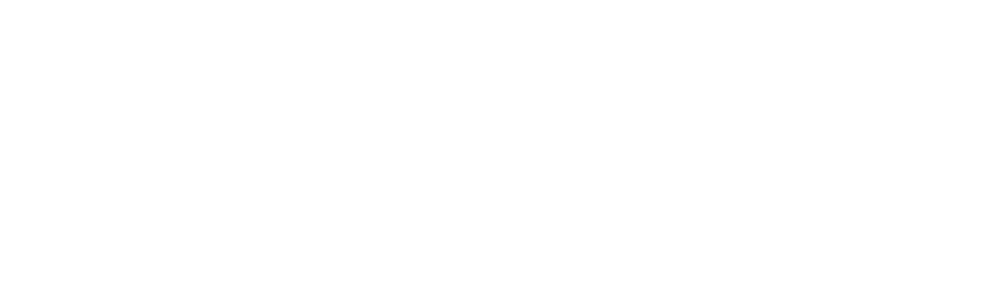

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


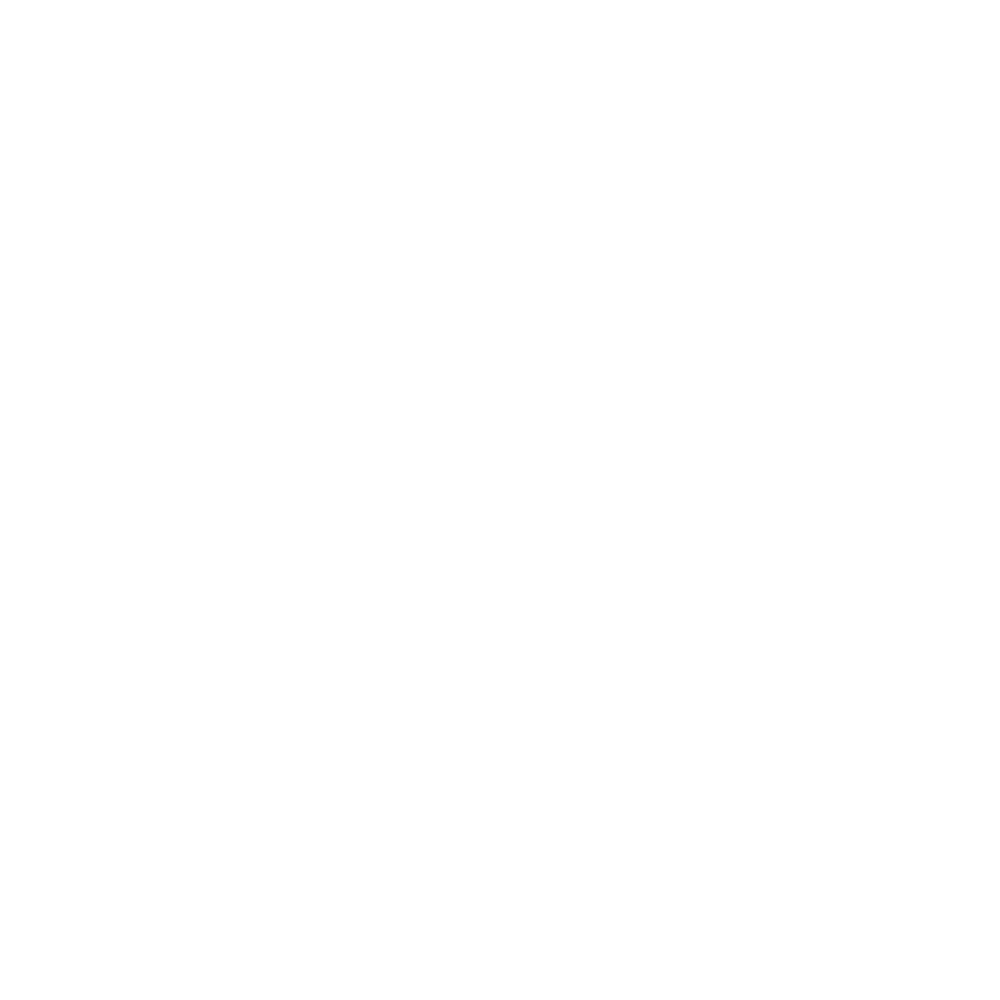

<IPython.core.display.Javascript object>


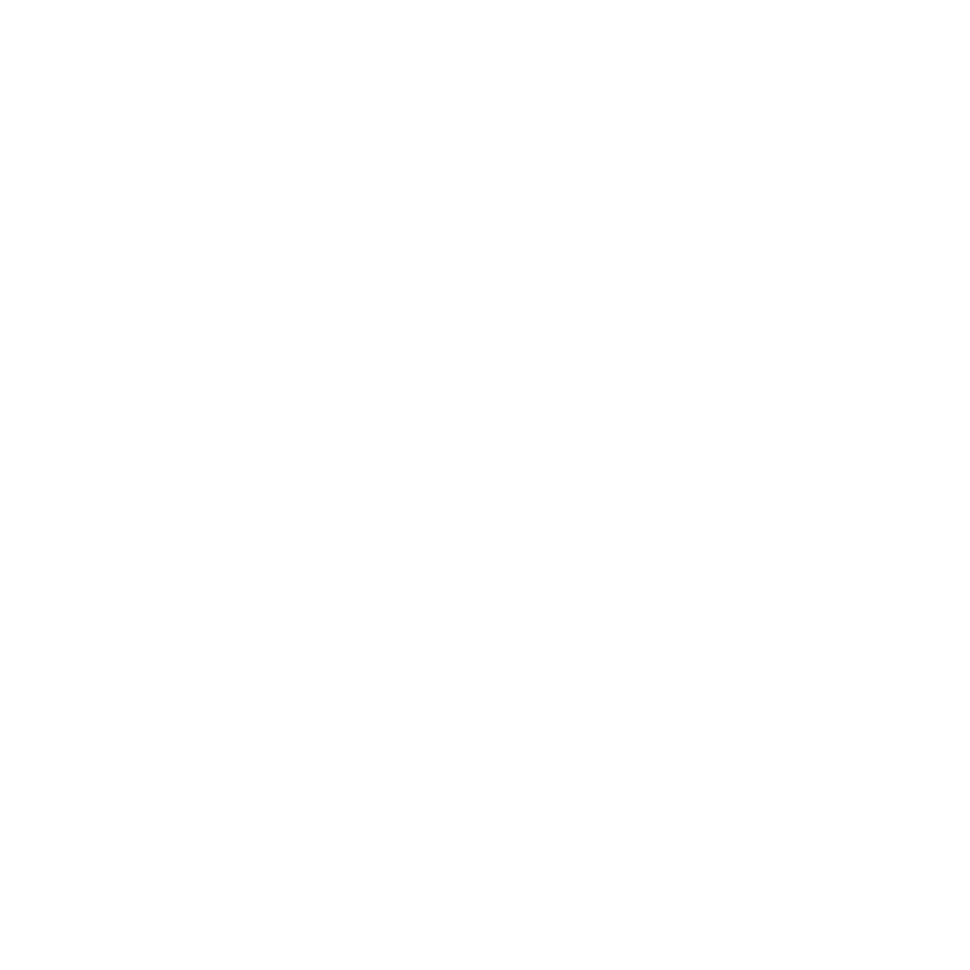

Ref. prior: 45.3299145 au
Fitting SED at 45.0974534 au
SED data = [1.59419986e+10 5.67332250e+09 6.47199552e+08]
Per cent error = [10.07400531 10.06685987  5.51247877]
Initial guess = [21.08677606 -1.84140139 -1.10197929  3.45356419]


<IPython.core.display.Javascript object>


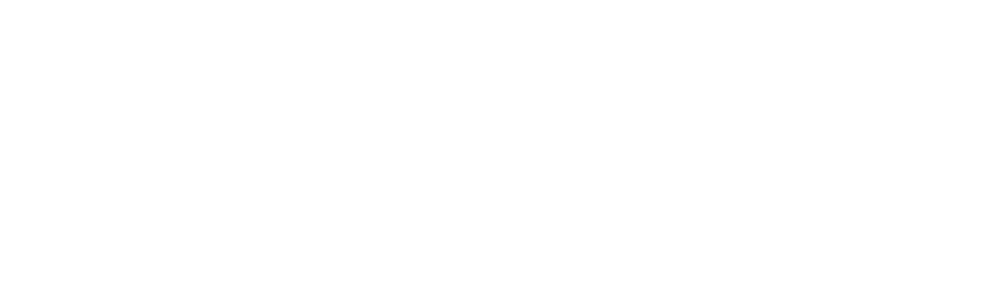

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


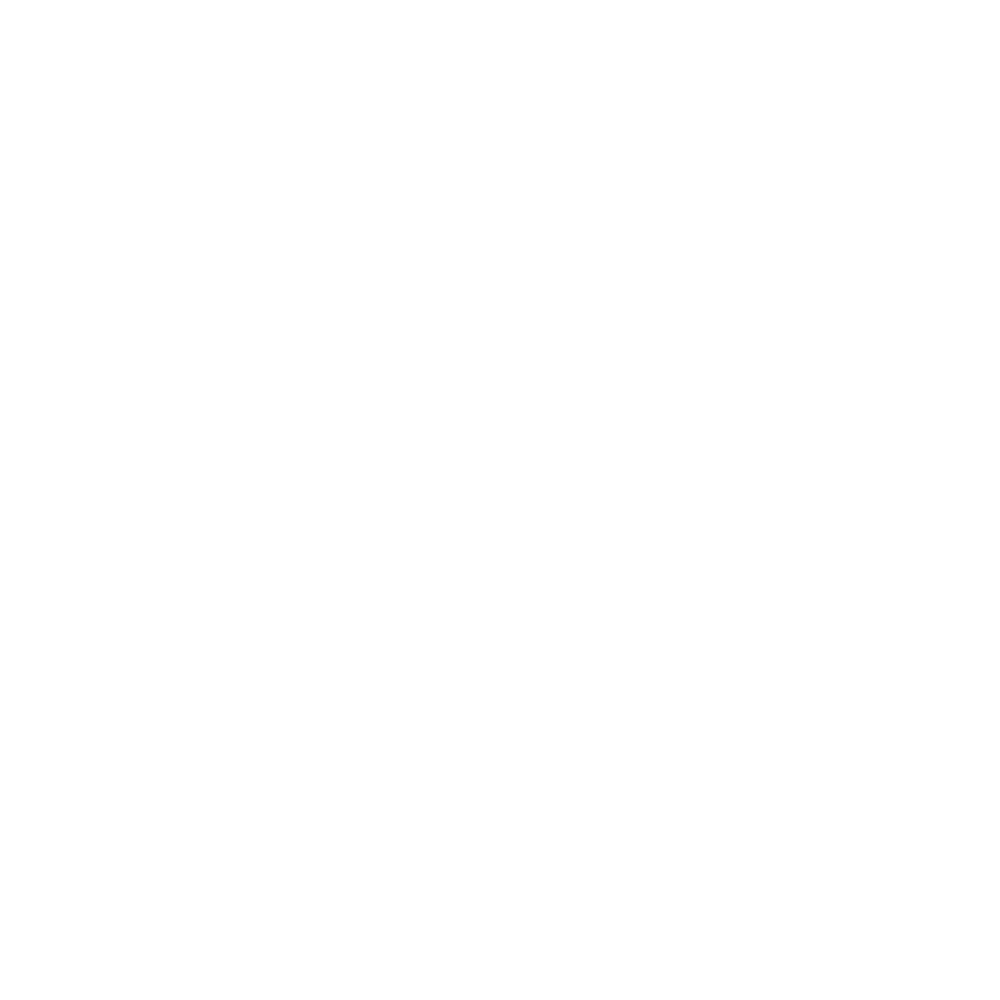

<IPython.core.display.Javascript object>


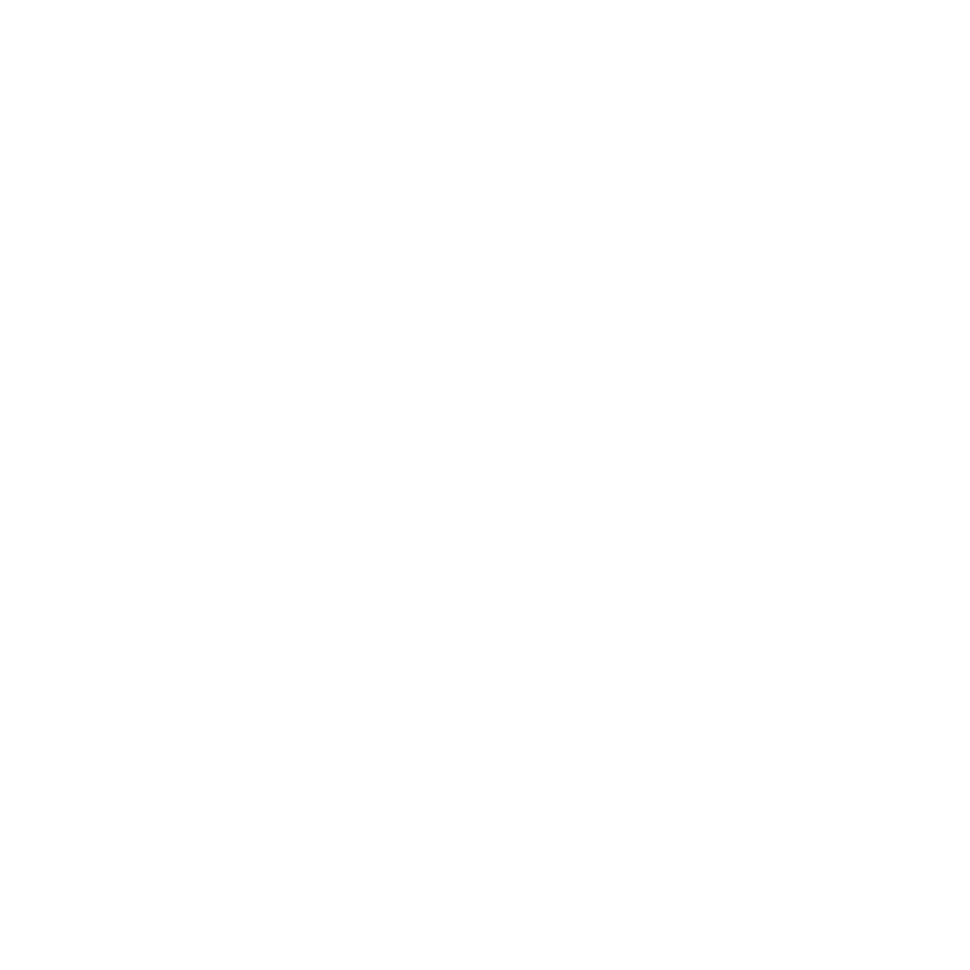

Ref. prior: 48.45611550000001 au
Fitting SED at 46.95714219999999 au
SED data = [1.51213363e+10 5.34593126e+09 6.07270912e+08]
Per cent error = [10.08676368 10.0852505   5.55950803]
Initial guess = [20.38877811 -1.85195103 -1.10450609  3.46805068]


<IPython.core.display.Javascript object>


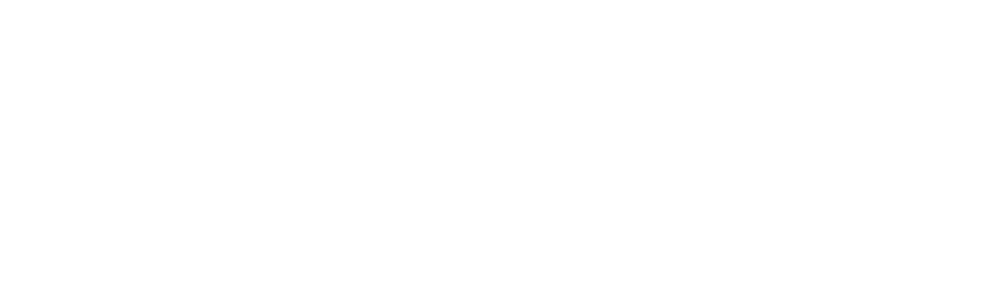

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


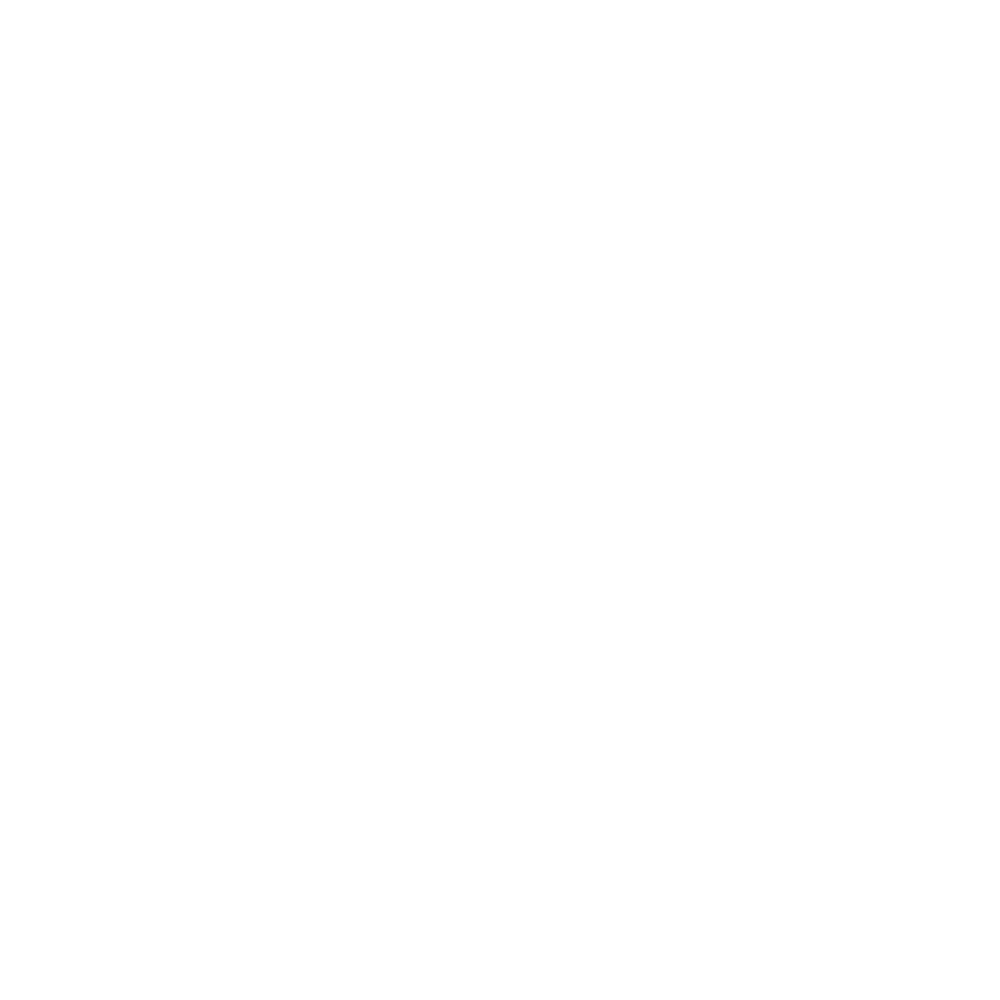

<IPython.core.display.Javascript object>


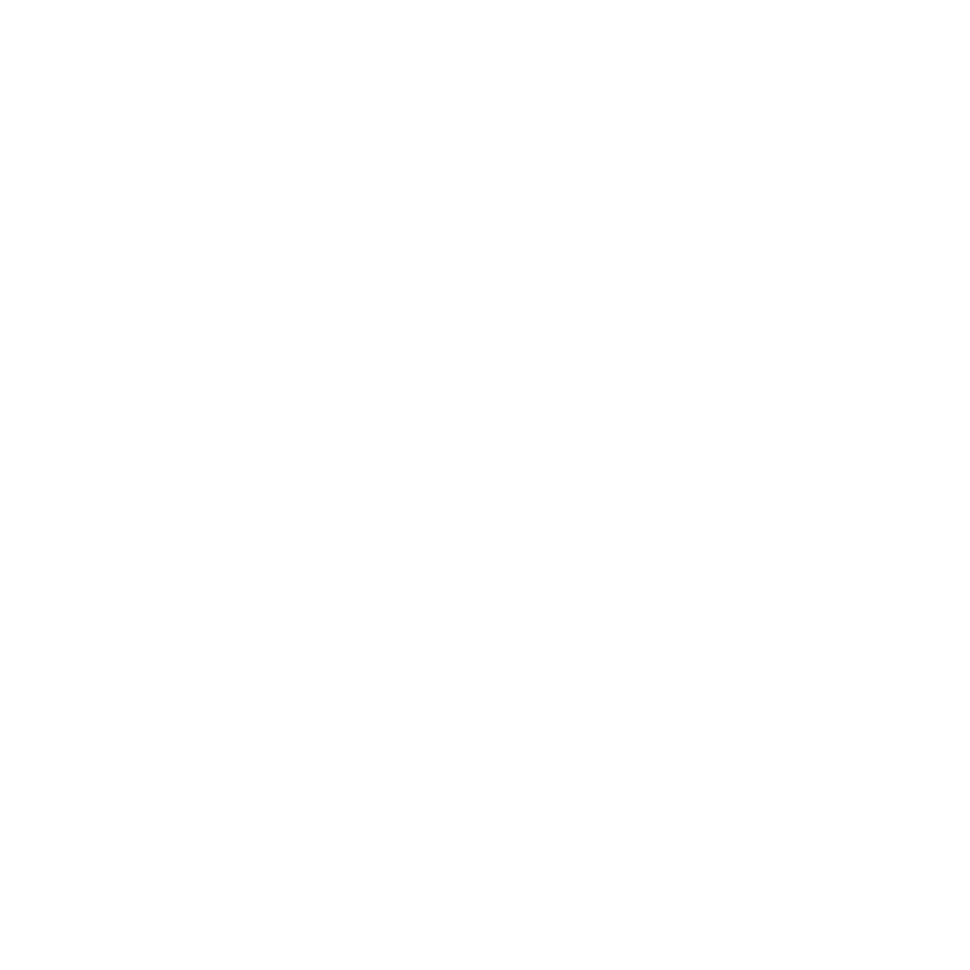

Ref. prior: 48.45611550000001 au
Fitting SED at 48.816831 au
SED data = [1.46030438e+10 5.18205594e+09 5.85746112e+08]
Per cent error = [10.08625407 10.07948392  5.52977369]
Initial guess = [20.38877811 -1.85195103 -1.10450609  3.46805068]


<IPython.core.display.Javascript object>


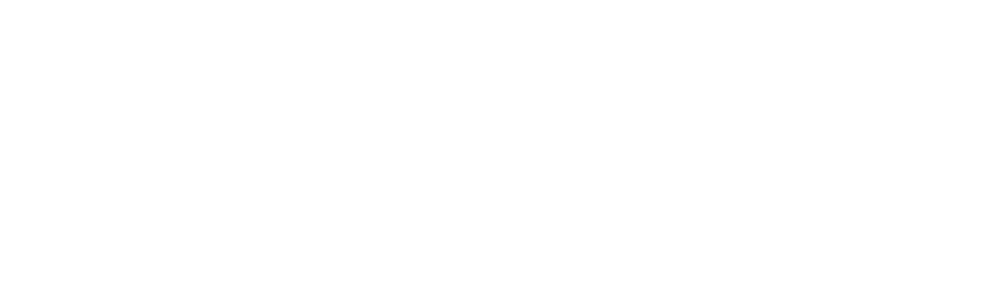

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


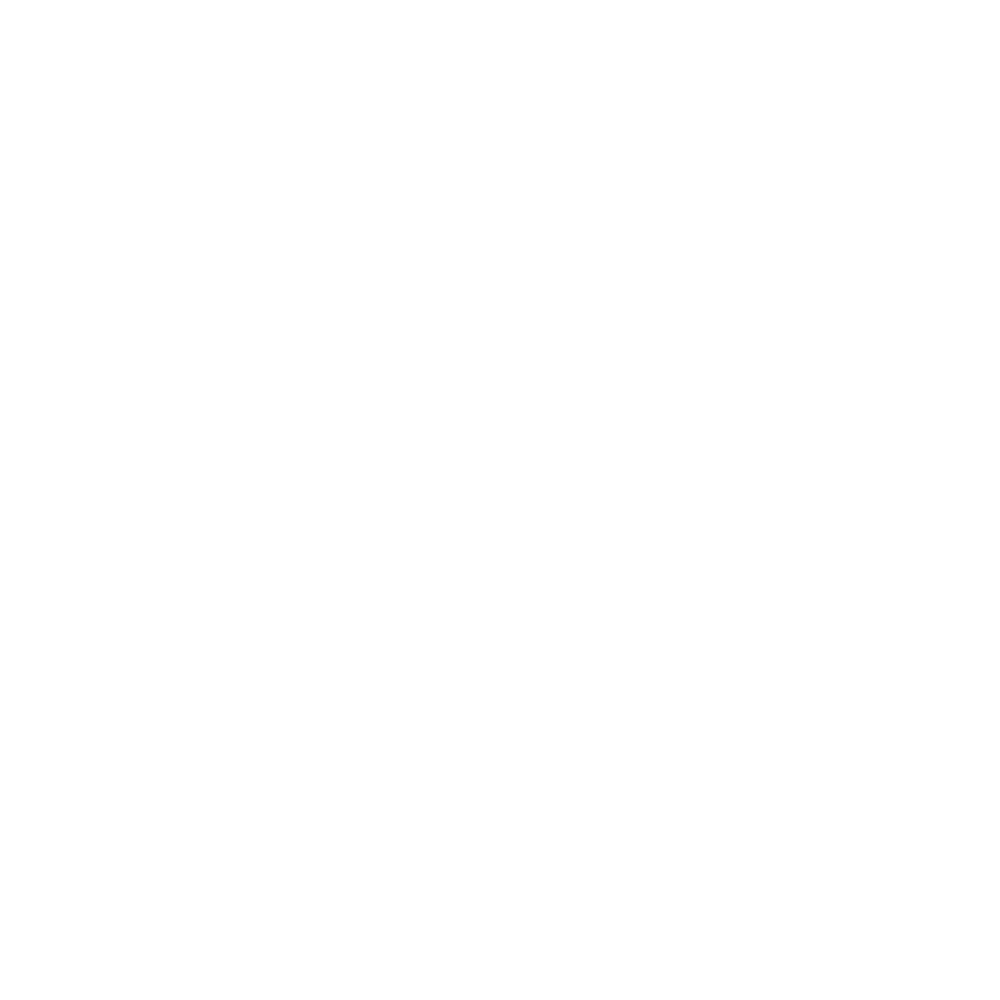

<IPython.core.display.Javascript object>


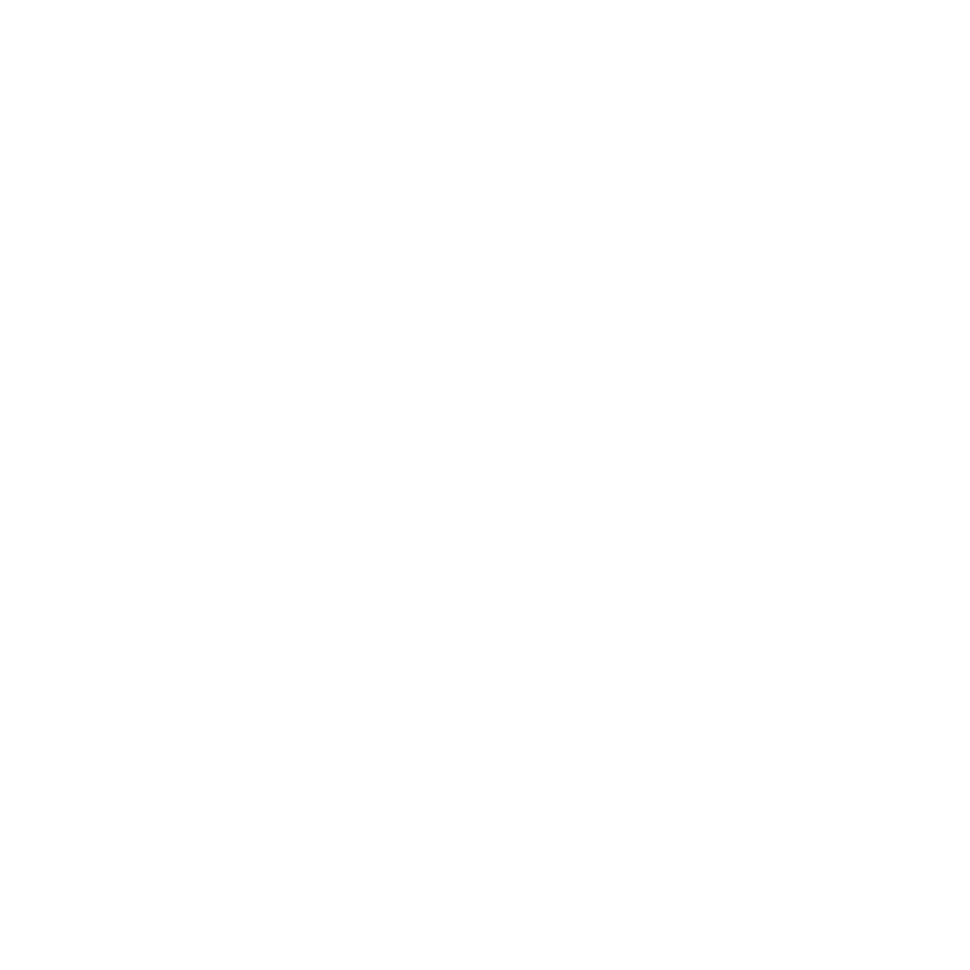

Ref. prior: 51.5823165 au
Fitting SED at 50.676519799999994 au
SED data = [1.42897695e+10 5.11098470e+09 5.80796096e+08]
Per cent error = [10.07109962 10.05695335  5.51409762]
Initial guess = [19.81351511 -1.86150257 -1.10764804  3.50093767]


<IPython.core.display.Javascript object>


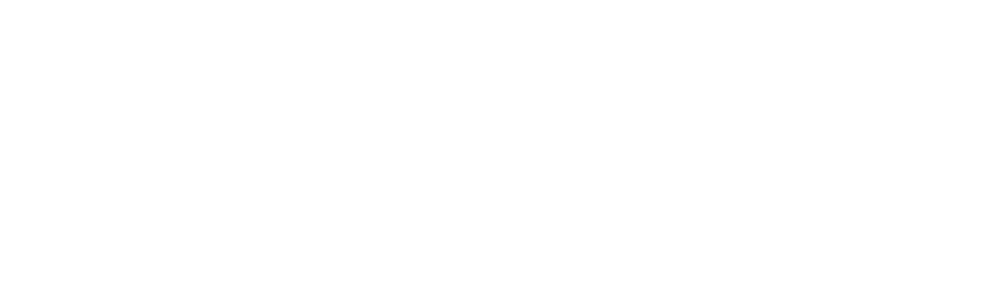

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


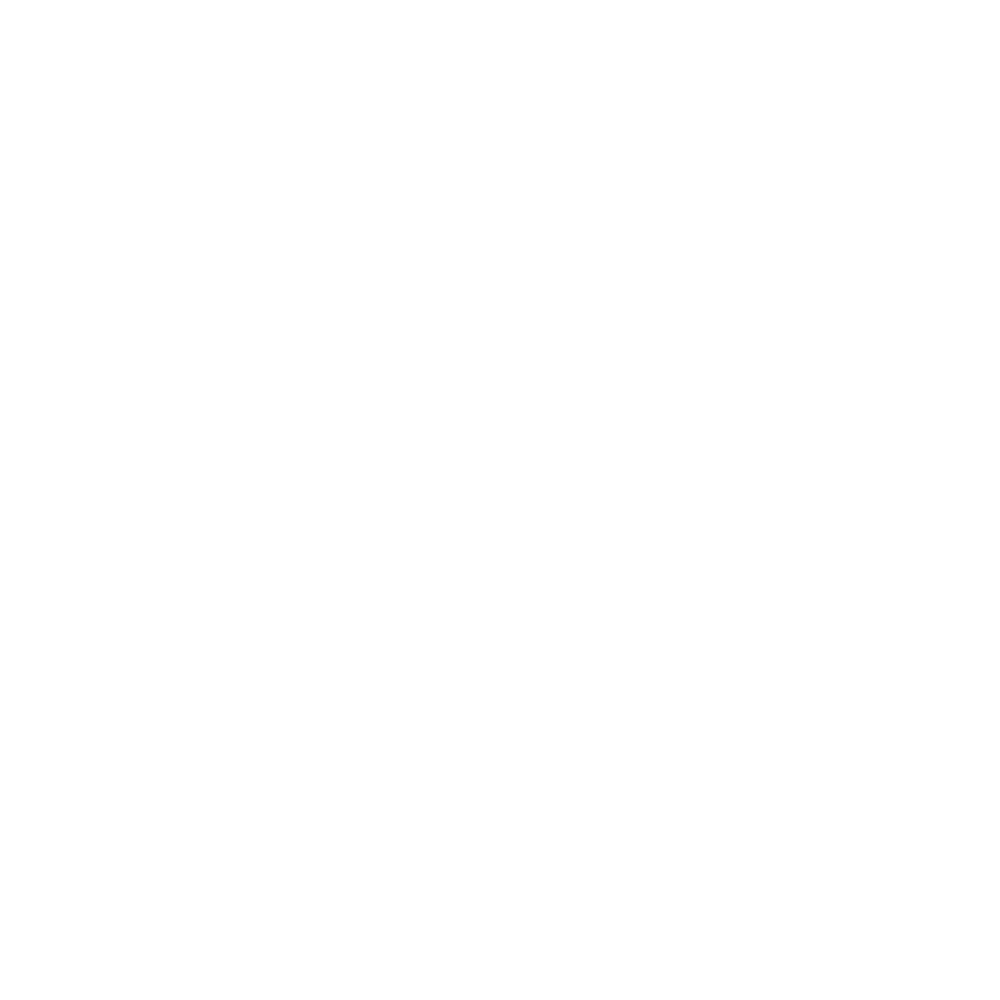

<IPython.core.display.Javascript object>


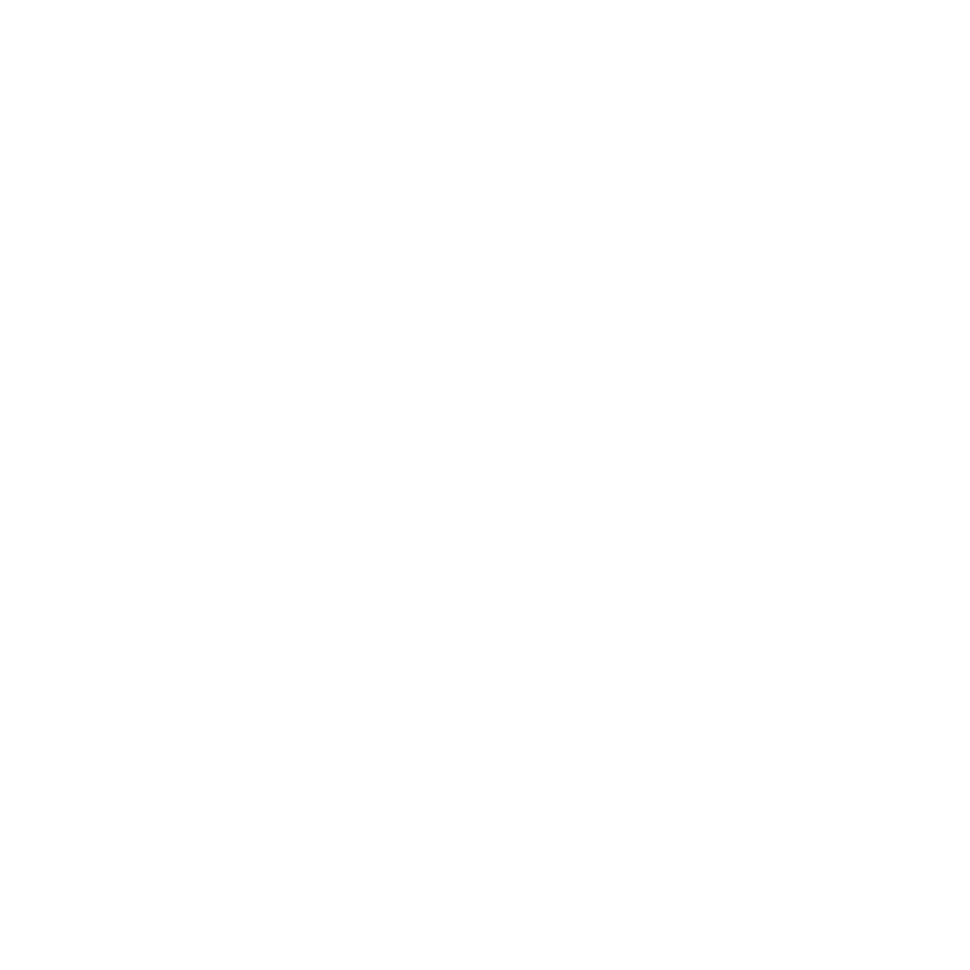

Ref. prior: 51.5823165 au
Fitting SED at 52.5362086 au
SED data = [1.42331812e+10 5.18190490e+09 5.86900096e+08]
Per cent error = [10.04719996 10.03014514  5.45125449]
Initial guess = [19.81351511 -1.86150257 -1.10764804  3.50093767]


<IPython.core.display.Javascript object>


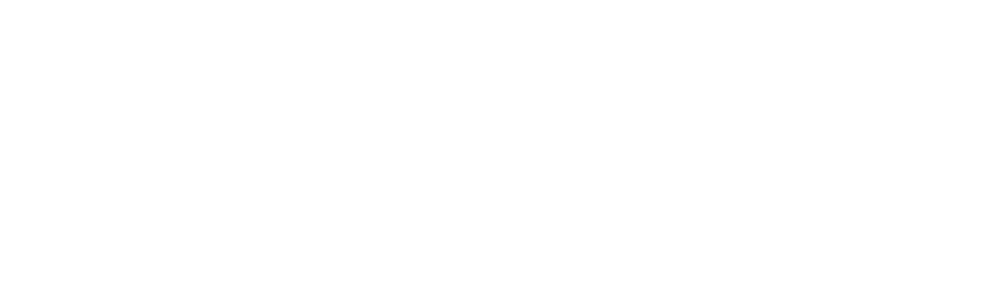

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


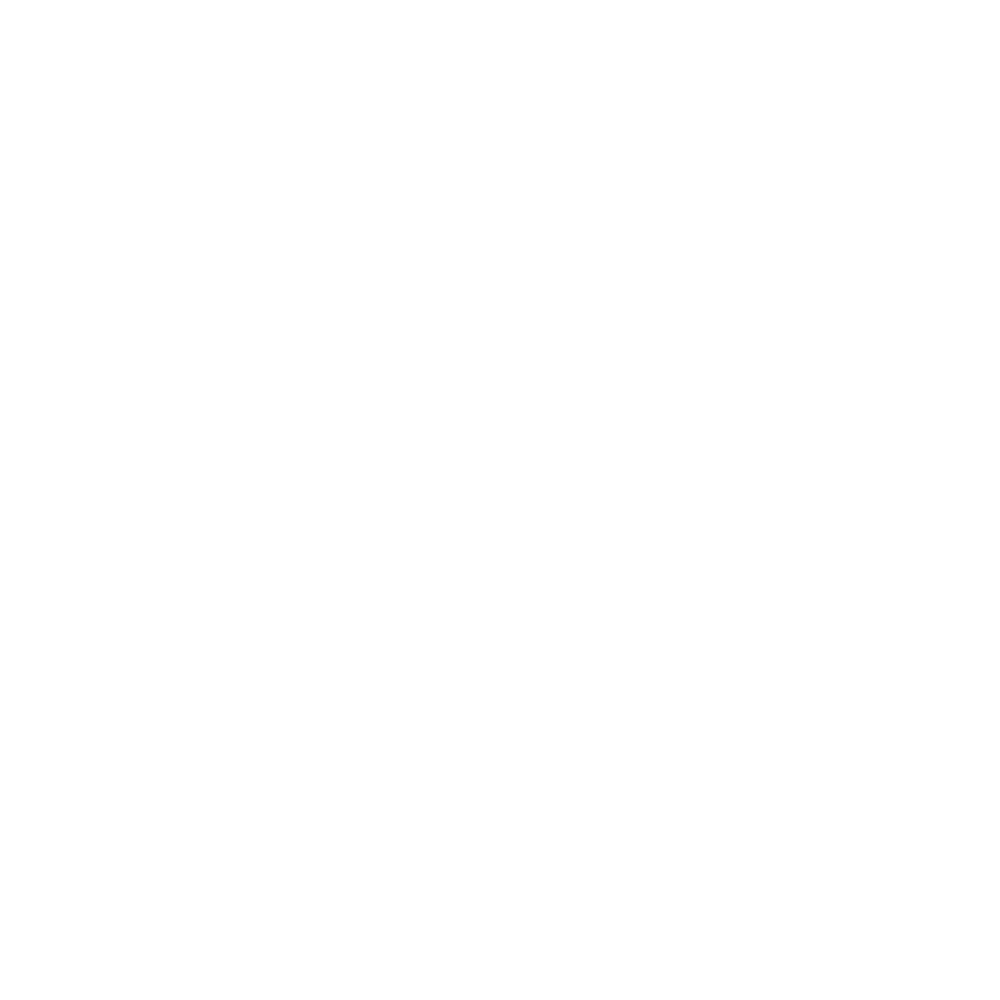

<IPython.core.display.Javascript object>


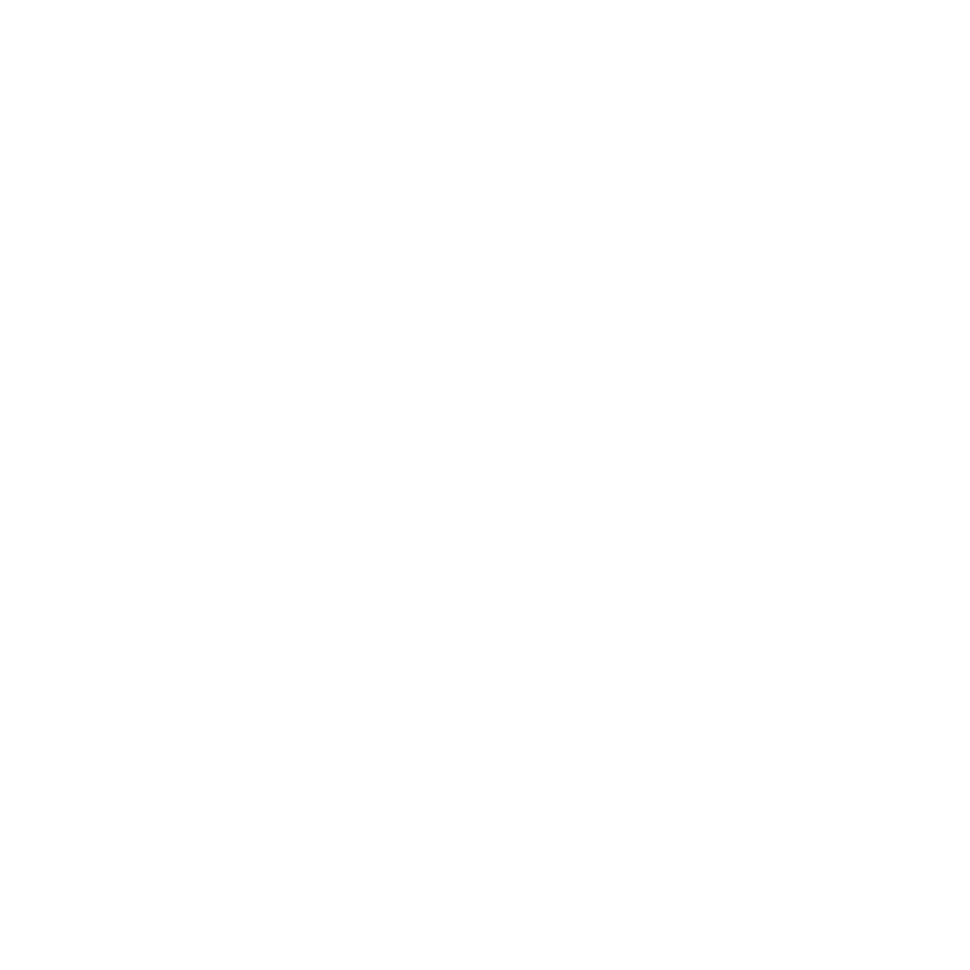

Ref. prior: 54.708517500000006 au
Fitting SED at 54.395897399999996 au
SED data = [1.42504509e+10 5.30342400e+09 5.94287680e+08]
Per cent error = [10.03459905 10.01440297  5.40295983]
Initial guess = [19.06698338 -1.85582473 -1.10836661  3.53050231]


<IPython.core.display.Javascript object>


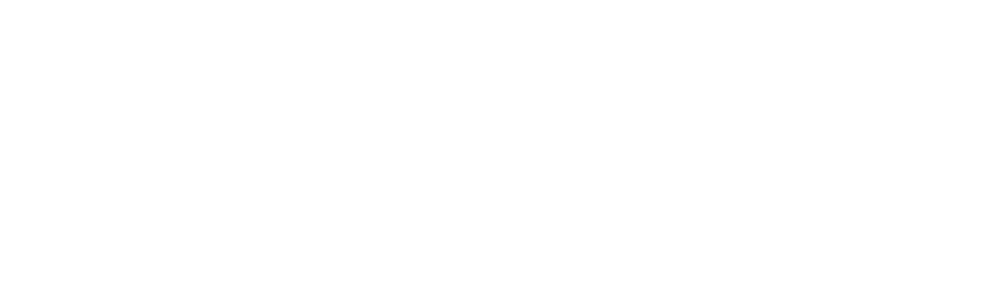

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


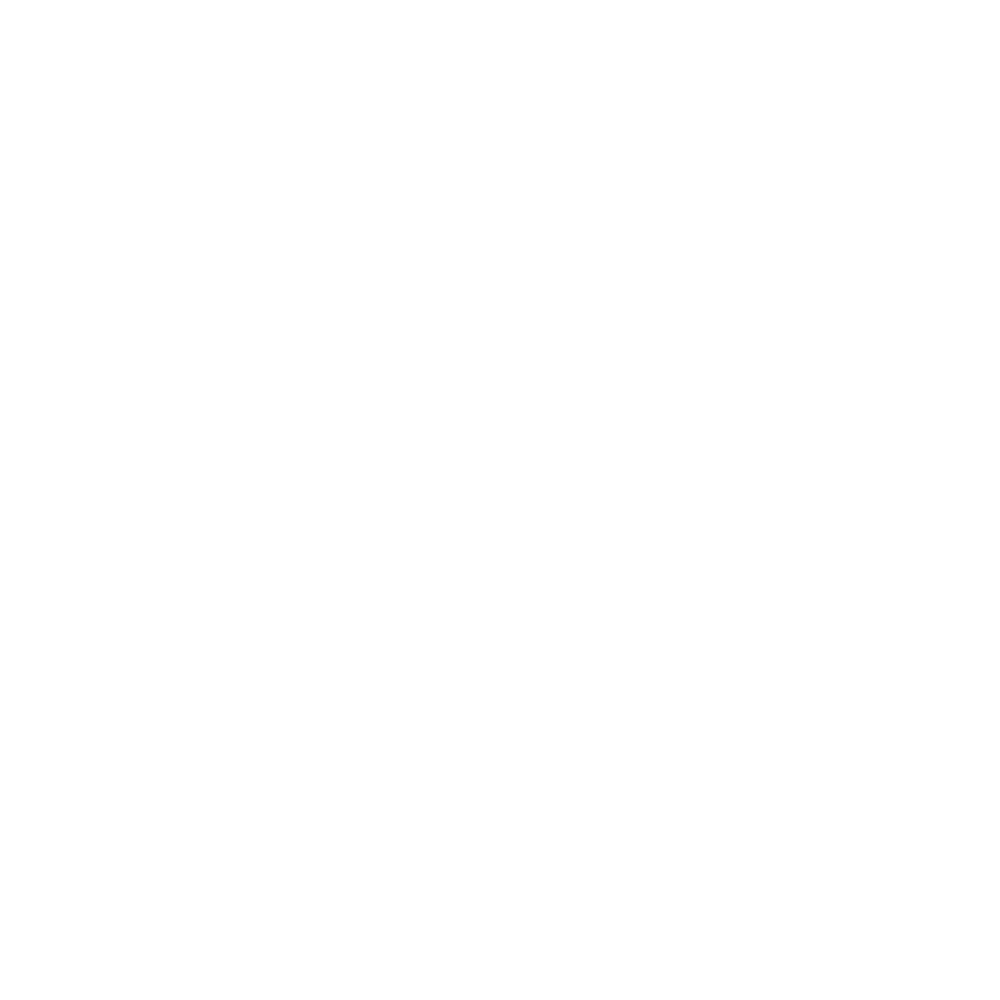

<IPython.core.display.Javascript object>


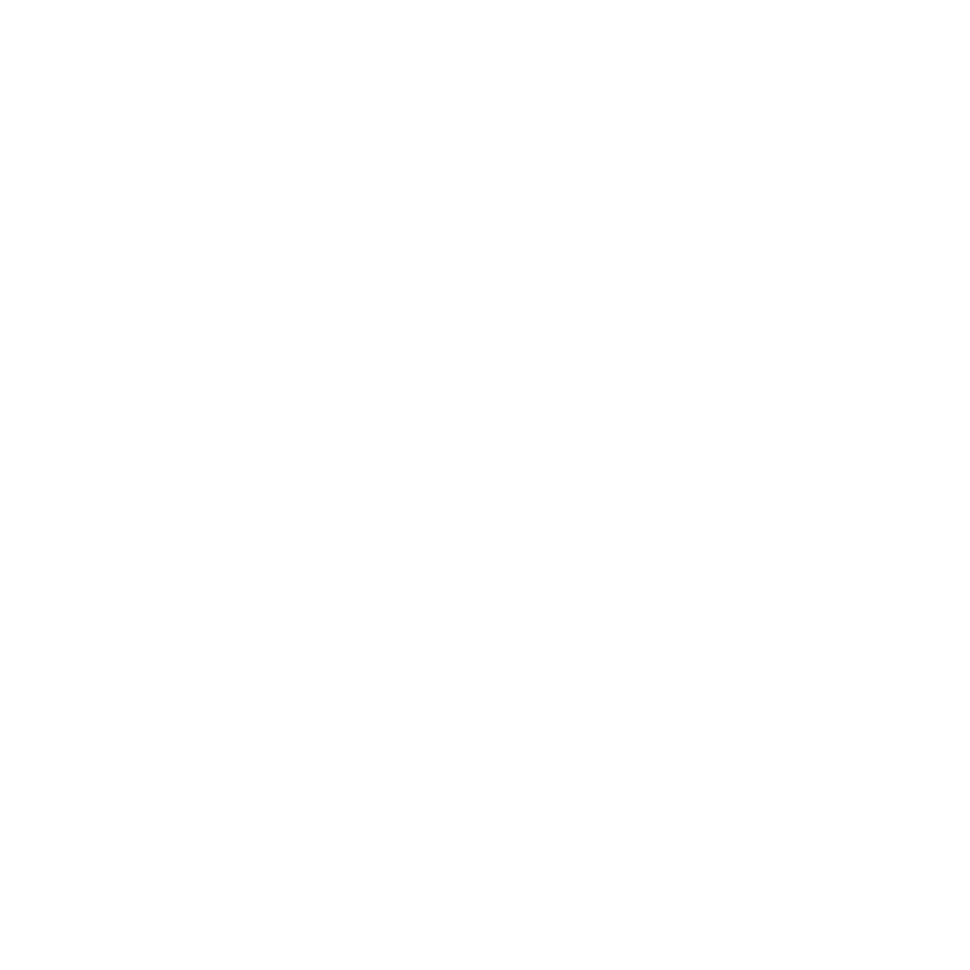

Ref. prior: 54.708517500000006 au
Fitting SED at 56.2555862 au
SED data = [1.42741023e+10 5.43718093e+09 6.07155264e+08]
Per cent error = [10.0272476  10.01151255  5.42181425]
Initial guess = [19.06698338 -1.85582473 -1.10836661  3.53050231]


<IPython.core.display.Javascript object>


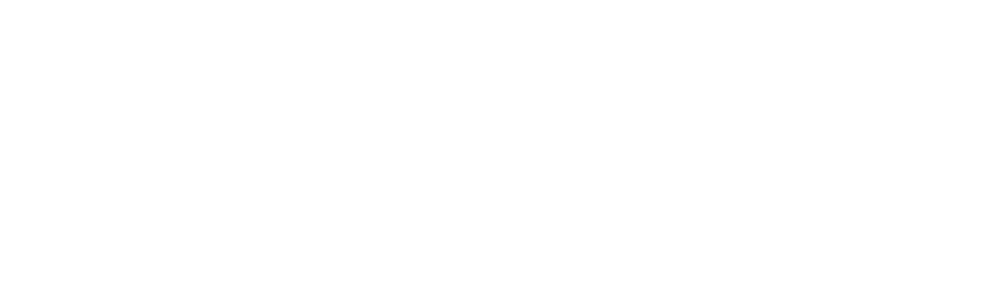

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


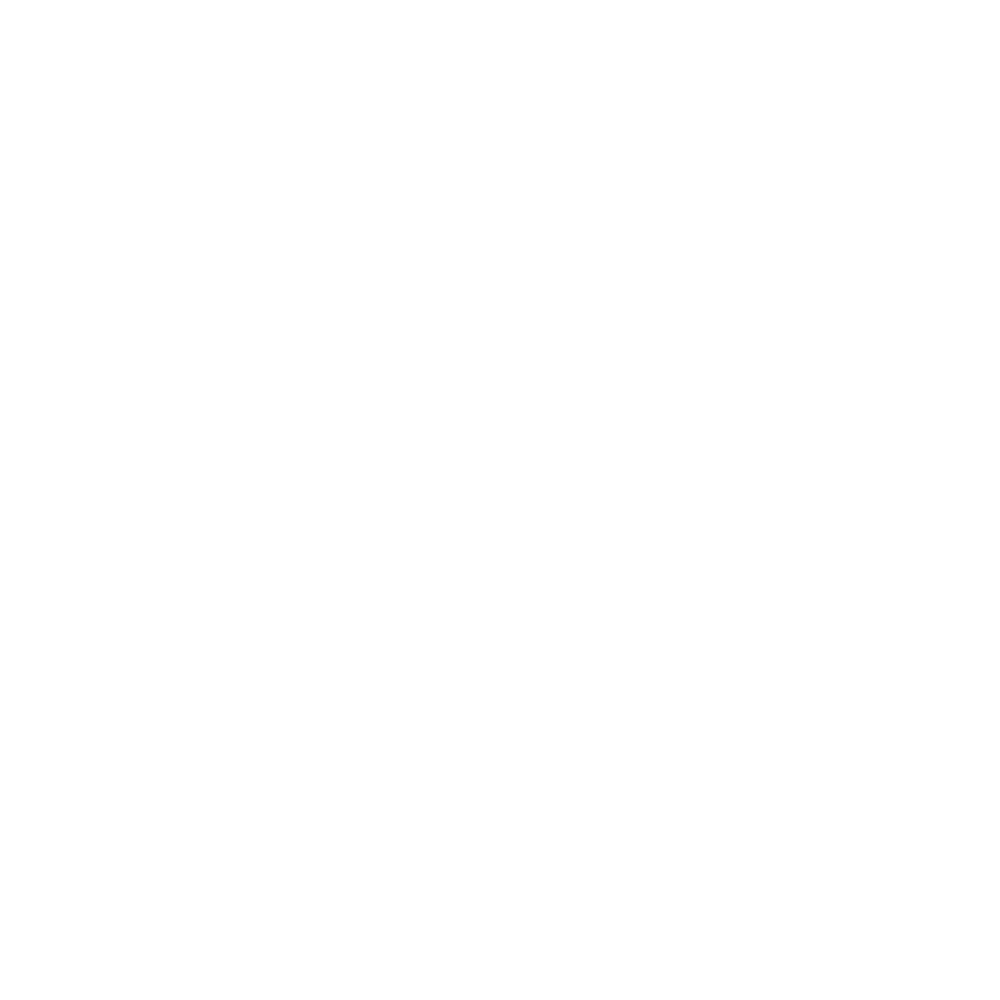

<IPython.core.display.Javascript object>


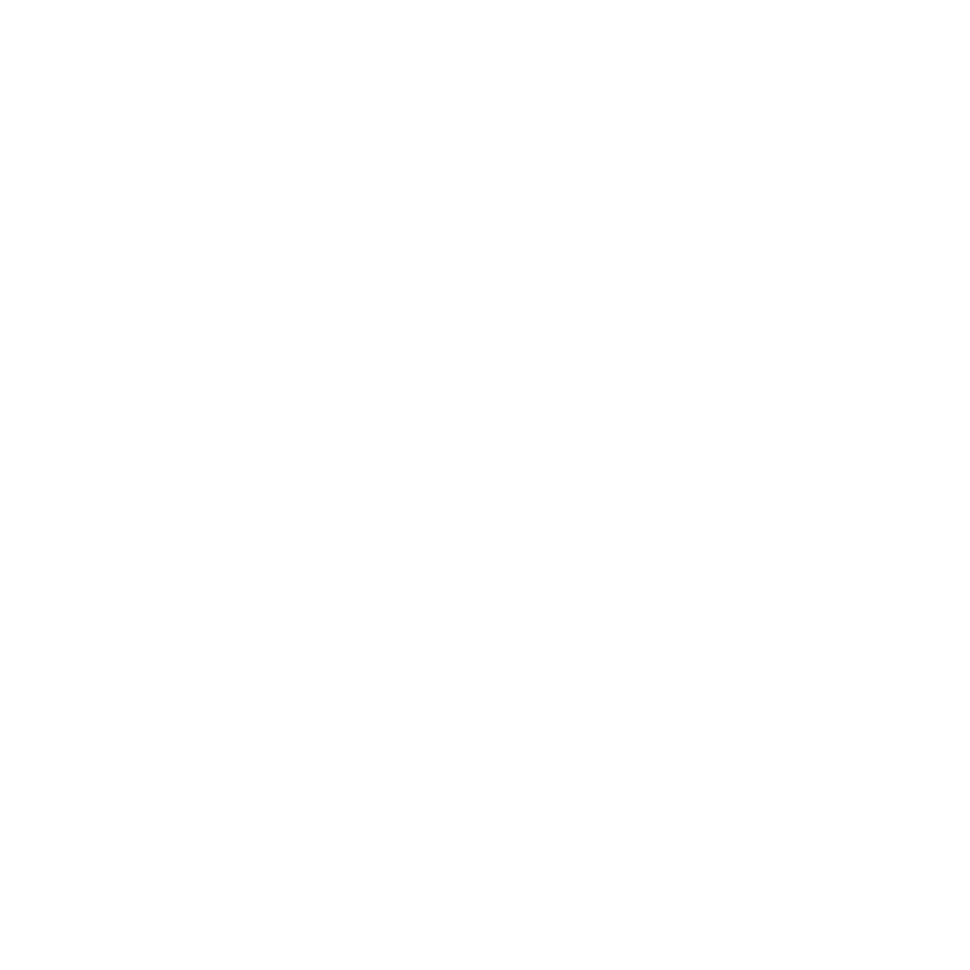

Ref. prior: 57.83471850000001 au
Fitting SED at 58.115275 au
SED data = [1.43005604e+10 5.52689562e+09 6.14361600e+08]
Per cent error = [10.02827113 10.01338378  5.43210674]
Initial guess = [18.88504078 -1.85889692 -1.10648092  3.56044158]


<IPython.core.display.Javascript object>


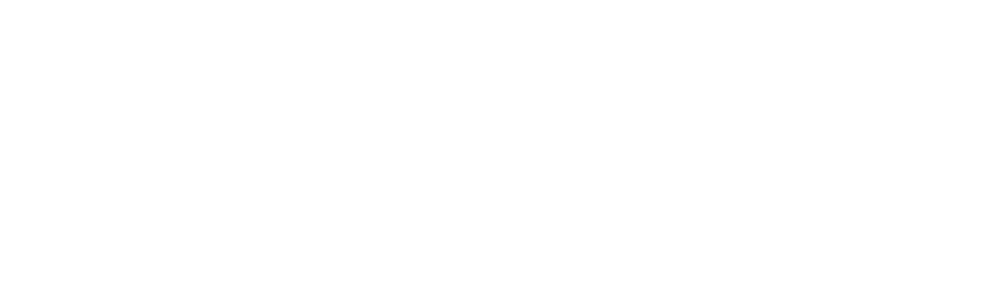

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


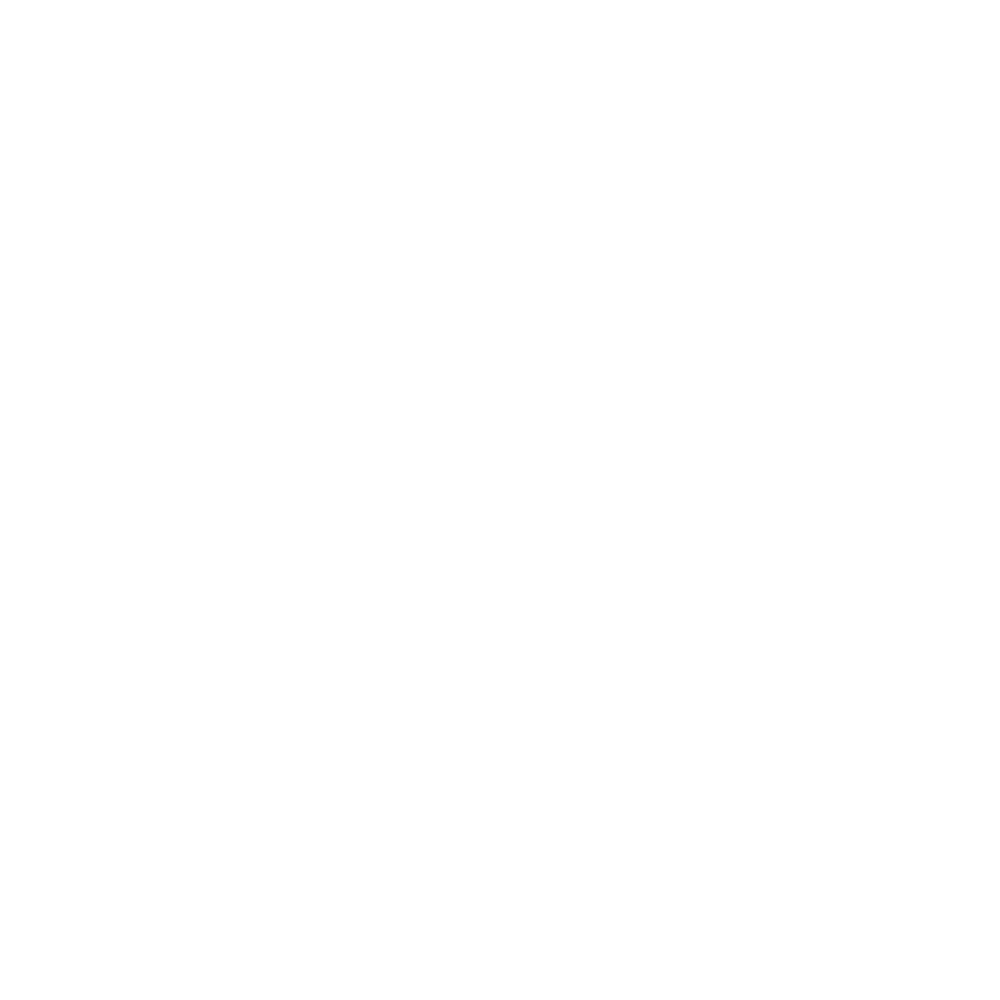

<IPython.core.display.Javascript object>


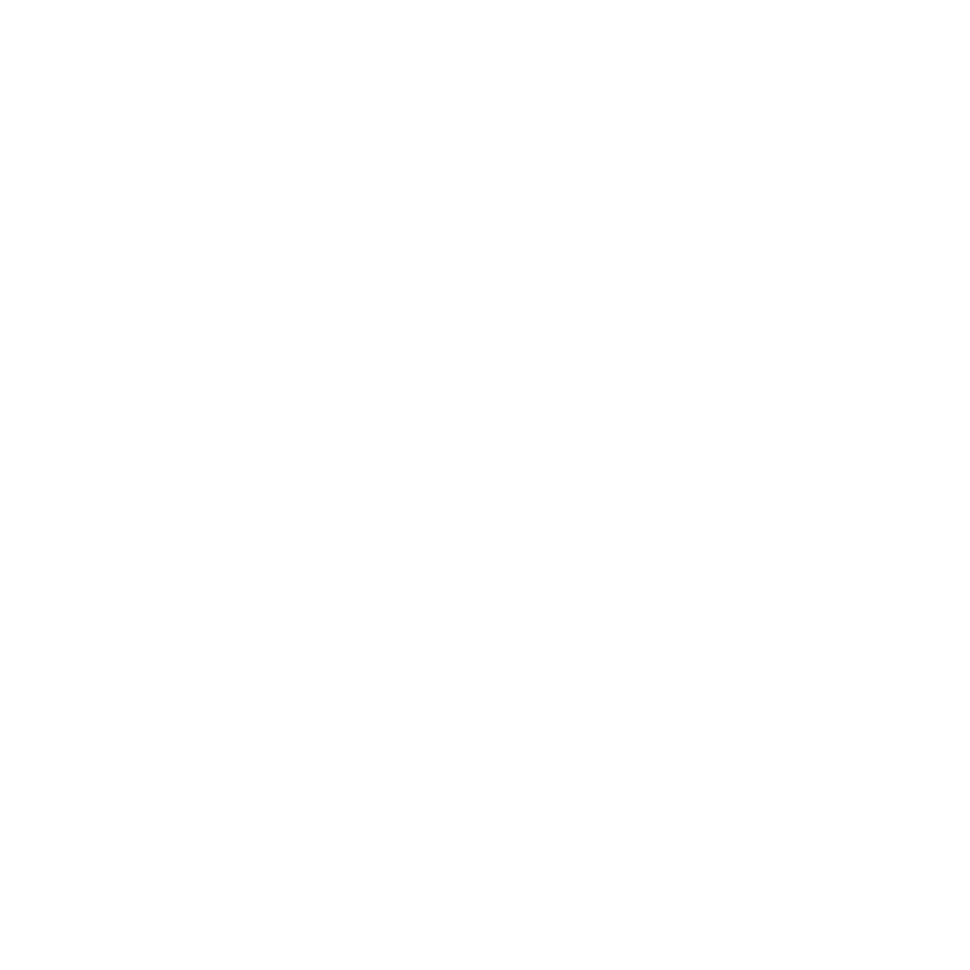

Ref. prior: 60.9609195 au
Fitting SED at 59.974963800000005 au
SED data = [1.42567741e+10 5.57643571e+09 6.22057280e+08]
Per cent error = [10.02822422 10.01790802  5.44494461]
Initial guess = [18.24000813 -1.85600426 -1.10914877  3.58850359]


<IPython.core.display.Javascript object>


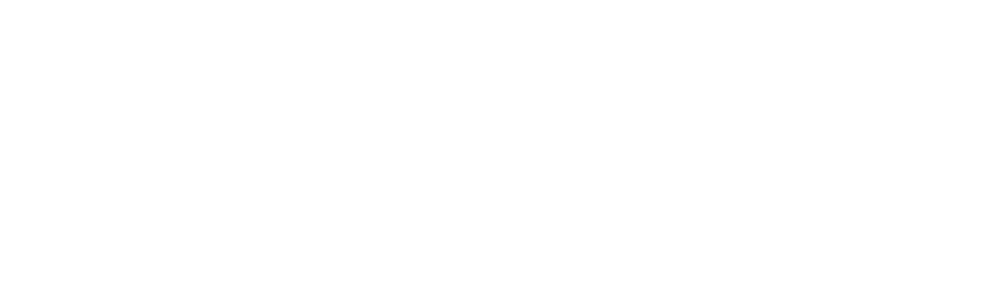

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


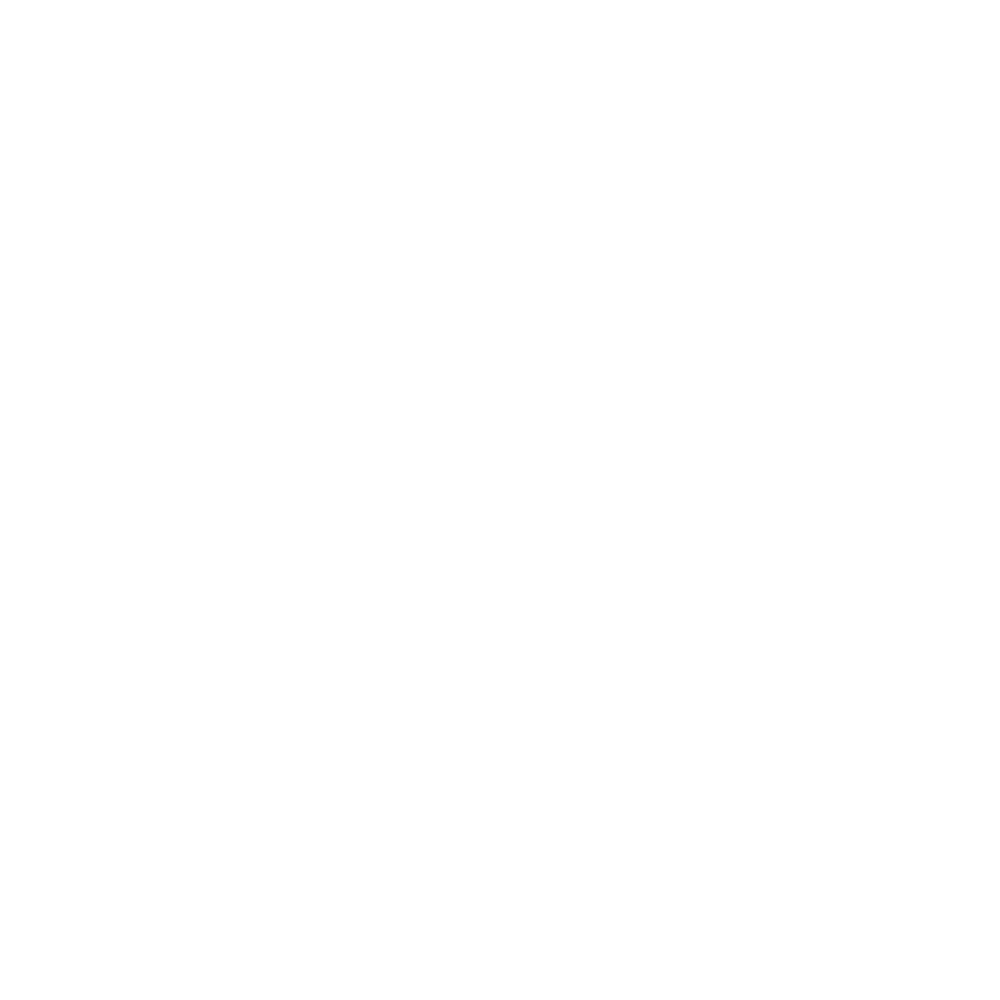

<IPython.core.display.Javascript object>


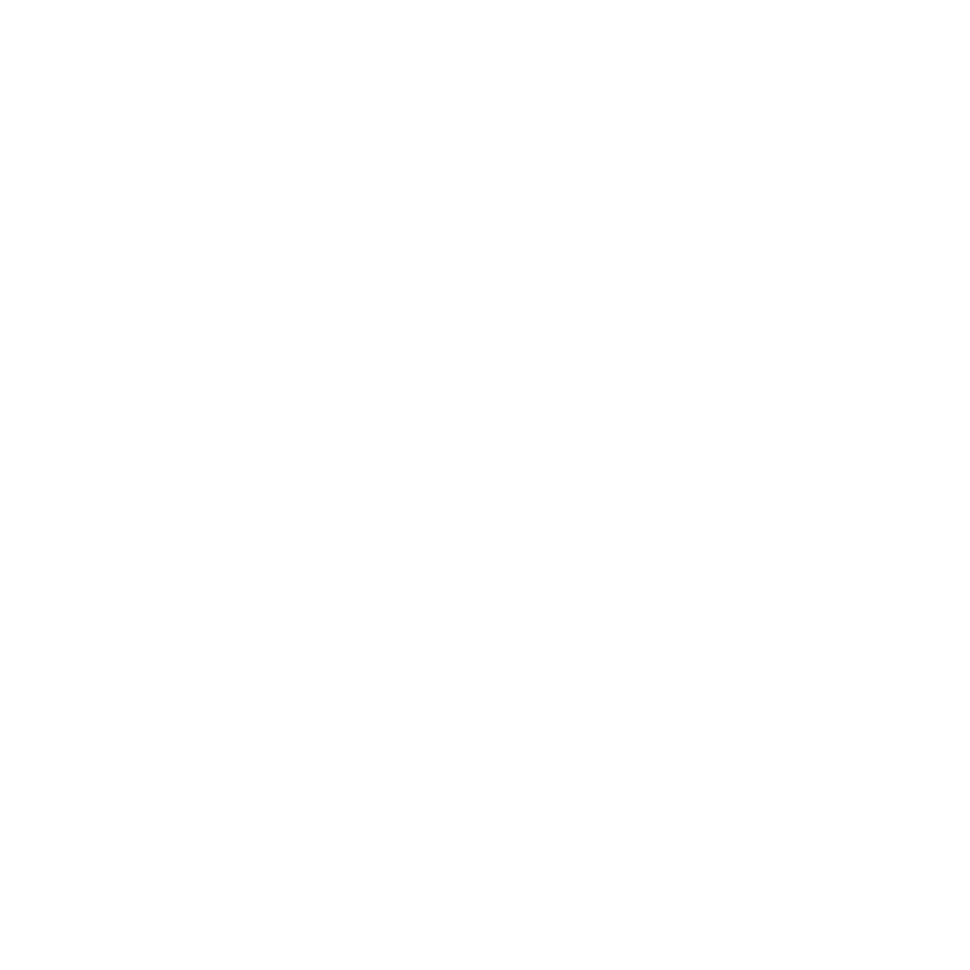

Ref. prior: 60.9609195 au
Fitting SED at 61.83465259999999 au
SED data = [1.41083617e+10 5.55841587e+09 6.21754816e+08]
Per cent error = [10.02998017 10.019486    5.46538233]
Initial guess = [18.24000813 -1.85600426 -1.10914877  3.58850359]


<IPython.core.display.Javascript object>


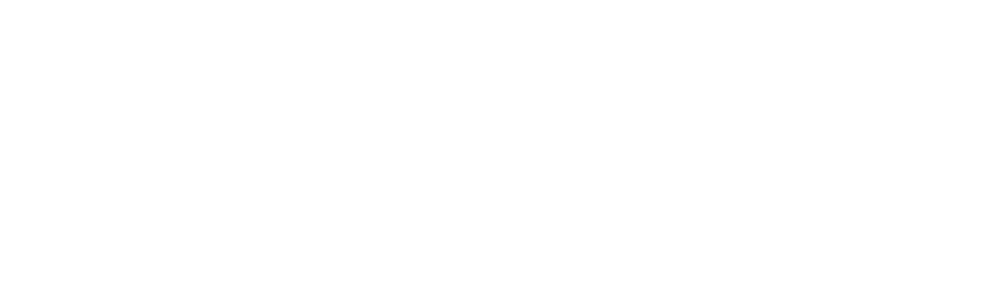

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


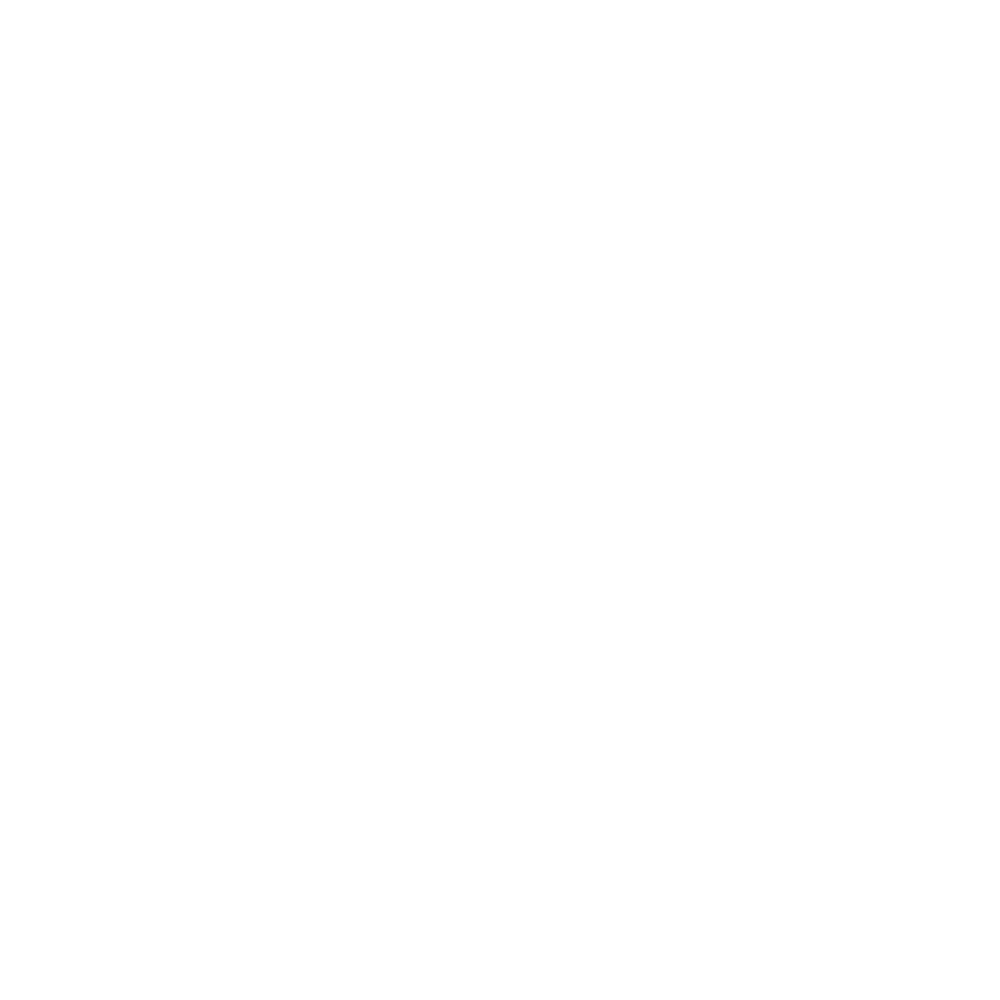

<IPython.core.display.Javascript object>


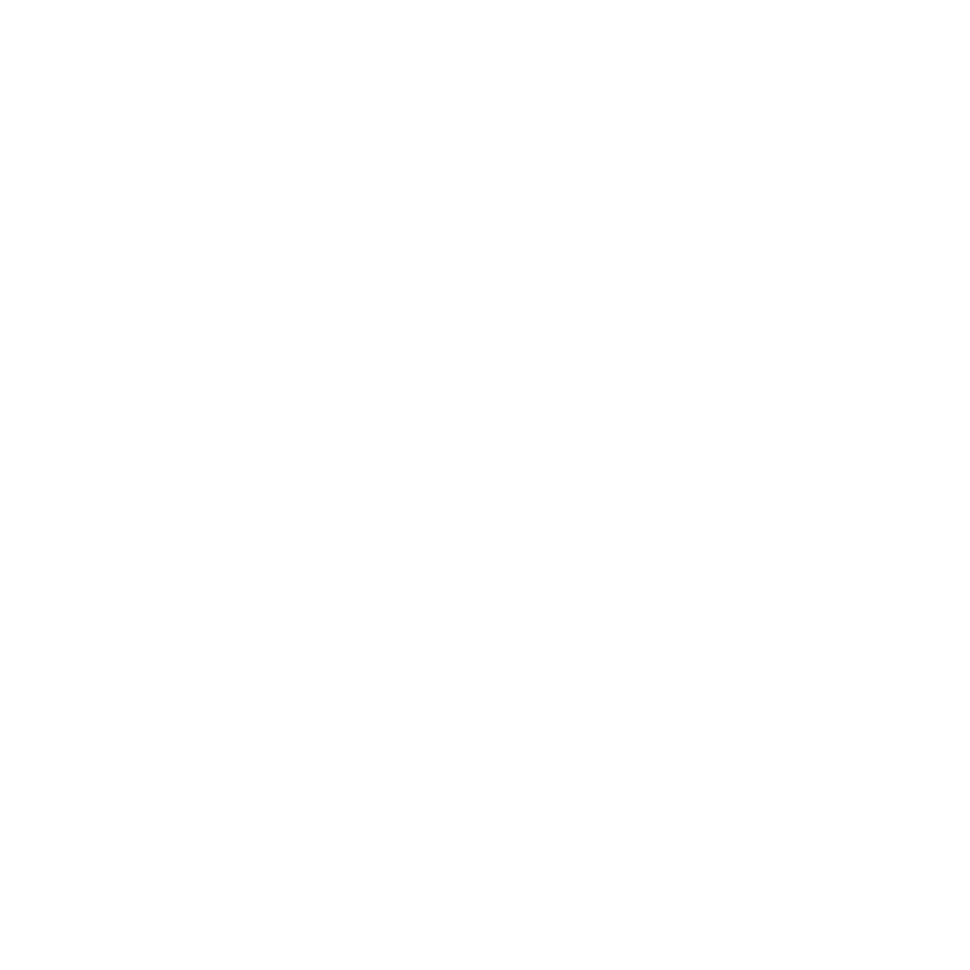

Ref. prior: 64.0871205 au
Fitting SED at 63.694341400000006 au
SED data = [1.38804920e+10 5.45247130e+09 6.06670272e+08]
Per cent error = [10.03028055 10.0258071   5.44367562]
Initial guess = [17.82039395 -1.88130425 -1.11448561  3.58881027]


<IPython.core.display.Javascript object>


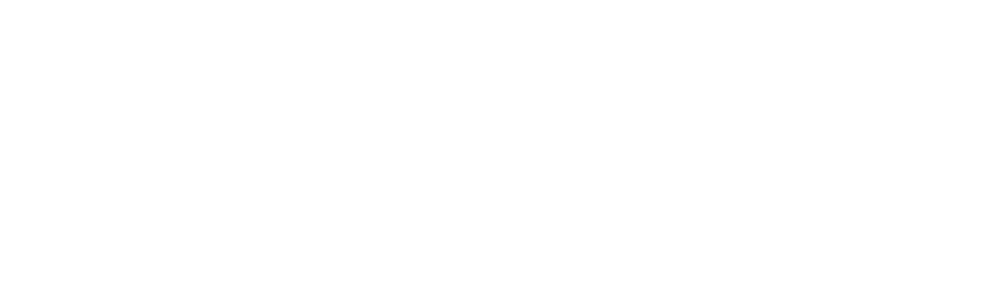

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


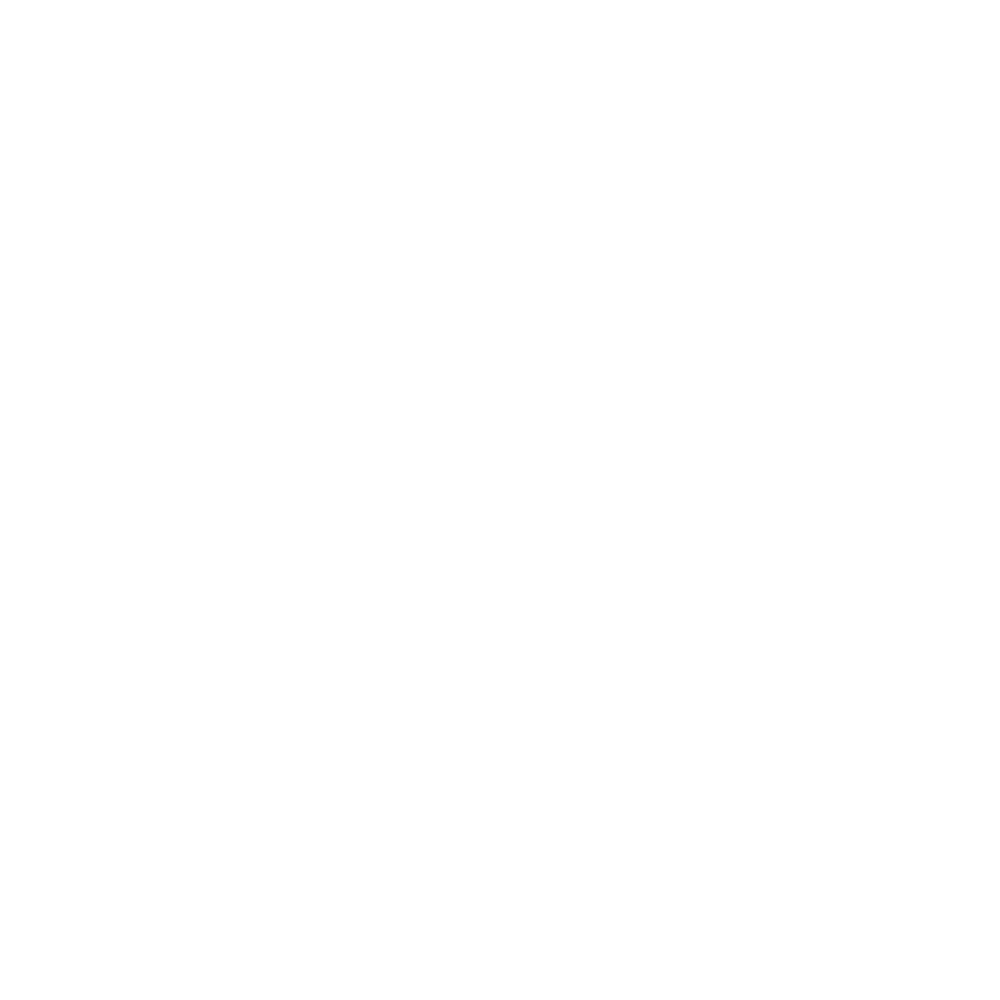

<IPython.core.display.Javascript object>


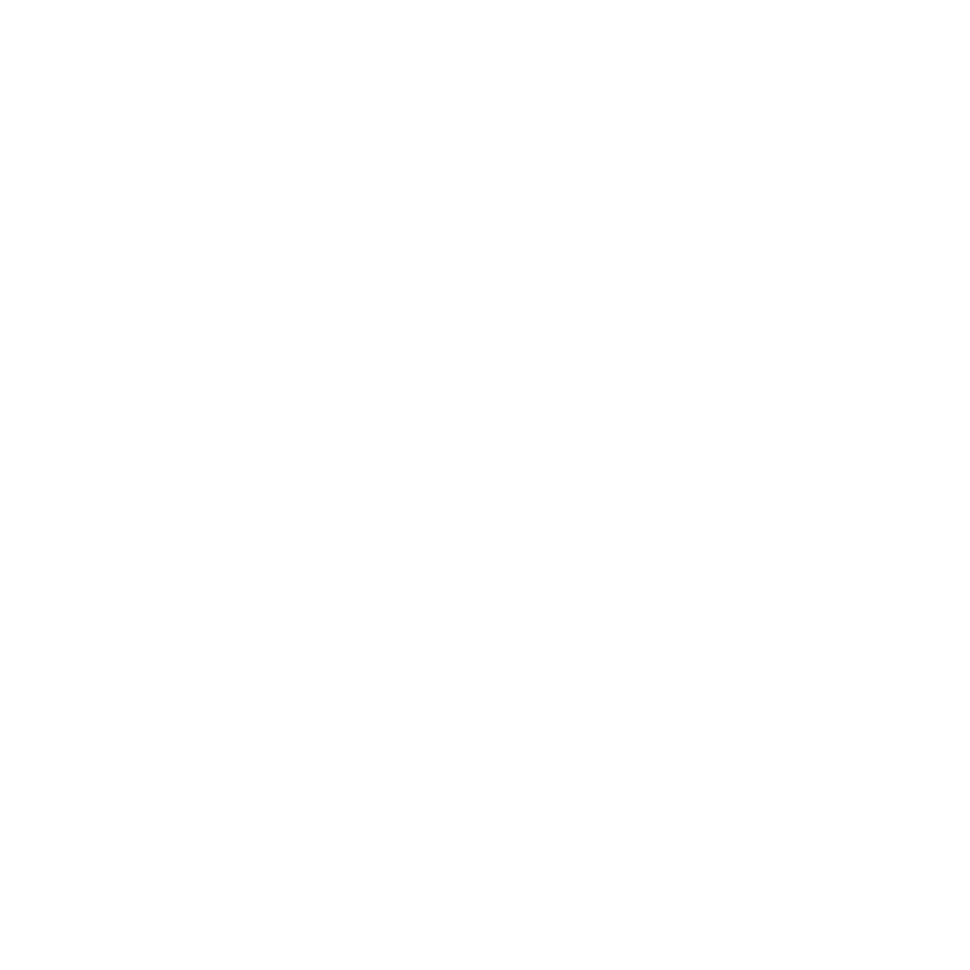

Ref. prior: 64.0871205 au
Fitting SED at 65.5540302 au
SED data = [1.35475630e+10 5.28105779e+09 5.80837248e+08]
Per cent error = [10.03302921 10.02879128  5.41927912]
Initial guess = [17.82039395 -1.88130425 -1.11448561  3.58881027]


<IPython.core.display.Javascript object>


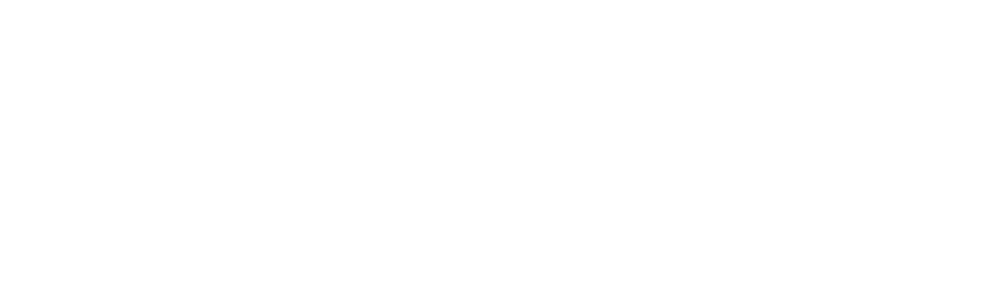

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


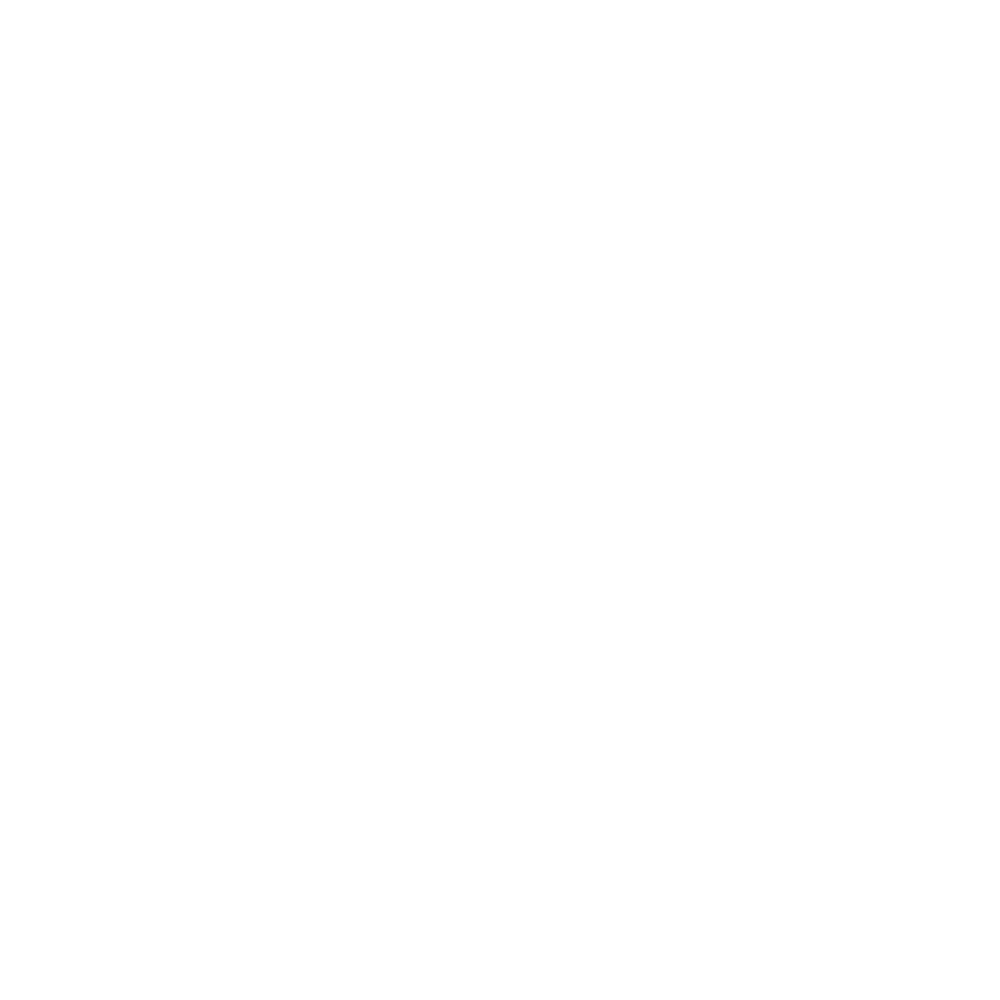

<IPython.core.display.Javascript object>


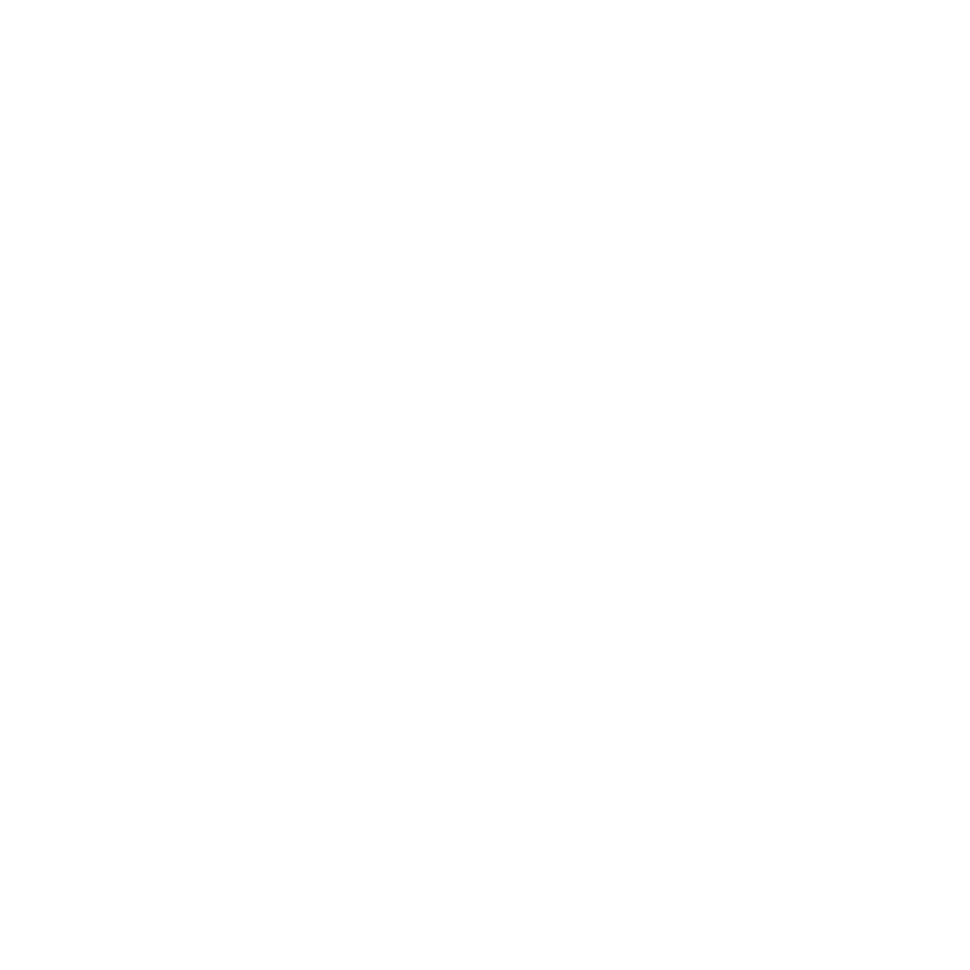

Ref. prior: 67.2133215 au
Fitting SED at 67.413719 au
SED data = [1.31568087e+10 5.07293082e+09 5.51848768e+08]
Per cent error = [10.03380659 10.02580122  5.40466349]
Initial guess = [17.36887213 -1.88807672 -1.1180824   3.60639787]


<IPython.core.display.Javascript object>


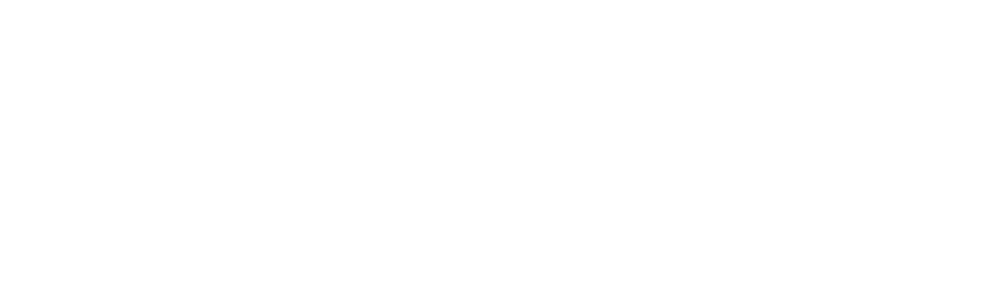

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


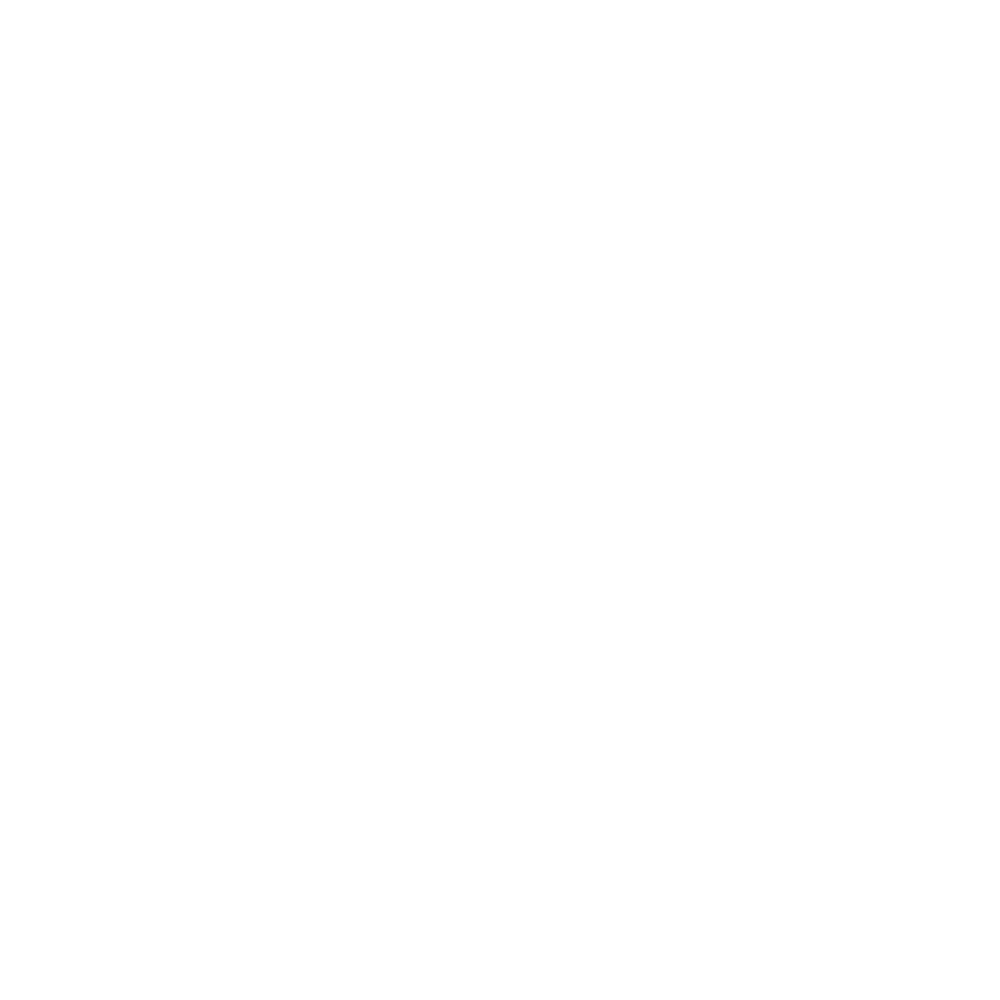

<IPython.core.display.Javascript object>


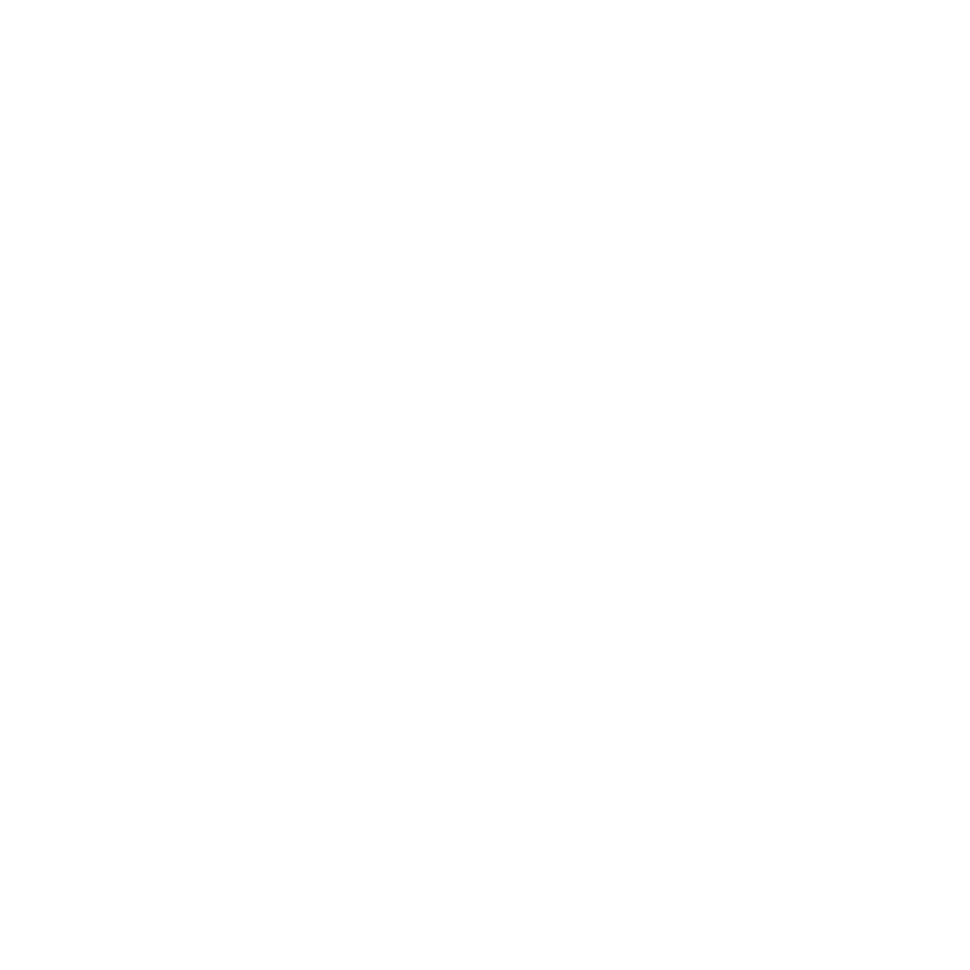

Ref. prior: 70.3395225 au
Fitting SED at 69.27340779999999 au
SED data = [1.26145475e+10 4.79726950e+09 5.10791168e+08]
Per cent error = [10.04628365 10.03112311  5.47320998]
Initial guess = [16.88485026 -1.88963249 -1.11371981  3.64401776]


<IPython.core.display.Javascript object>


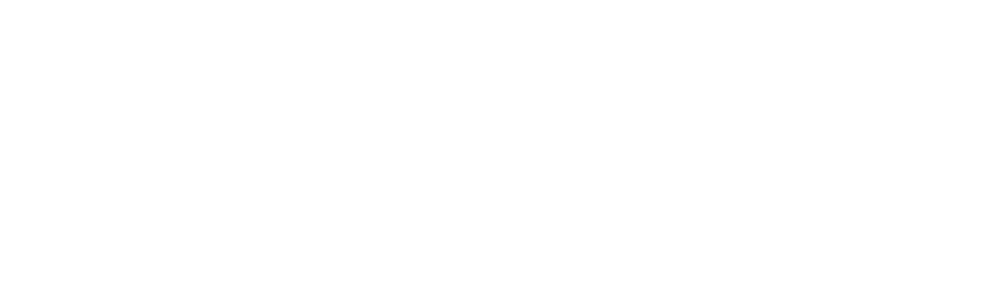

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


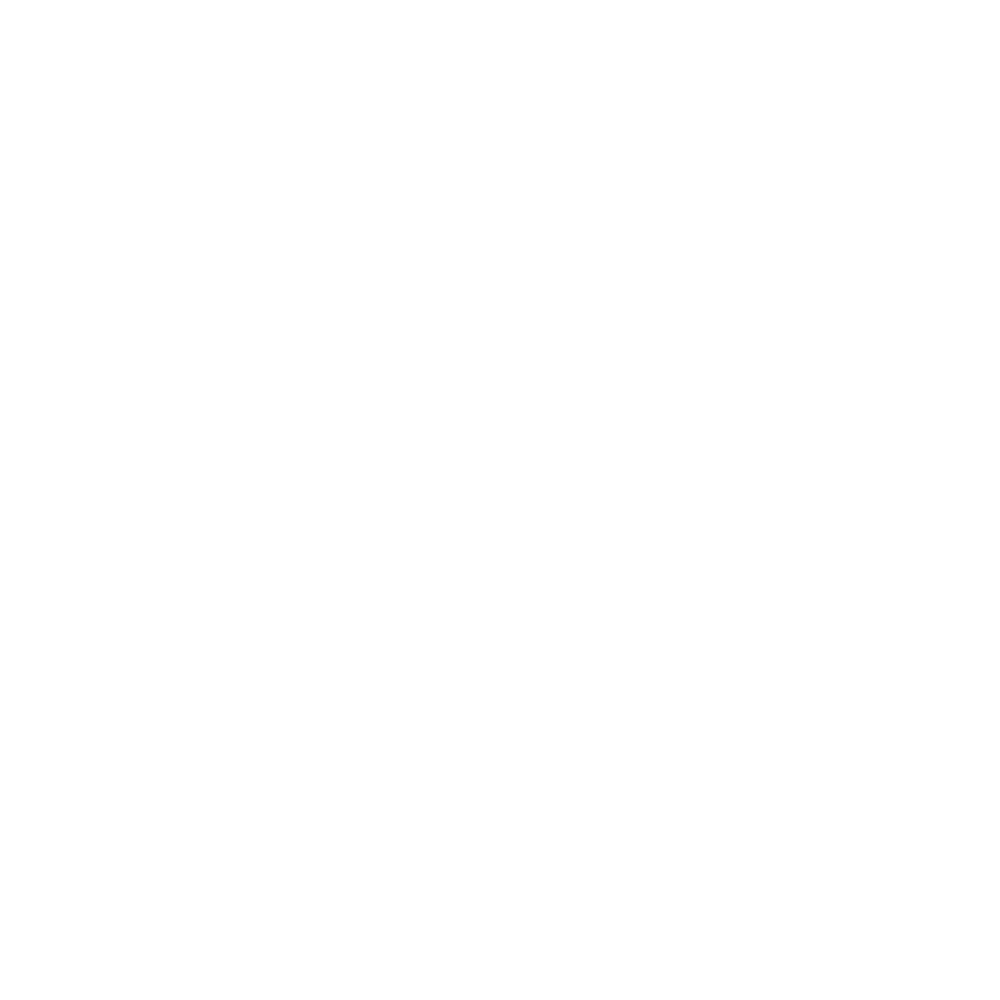

<IPython.core.display.Javascript object>


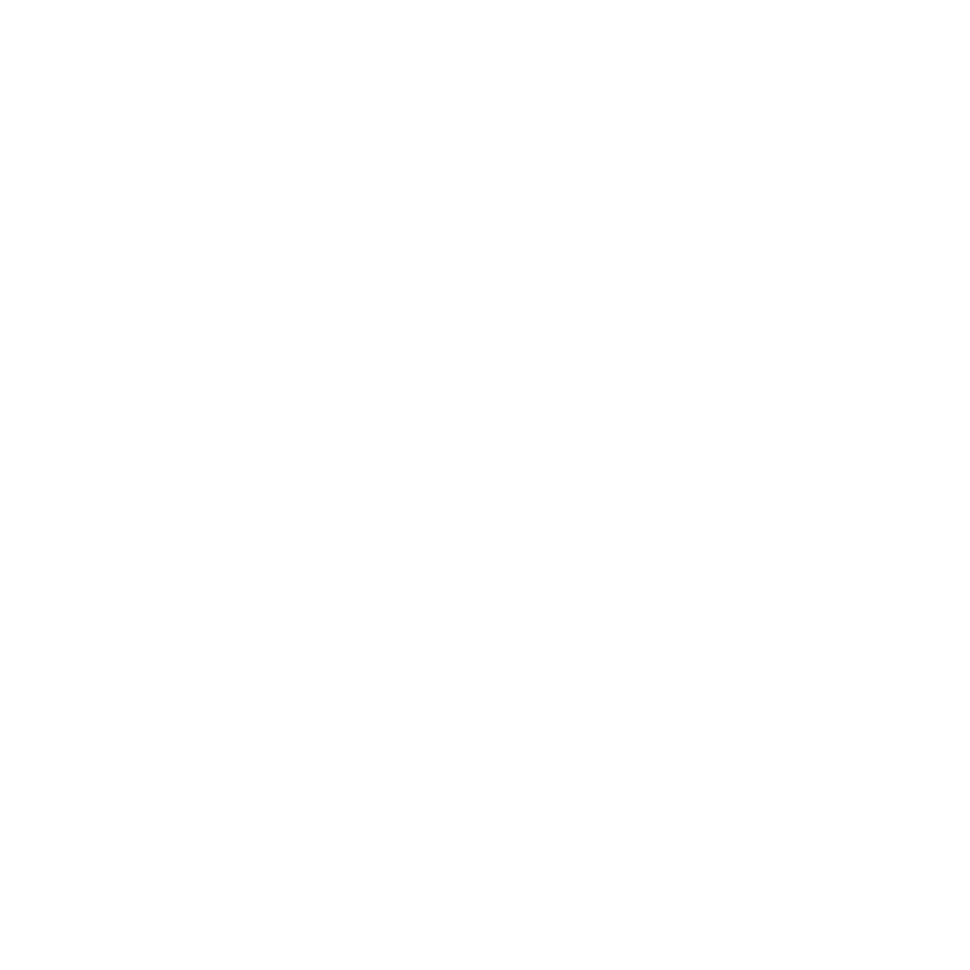

Ref. prior: 70.3395225 au
Fitting SED at 71.1330966 au
SED data = [1.19481201e+10 4.49088563e+09 4.67851808e+08]
Per cent error = [10.04885743 10.02773109  5.55300825]
Initial guess = [16.88485026 -1.88963249 -1.11371981  3.64401776]


<IPython.core.display.Javascript object>


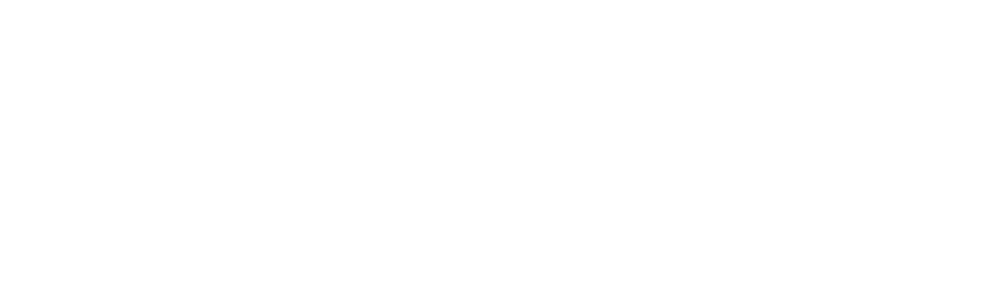

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


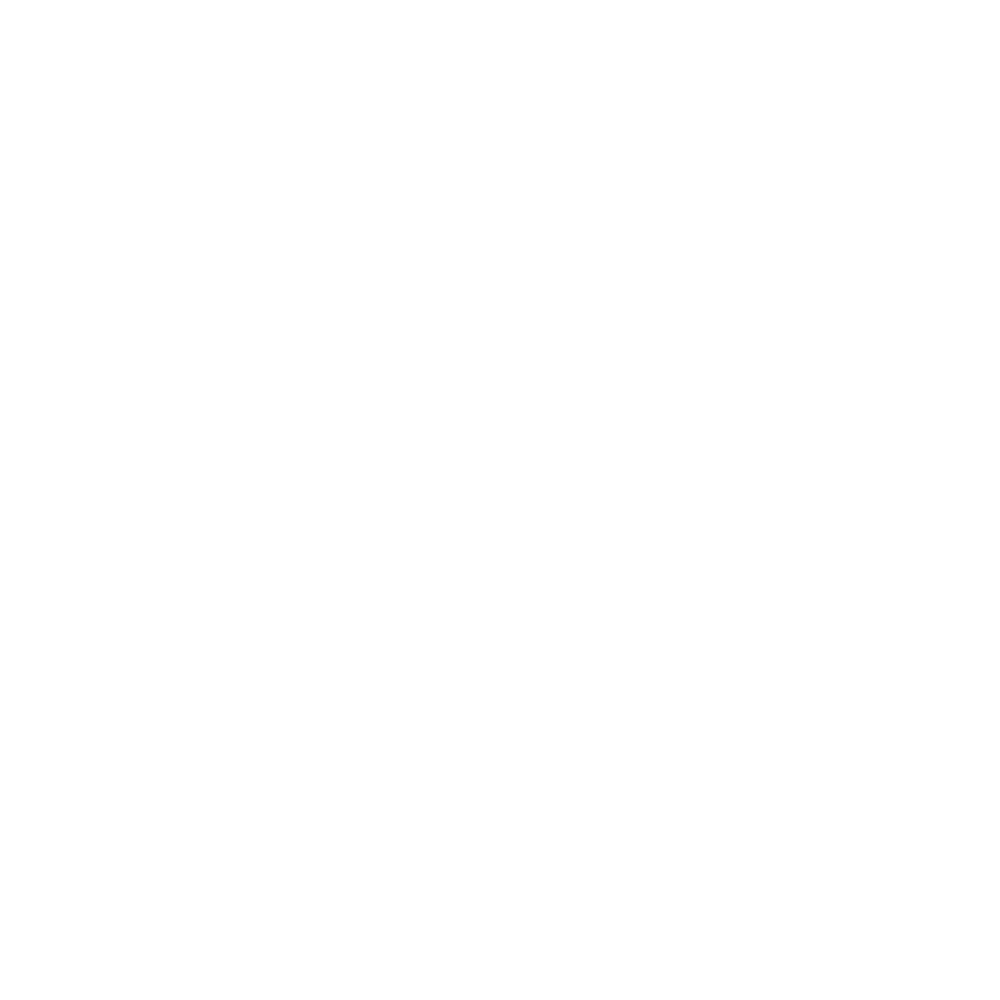

<IPython.core.display.Javascript object>


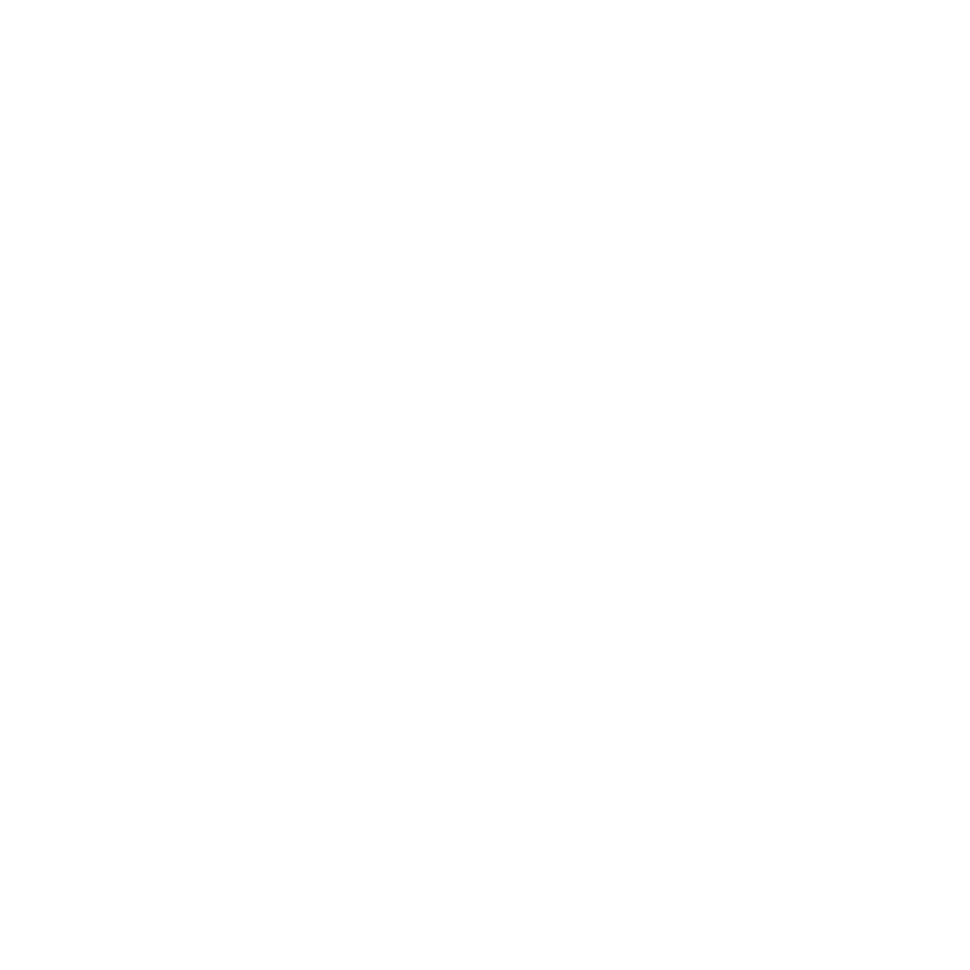

Ref. prior: 73.46572350000001 au
Fitting SED at 72.99278539999999 au
SED data = [1.13730048e+10 4.20377421e+09 4.31153600e+08]
Per cent error = [10.05361576 10.02244221  5.71912886]
Initial guess = [16.52069717 -1.92028283 -1.13194513  3.63494618]


<IPython.core.display.Javascript object>


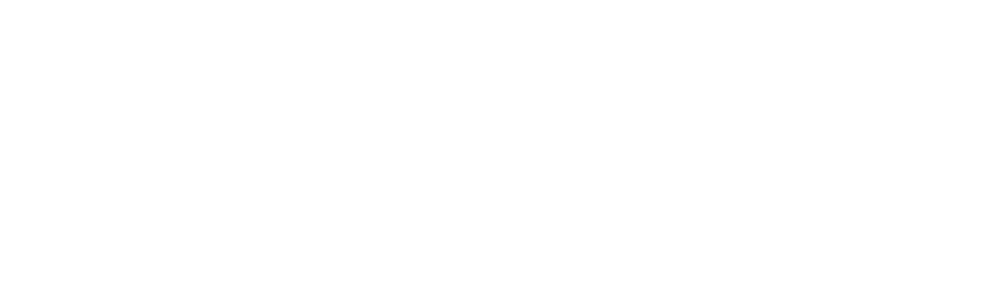

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


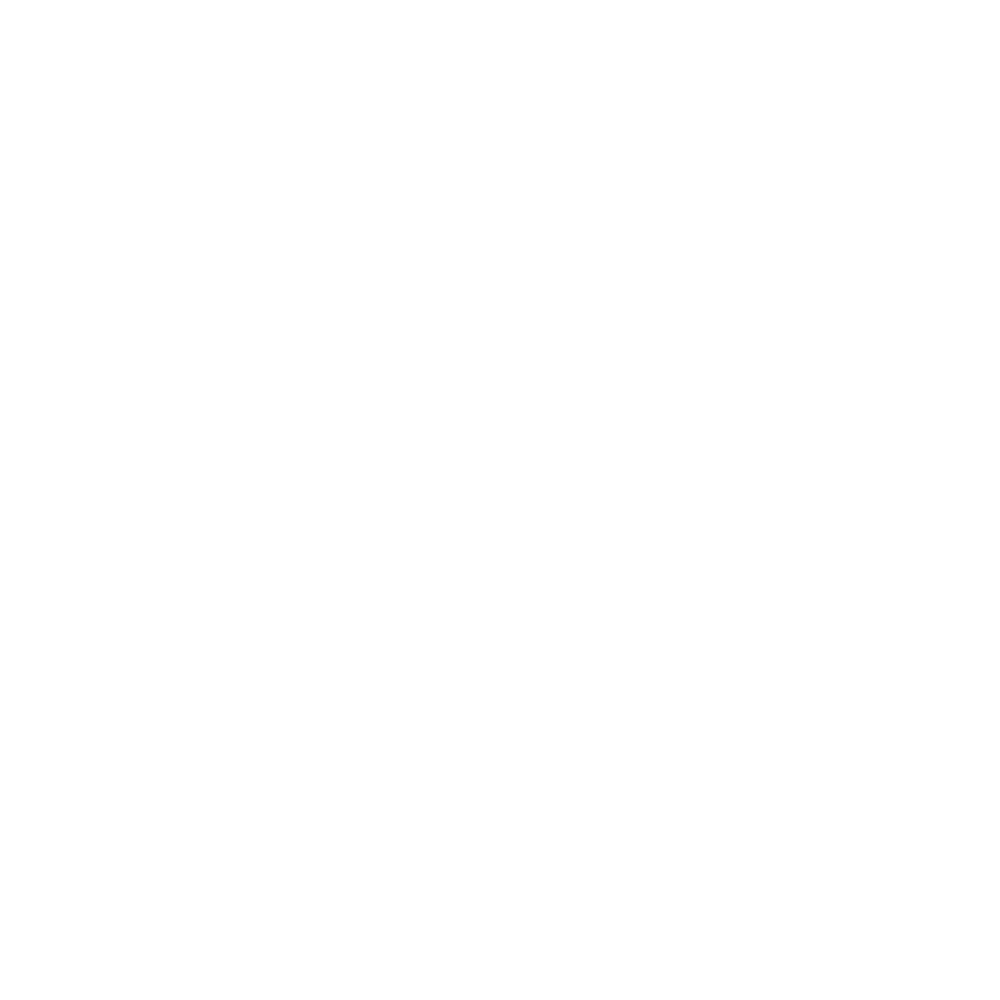

<IPython.core.display.Javascript object>


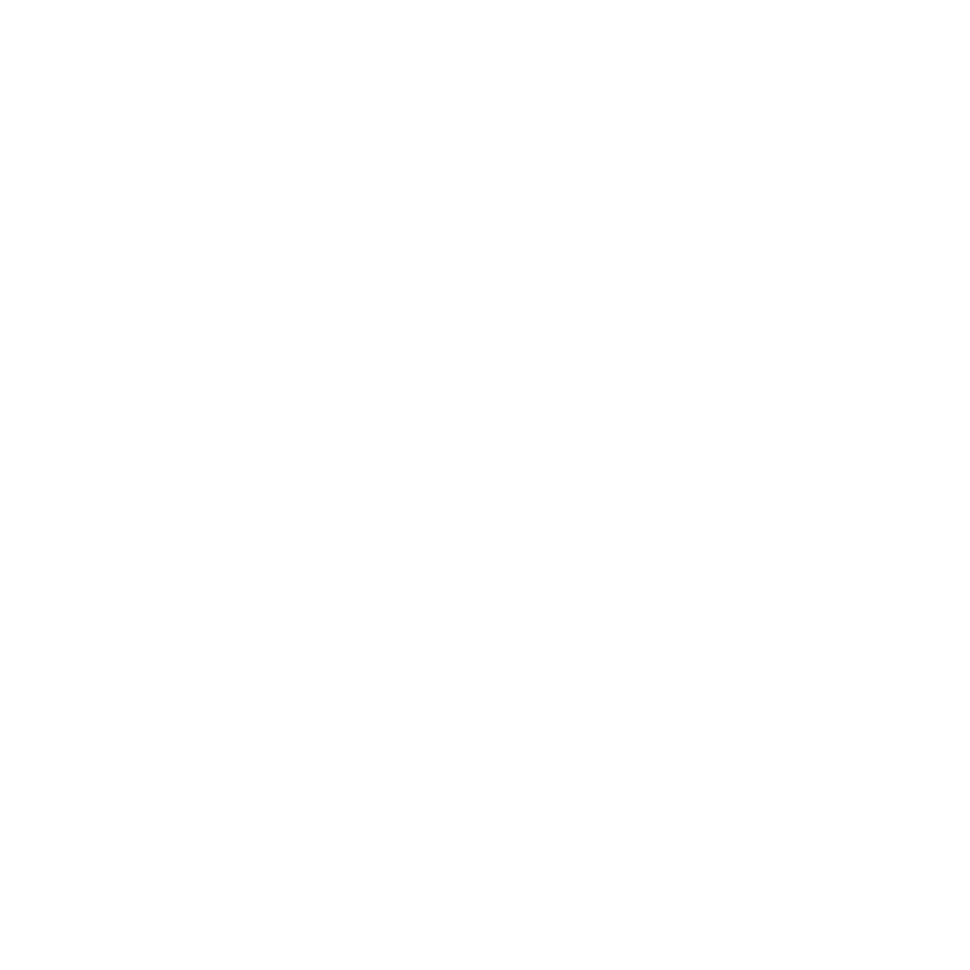

Ref. prior: 73.46572350000001 au
Fitting SED at 74.8524742 au
SED data = [1.06251756e+10 3.87805030e+09 3.91157888e+08]
Per cent error = [10.0669135  10.02595381  5.84836168]
Initial guess = [16.52069717 -1.92028283 -1.13194513  3.63494618]


<IPython.core.display.Javascript object>


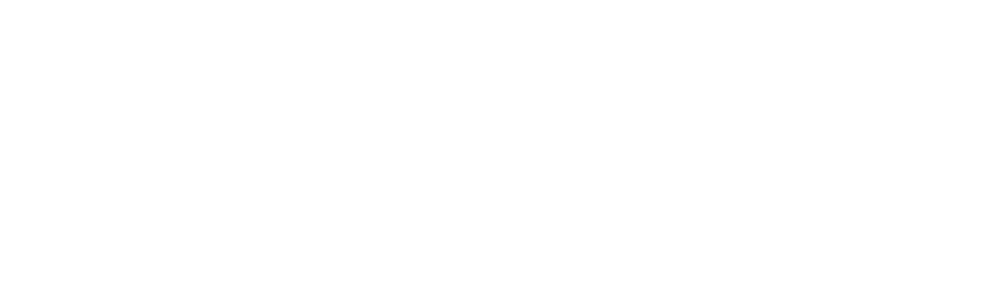

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


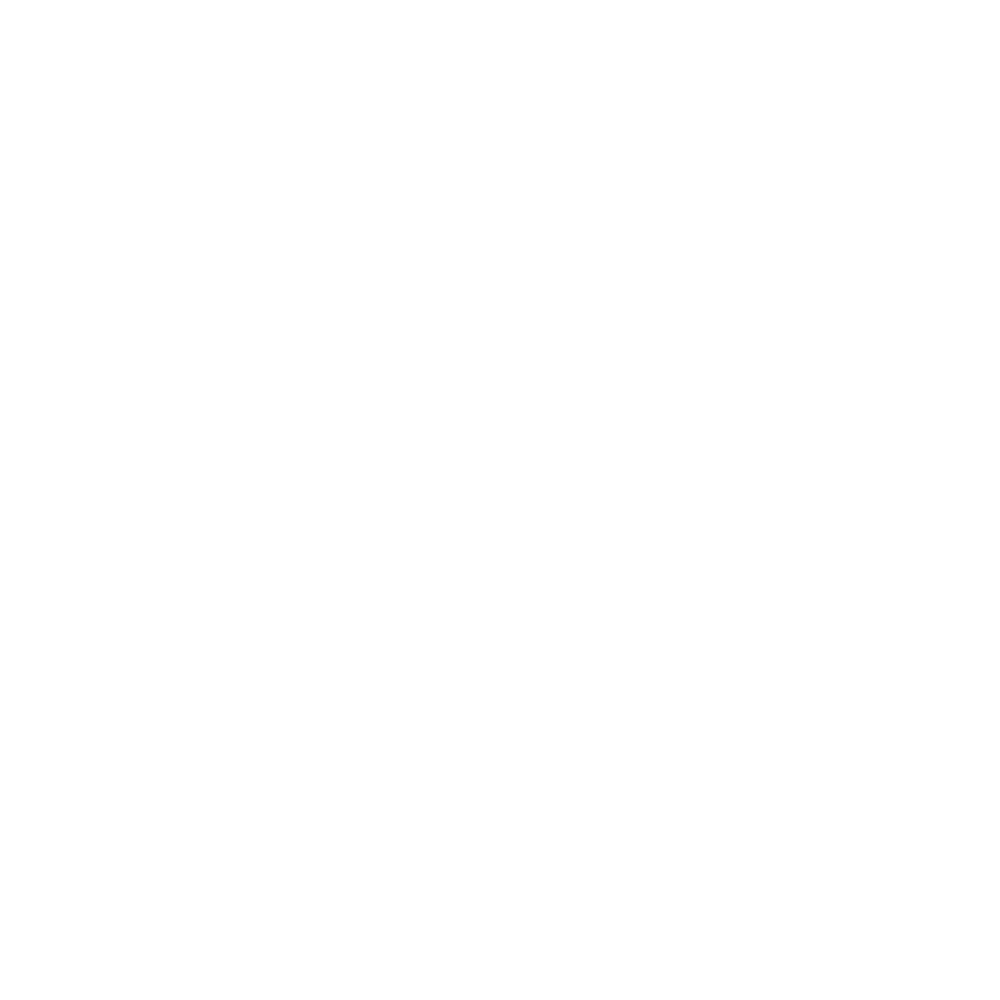

<IPython.core.display.Javascript object>


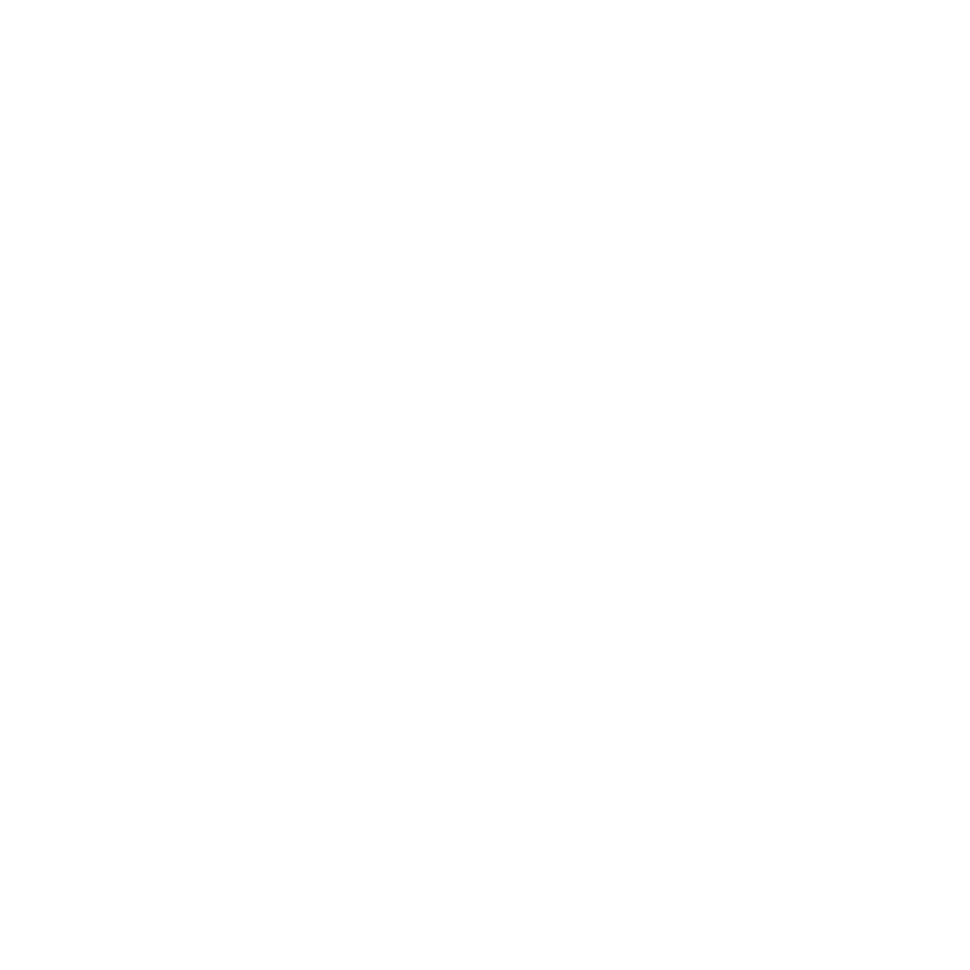

Ref. prior: 76.5919245 au
Fitting SED at 76.71216299999999 au
SED data = [9.93907405e+09 3.56618240e+09 3.56060896e+08]
Per cent error = [10.06846178 10.02569425  5.92592585]
Initial guess = [16.03440257 -1.94537241 -1.15271799  3.63746084]


<IPython.core.display.Javascript object>


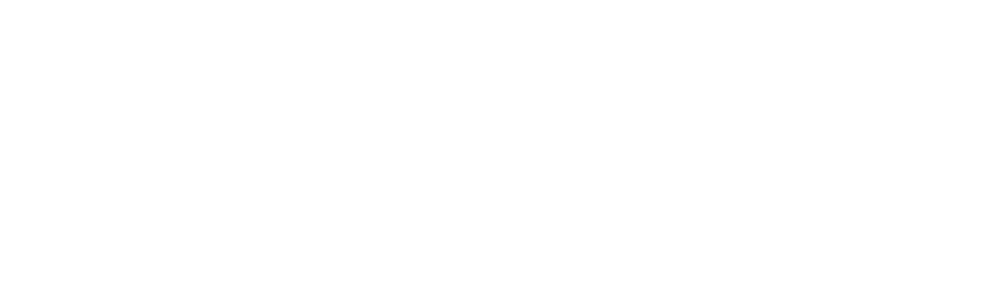

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


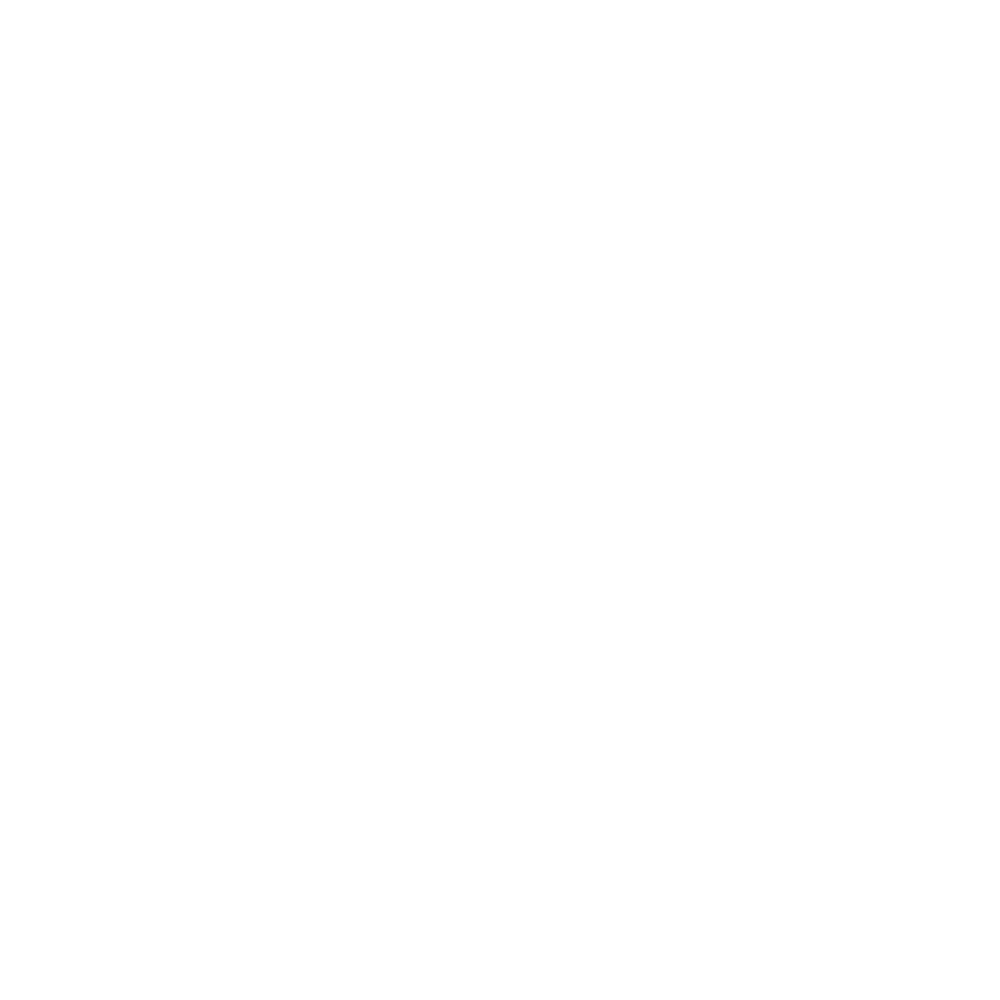

<IPython.core.display.Javascript object>


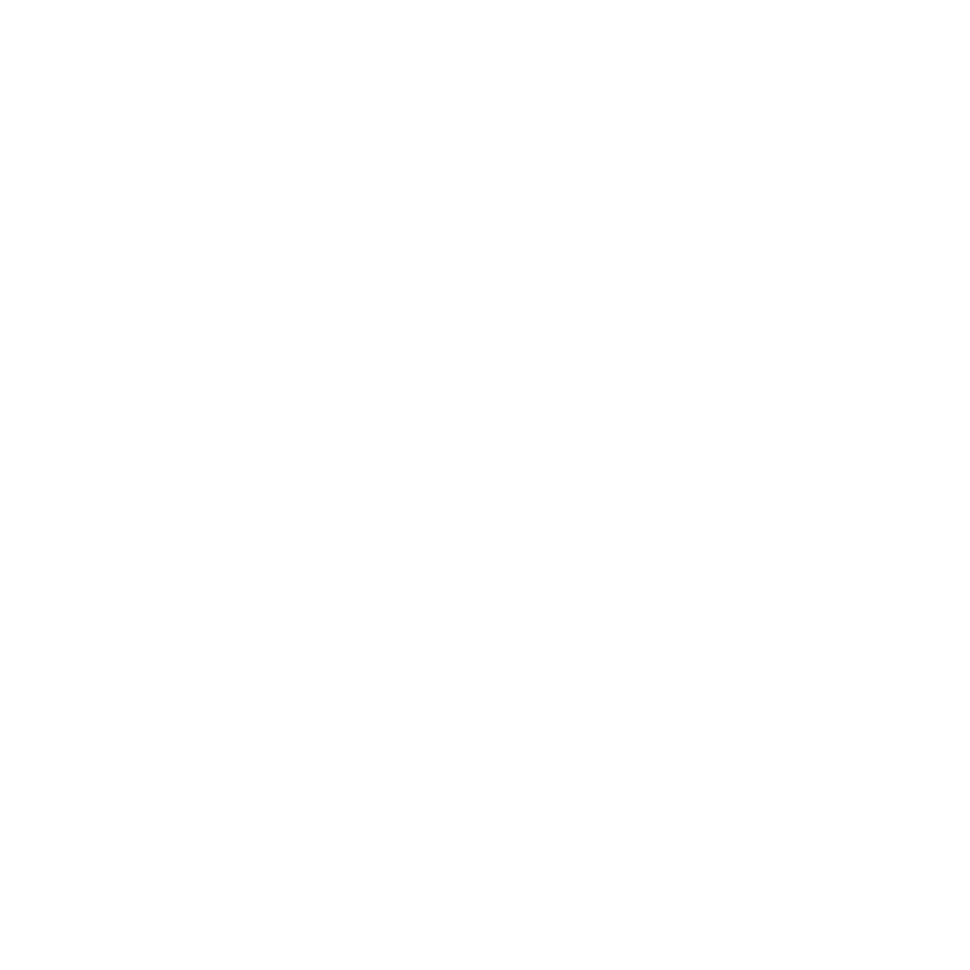

Ref. prior: 79.7181255 au
Fitting SED at 78.5718518 au
SED data = [9.33000704e+09 3.28151270e+09 3.25068128e+08]
Per cent error = [10.06450043 10.02575261  6.02937056]
Initial guess = [15.87084814 -1.95791234 -1.14266949  3.67212472]


<IPython.core.display.Javascript object>


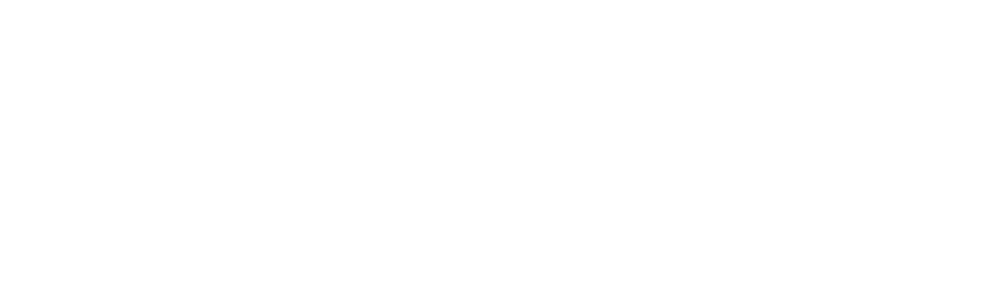

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


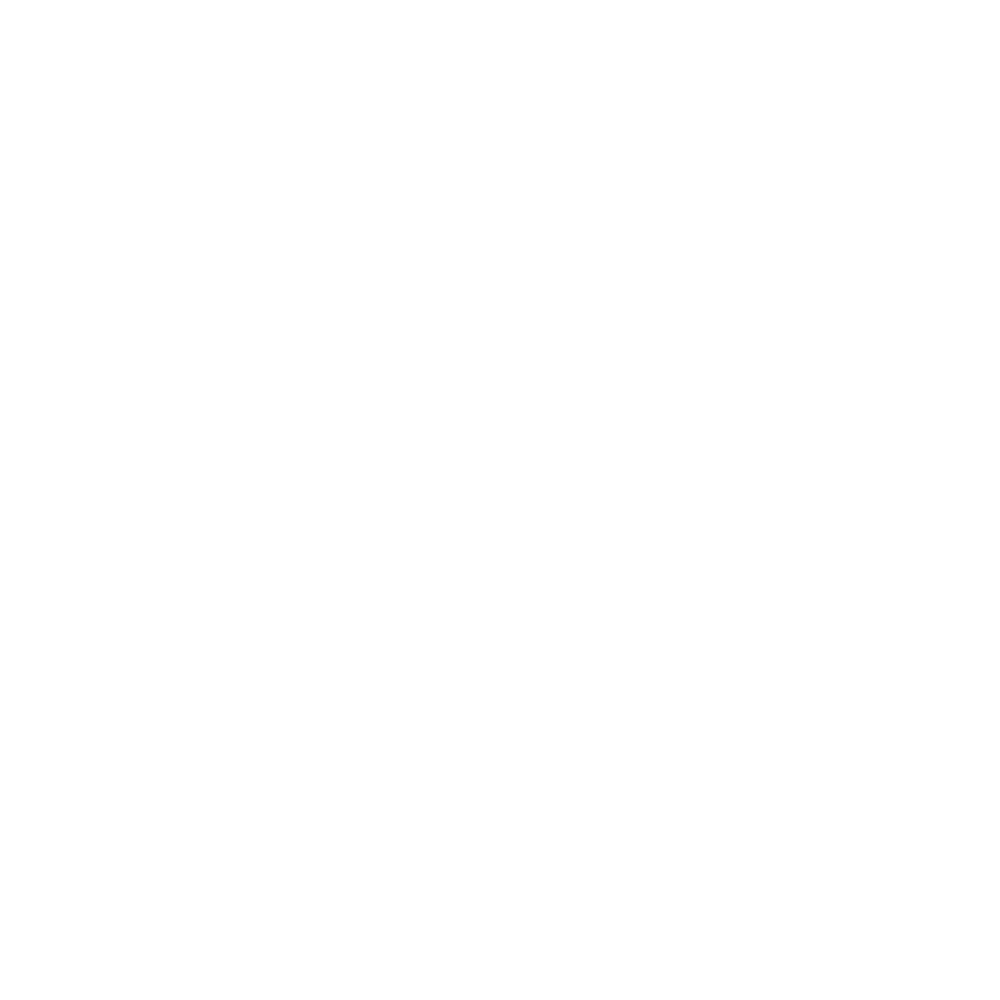

<IPython.core.display.Javascript object>


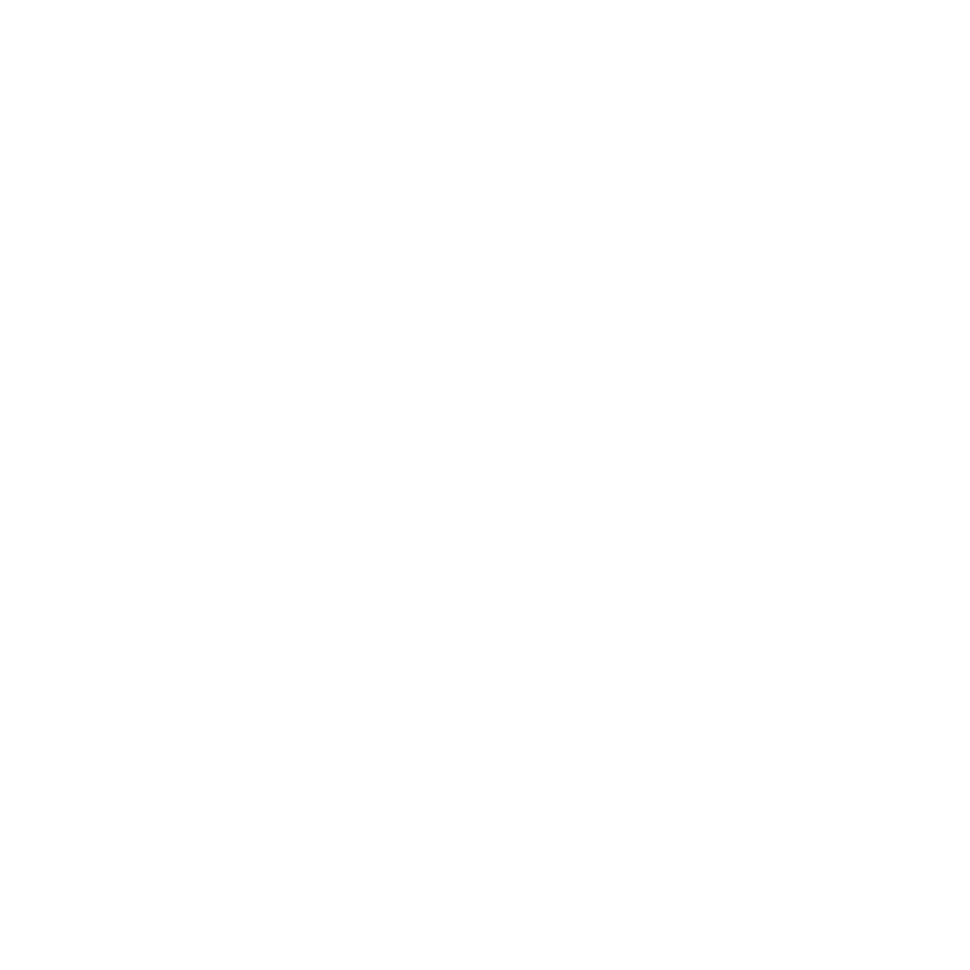

Ref. prior: 79.7181255 au
Fitting SED at 80.43154059999999 au
SED data = [8.64531251e+09 2.99761638e+09 2.99489440e+08]
Per cent error = [10.07299043 10.03393349  6.07073664]
Initial guess = [15.87084814 -1.95791234 -1.14266949  3.67212472]


<IPython.core.display.Javascript object>


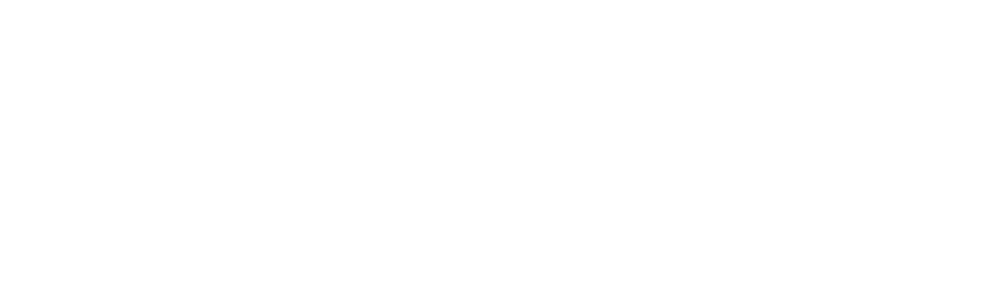

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


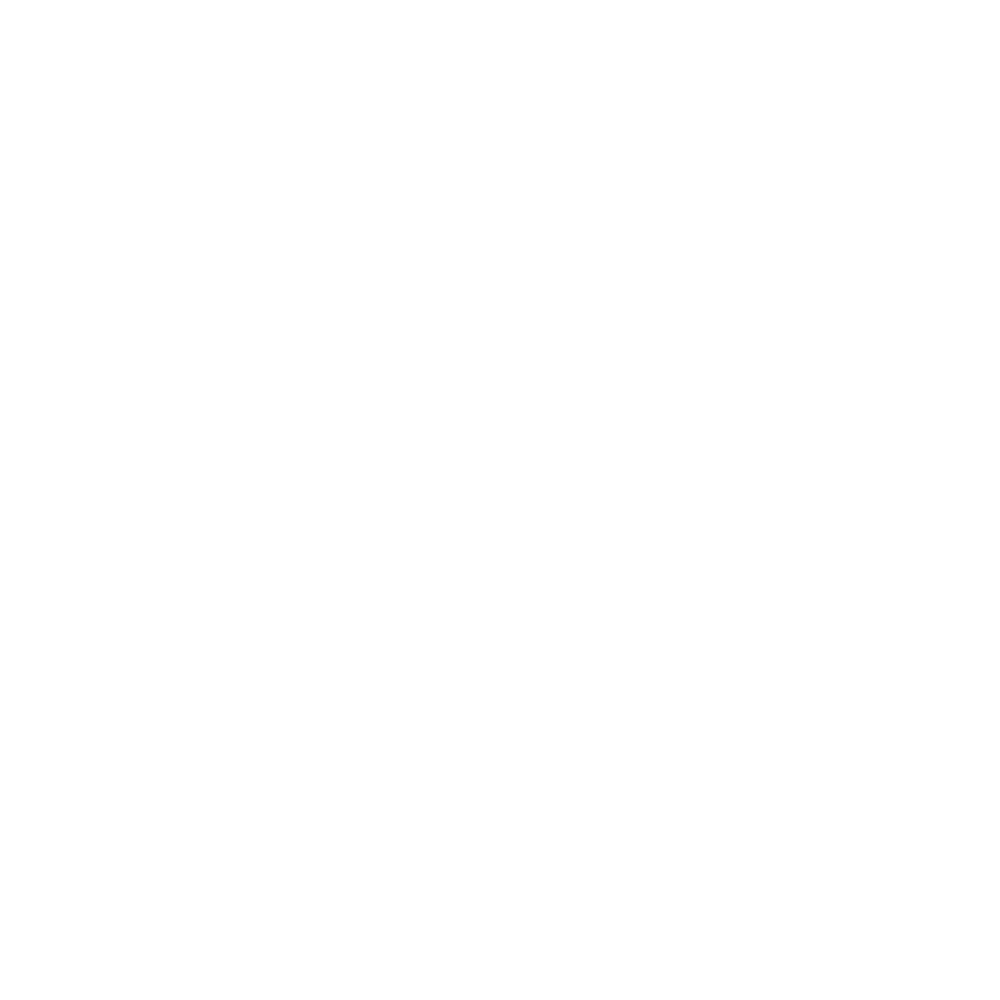

<IPython.core.display.Javascript object>


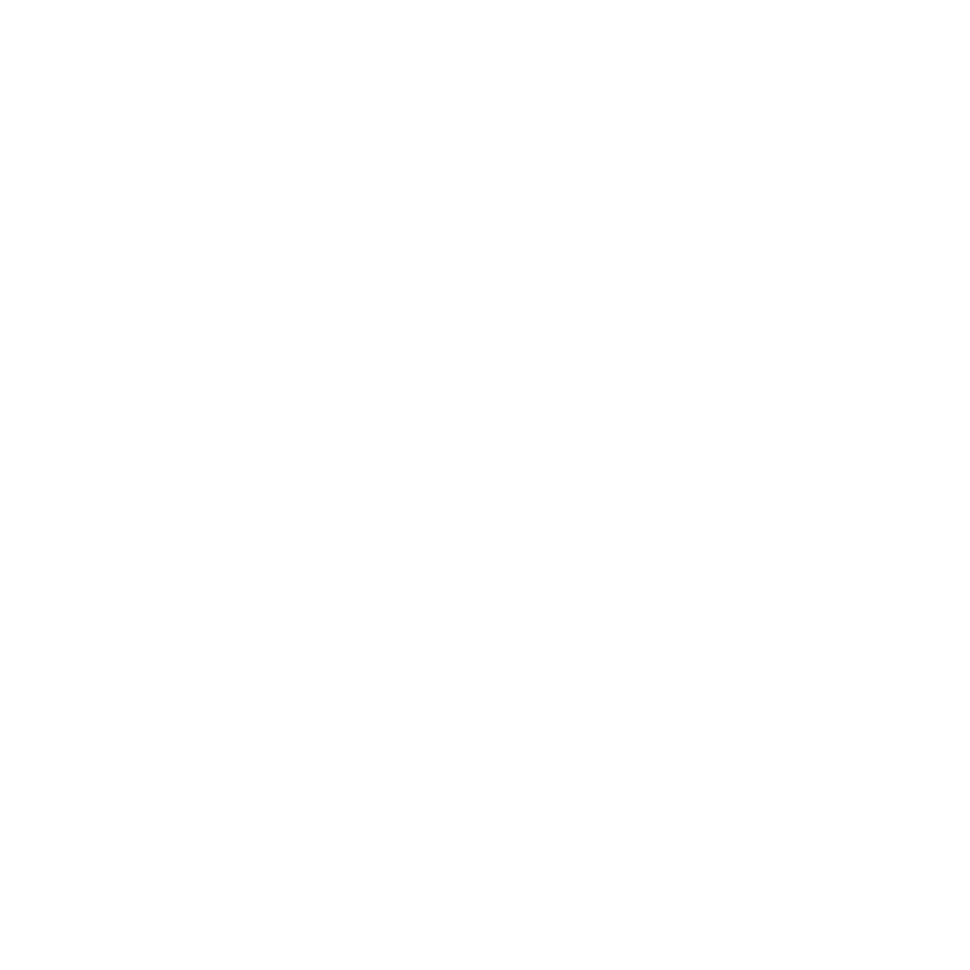

Ref. prior: 82.84432650000001 au
Fitting SED at 82.2912294 au
SED data = [8.10041088e+09 2.75690675e+09 2.76992320e+08]
Per cent error = [10.07347098 10.04084155  6.14492918]
Initial guess = [15.63728035 -2.02294776 -1.19959555  3.6293102 ]


<IPython.core.display.Javascript object>


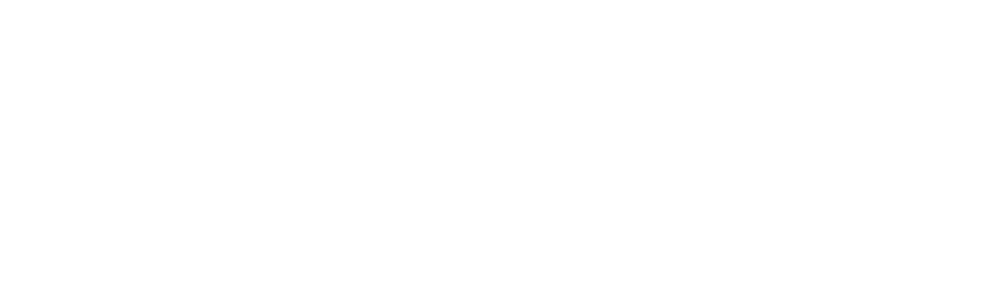

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


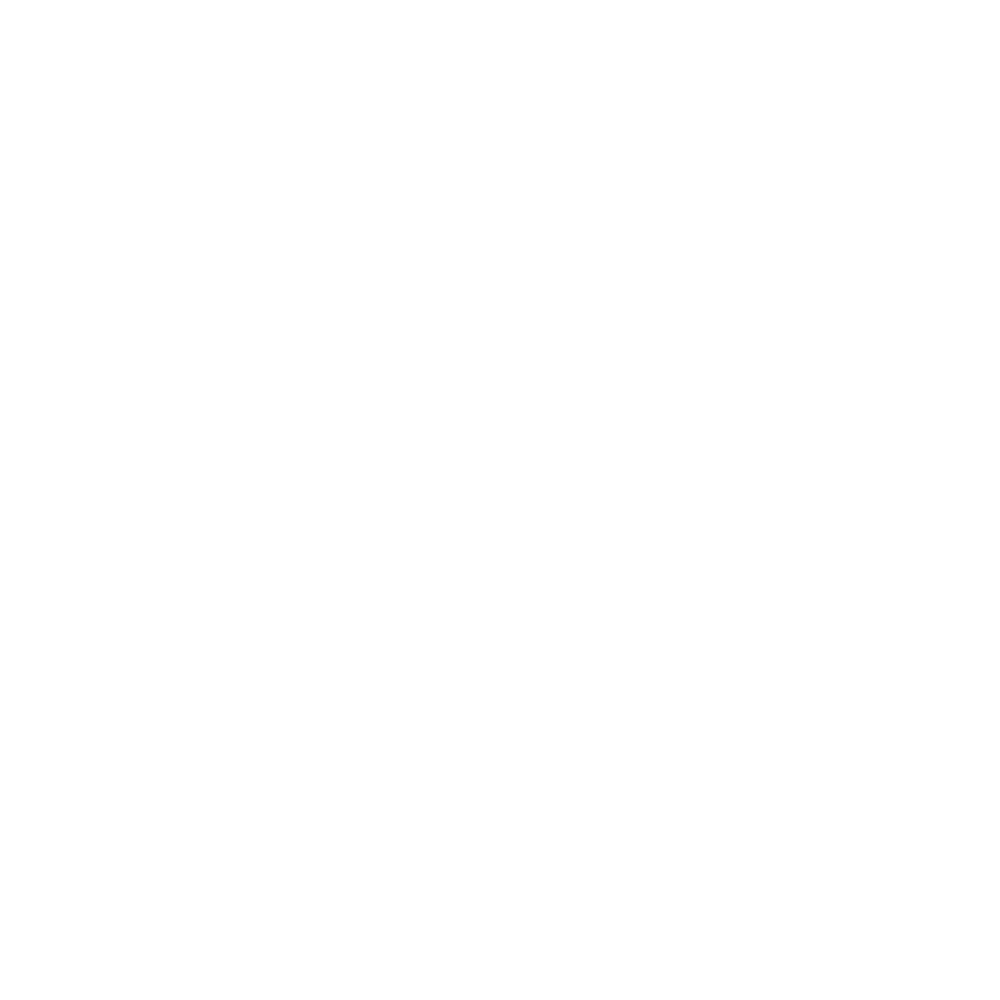

<IPython.core.display.Javascript object>


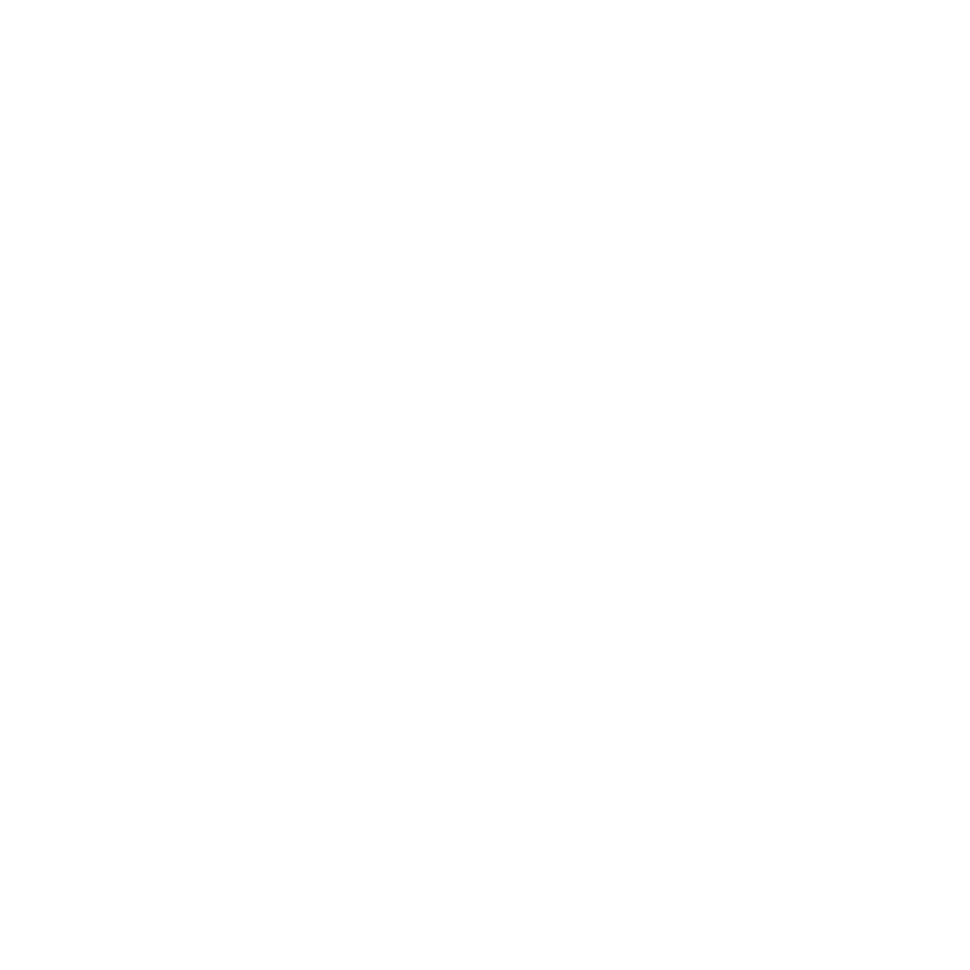

Ref. prior: 82.84432650000001 au
Fitting SED at 84.15091819999999 au
SED data = [7.67536998e+09 2.56138624e+09 2.55020400e+08]
Per cent error = [10.0796732  10.0480357   6.40704325]
Initial guess = [15.63728035 -2.02294776 -1.19959555  3.6293102 ]


<IPython.core.display.Javascript object>


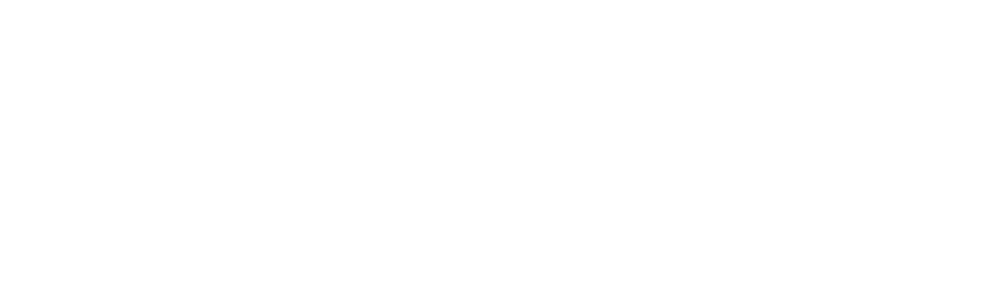

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


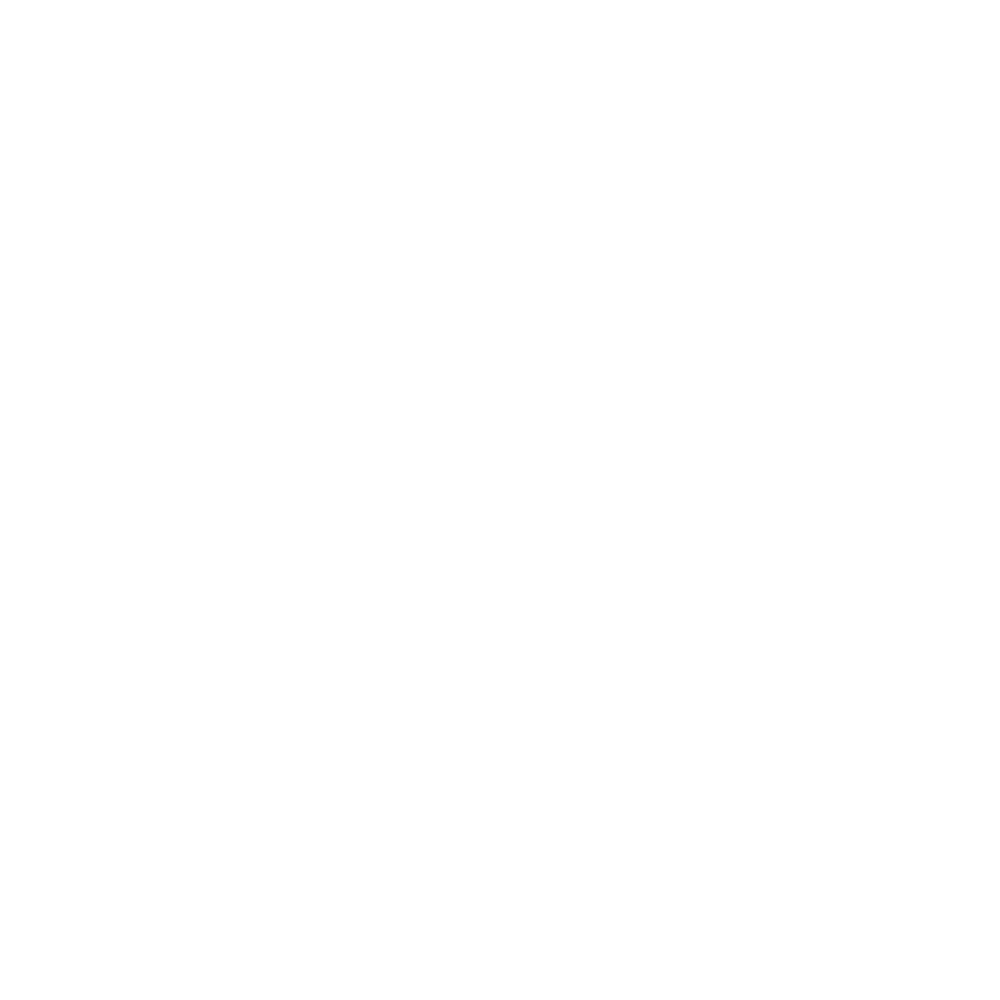

<IPython.core.display.Javascript object>


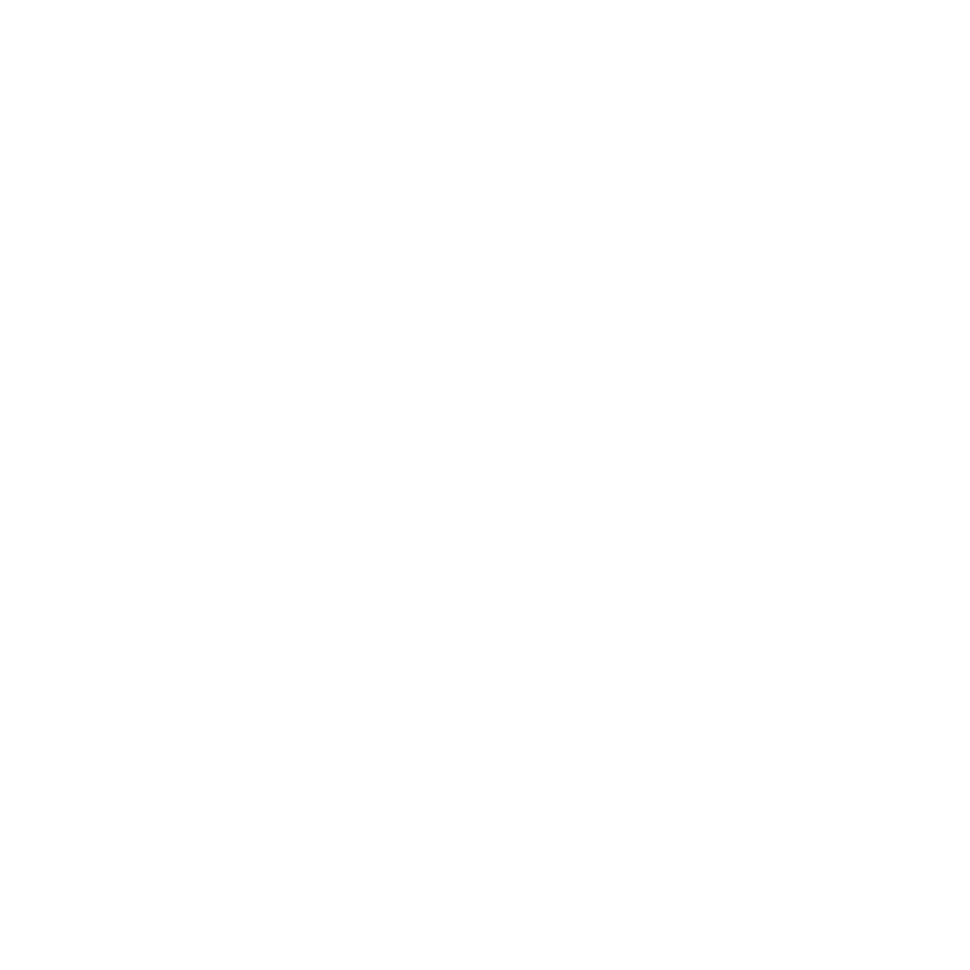

Ref. prior: 85.9705275 au
Fitting SED at 86.01060700000001 au
SED data = [7.22753536e+09 2.36660198e+09 2.42281088e+08]
Per cent error = [10.07704891 10.0577369   6.47090083]
Initial guess = [15.41633983 -2.03557615 -1.18109452  3.66547456]


<IPython.core.display.Javascript object>


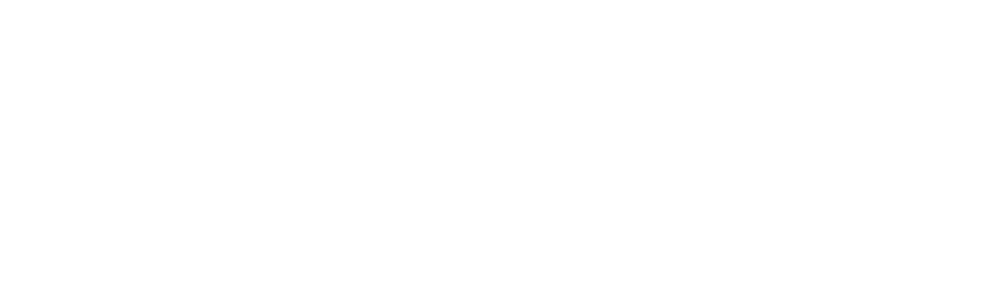

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


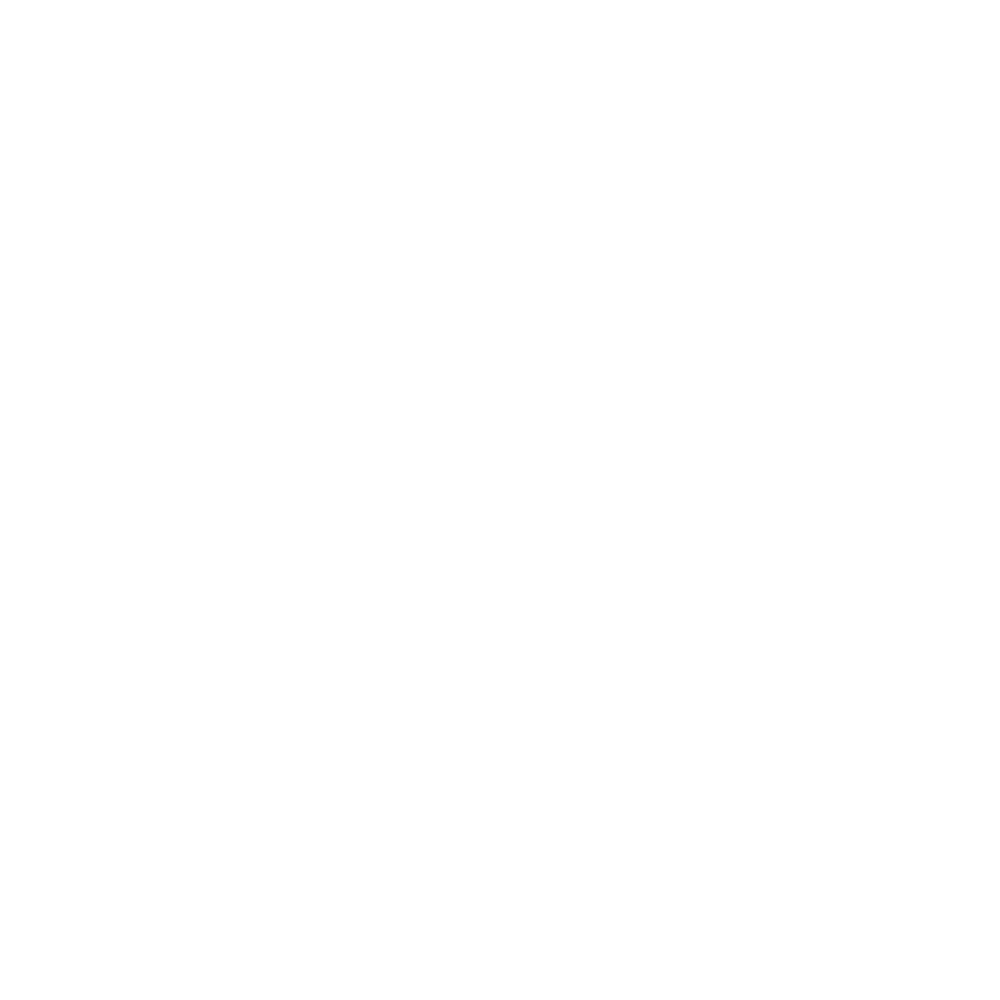

<IPython.core.display.Javascript object>


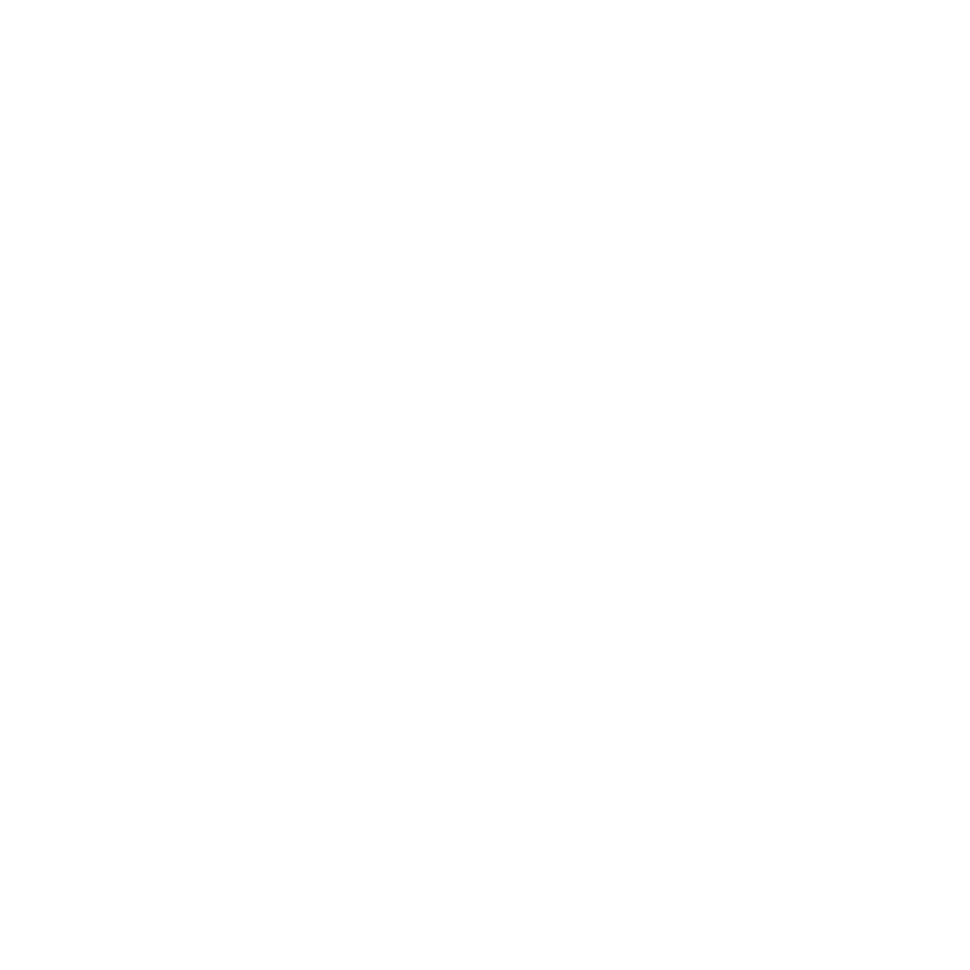

Ref. prior: 89.0967285 au
Fitting SED at 87.8702958 au
SED data = [6.86754714e+09 2.21318733e+09 2.26943952e+08]
Per cent error = [10.07048403 10.05385075  6.5830101 ]
Initial guess = [15.19433102 -2.07322212 -1.19510241  3.66757985]


<IPython.core.display.Javascript object>


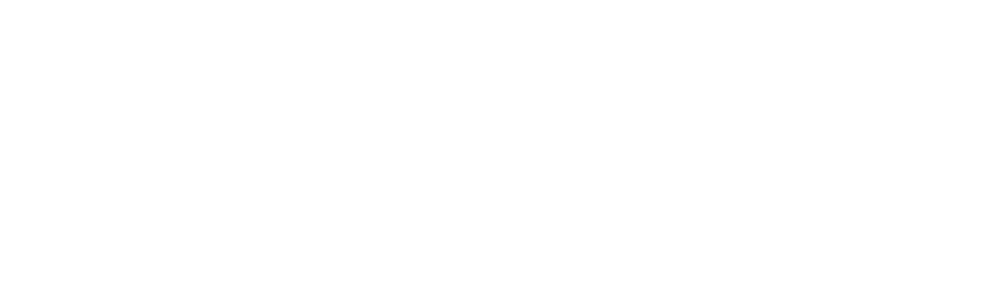

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


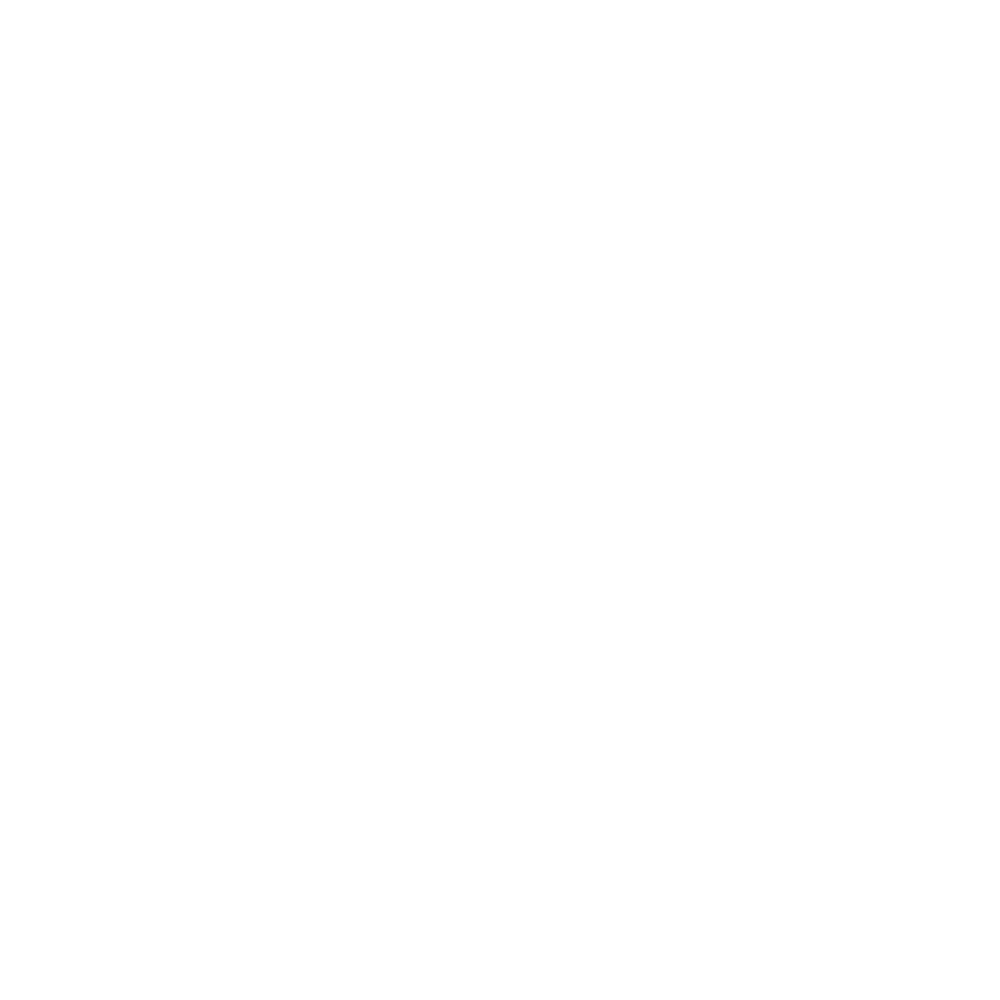

<IPython.core.display.Javascript object>


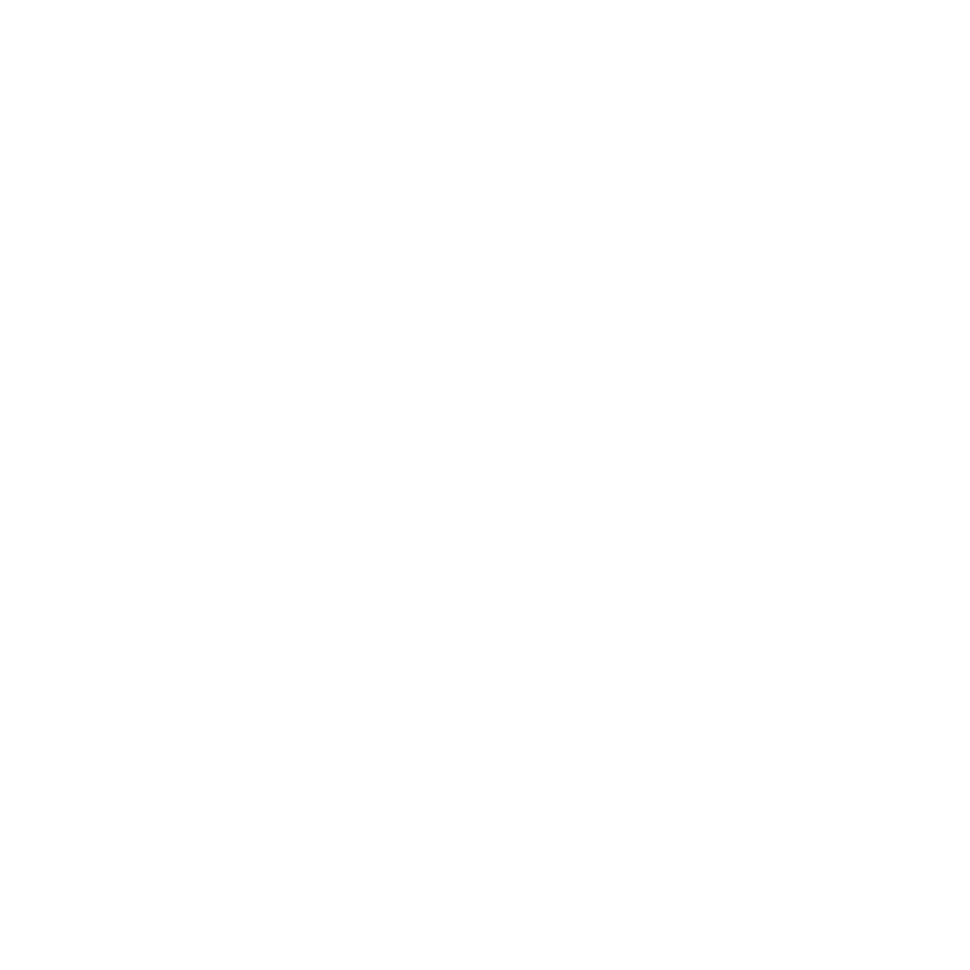

Ref. prior: 89.0967285 au
Fitting SED at 89.72998460000001 au
SED data = [6.55004877e+09 2.08197286e+09 2.14266208e+08]
Per cent error = [10.06958835 10.05323607  6.8216158 ]
Initial guess = [15.19433102 -2.07322212 -1.19510241  3.66757985]


<IPython.core.display.Javascript object>


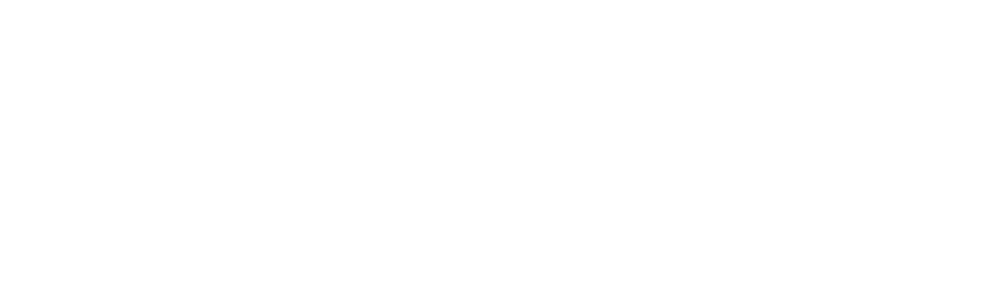

Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


Final file size: 1000


<IPython.core.display.Javascript object>


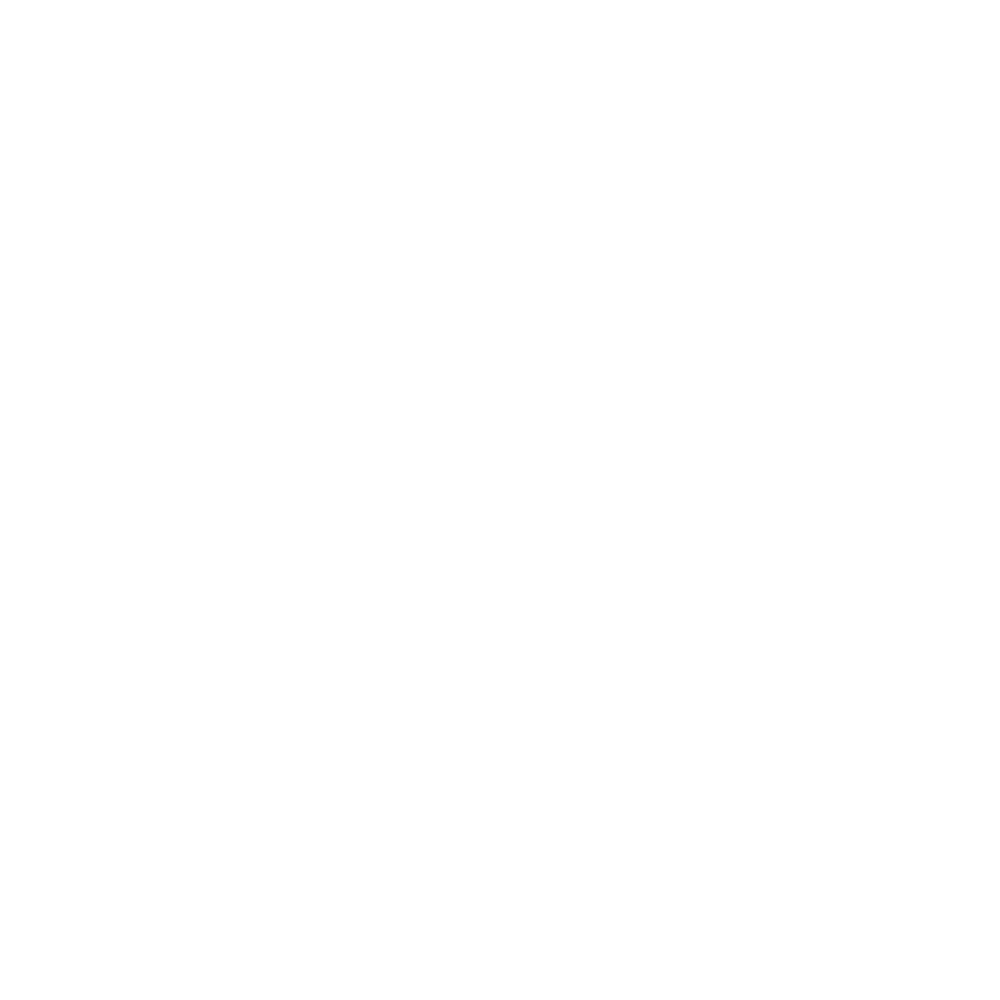

<IPython.core.display.Javascript object>


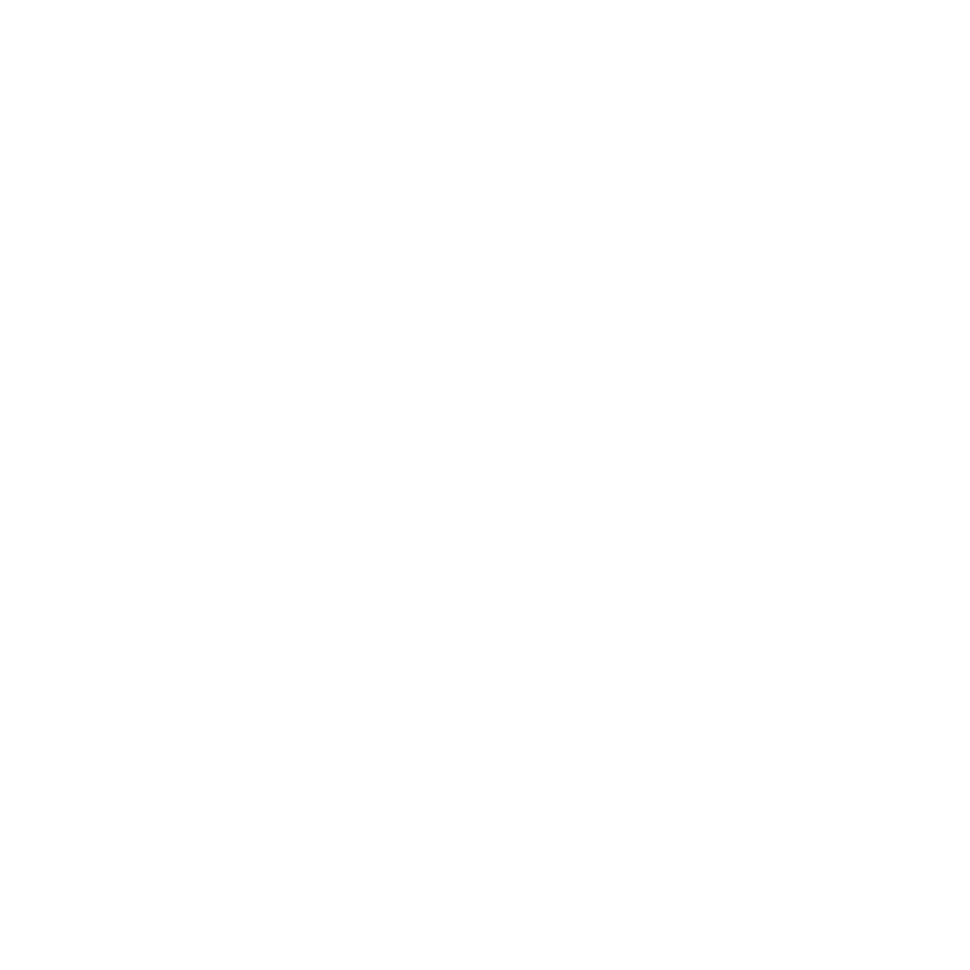

Ref. prior: 92.2229295 au
Fitting SED at 91.5896734 au
SED data = [6.22994278e+09 1.97166707e+09 2.09569792e+08]
Per cent error = [10.06706002 10.04775902  6.81417228]
Initial guess = [15.08321975 -2.12628395 -1.21585647  3.65424309]


<IPython.core.display.Javascript object>


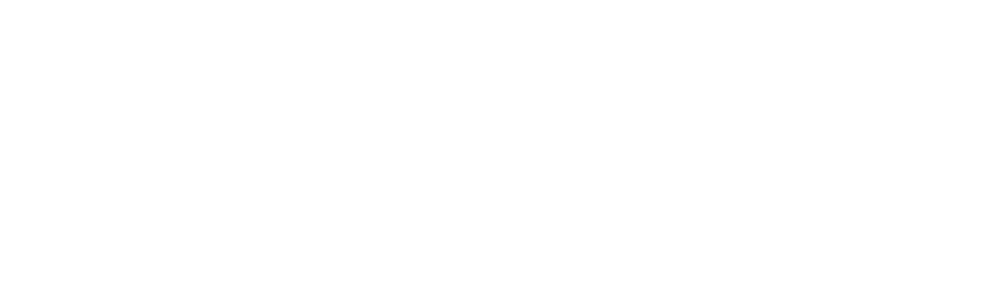

Initial file size: 0


 15%|██████▎                                   | 15/100 [00:19<01:52,  1.32s/it]

In [ ]:
pars = {
    'freq':     np.array([338.23,229.61,97.50]), #GHz
    'rad_grid': rad_init, #au
    'amean_sb': inu_init, #Jy/sr
    'sigma_sb': enu_init, #Jy/sr
    'calerror': np.array([[0.10,0.10,0.05]])
}

fitter = SED_optimizer(pars)

rad_fitVLA = np.loadtxt('../../VLAanalysis/fb_Ricci_mymixture/radprof_Band3.dat',skiprows=1,usecols=0,unpack=True)

for bin_idx in range(0,325,2):
    
    vec = np.abs(rad_fitVLA - rad_init[bin_idx])
    val = np.amin(vec)
    
    idx = np.where(vec == val)[0][0]
    
    rad_prior = rad_fitVLA[idx]
    
    print('Ref. prior: {} au'.format(rad_fitVLA[idx]))
    
    reader  = emcee.backends.HDFBackend("../../VLAanalysis/fb_Ricci_mymixture/chains/CITau_SEDfit_{}.hdf5".format(rad_prior), read_only=True)

    tau     = reader.get_autocorr_time(tol=0)

    burnin  = int(5 * np.max(tau))
    thin    = int(0.5 * np.min(tau))       

    flat_samples = reader.get_chain(discard=burnin, thin=thin, flat=True)

    theta   = np.percentile(flat_samples,50,axis=0)

    fitter.run_fit(
        bin_idx      = bin_idx,
        rad_prior    = rad_prior,
        VLAprior     = True,
        nwalkers     = 100,    # number of walkers
        nsteps       = 100,    # nuber of mcmc steps in each subroutine
        ntot         = 1000,   # total number of mcmc steps
        nthreads     = 16,     # number of threads
        theta        = theta,
        theta_ranges = np.array([[1.,300.], [-3.,3.], [-3.,3.], [1.,4.]]),
        plot_corner  = True
    )